In [1]:
!git clone https://github.com/vsitzmann/siren.git

Cloning into 'siren'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (193/193), 2.18 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
%cd siren

/content/siren


In [3]:
from modules import *

In [4]:
class ConvImgEncoder(nn.Module):
    def __init__(self, channel, image_resolution):
        super().__init__()

        # conv_theta is input convolution
        self.conv_theta = nn.Conv2d(channel, 128, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)

        self.cnn = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            Conv2dResBlock(256, 256),
            Conv2dResBlock(256, 256),
            Conv2dResBlock(256, 256),
            Conv2dResBlock(256, 256),
            nn.Conv2d(256, 256, 1, 1, 0)
        )

        self.relu_2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(image_resolution * image_resolution, 1)

        self.image_resolution = image_resolution

    def forward(self, I):
        o = self.relu(self.conv_theta(I))
        o = self.cnn(o)

        # print(o.shape)

        o = self.fc(self.relu_2(o).view(o.shape[0], 256, -1)).squeeze(-1)
        return o

In [5]:
net_ = ConvImgEncoder(3, 32)

In [6]:
net_(torch.ones((1, 3, 32, 32))).shape

torch.Size([1, 256])

In [35]:
'''Modules for hypernetwork experiments, Paper Sec. 4.4
'''

import torch
from torch import nn
from collections import OrderedDict
import modules


class HyperNetwork(nn.Module):
    def __init__(self, hyper_in_features, hyper_hidden_layers, hyper_hidden_features, hypo_module):
        '''

        Args:
            hyper_in_features: In features of hypernetwork
            hyper_hidden_layers: Number of hidden layers in hypernetwork
            hyper_hidden_features: Number of hidden units in hypernetwork
            hypo_module: MetaModule. The module whose parameters are predicted.
        '''
        super().__init__()

        hypo_parameters = hypo_module.meta_named_parameters()

        self.names = []
        self.nets = nn.ModuleList()
        self.param_shapes = []
        for name, param in hypo_parameters:
            self.names.append(name)
            self.param_shapes.append(param.size())

            hn = modules.FCBlock(in_features=hyper_in_features, out_features=int(torch.prod(torch.tensor(param.size()))),
                                 num_hidden_layers=hyper_hidden_layers, hidden_features=hyper_hidden_features,
                                 outermost_linear=True, nonlinearity='relu')
            self.nets.append(hn)

            if 'weight' in name:
                self.nets[-1].net[-1].apply(lambda m: hyper_weight_init(m, param.size()[-1]))
            elif 'bias' in name:
                self.nets[-1].net[-1].apply(lambda m: hyper_bias_init(m))

    def forward(self, z):
        '''
        Args:
            z: Embedding. Input to hypernetwork. Could be output of "Autodecoder" (see above)

        Returns:
            params: OrderedDict. Can be directly passed as the "params" parameter of a MetaModule.
        '''
        params = OrderedDict()
        for name, net, param_shape in zip(self.names, self.nets, self.param_shapes):
            batch_param_shape = (-1,) + param_shape
            params[name] = net(z).reshape(batch_param_shape)
        return params


class NeuralProcessImplicit2DHypernet(nn.Module):
    '''A canonical 2D representation hypernetwork mapping 2D coords to out_features.'''
    def __init__(self, in_features, out_features, image_resolution=None, encoder_nl='sine'):
        super().__init__()

        latent_dim = 256
        self.hypo_net = modules.SingleBVPNet(out_features=out_features, type='sine', sidelength=image_resolution,
                                             in_features=2)
        self.hyper_net = HyperNetwork(hyper_in_features=latent_dim, hyper_hidden_layers=3, hyper_hidden_features=256,
                                      hypo_module=self.hypo_net)
        self.set_encoder = modules.SetEncoder(in_features=in_features, out_features=latent_dim, num_hidden_layers=2,
                                              hidden_features=latent_dim, nonlinearity=encoder_nl)
        print(self)

    def freeze_hypernet(self):
        for param in self.hyper_net.parameters():
            param.requires_grad = False

    def get_hypo_net_weights(self, model_input):
        pixels, coords = model_input['img_sub'], model_input['coords_sub']
        ctxt_mask = model_input.get('ctxt_mask', None)
        embedding = self.set_encoder(coords, pixels, ctxt_mask=ctxt_mask)
        hypo_params = self.hyper_net(embedding)
        return hypo_params, embedding

    def forward(self, model_input):
        if model_input.get('embedding', None) is None:
            pixels, coords = model_input['img_sub'], model_input['coords_sub']
            ctxt_mask = model_input.get('ctxt_mask', None)
            embedding = self.set_encoder(coords, pixels, ctxt_mask=ctxt_mask)
        else:
            embedding = model_input['embedding']
        hypo_params = self.hyper_net(embedding)

        model_output = self.hypo_net(model_input, params=hypo_params)
        return {'model_in':model_output['model_in'], 'model_out':model_output['model_out'], 'latent_vec':embedding,
                'hypo_params':hypo_params}


class ConvolutionalNeuralProcessImplicit2DHypernet(nn.Module):
    def __init__(self, in_features, out_features, image_resolution=28, partial_conv=False):
        super().__init__()
        latent_dim = 256

        if partial_conv:
            self.encoder = modules.PartialConvImgEncoder(channel=in_features, image_resolution=image_resolution)
        else:
            self.encoder = ConvImgEncoder(channel=in_features, image_resolution=image_resolution)
        self.hypo_net = modules.FCBlock(2, 3, 3, 256, outermost_linear=True, nonlinearity='sine', weight_init=None)
        self.hyper_net = HyperNetwork(hyper_in_features=latent_dim, hyper_hidden_layers=1, hyper_hidden_features=256,
                                      hypo_module=self.hypo_net)

    def forward(self, model_input):
        if model_input.get('embedding', None) is None:
            embedding = self.encoder(model_input['img_sparse'])
        else:
            embedding = model_input['embedding']
        hypo_params = self.hyper_net(embedding)

        model_output = self.hypo_net(model_input["coords"], params=hypo_params)

        return {'model_out': model_output, 'latent_vec': embedding,
                'hypo_params': hypo_params}

    def get_hypo_net_weights(self, model_input):
        embedding = self.encoder(model_input['img_sparse'])
        hypo_params = self.hyper_net(embedding)
        return hypo_params, embedding

    def freeze_hypernet(self):
        for param in self.hyper_net.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False


############################
# Initialization schemes
def hyper_weight_init(m, in_features_main_net):
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1.e2

    if hasattr(m, 'bias'):
        with torch.no_grad():
            m.bias.uniform_(-1/in_features_main_net, 1/in_features_main_net)


def hyper_bias_init(m):
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1.e2

    if hasattr(m, 'bias'):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        with torch.no_grad():
            m.bias.uniform_(-1/fan_in, 1/fan_in)

In [8]:
import torchvision.datasets as datasets
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

In [10]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [29]:
from torch.utils.data import DataLoader, Dataset

class ImageFitting(Dataset):
    def __init__(self, sidelength, img):
        super().__init__()
        # print(img.shape)
        self.pixels = img.view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [30]:
import numpy as np
cameraman = ImageFitting(32, torch.Tensor(np.array(cifar_trainset[0][0])))
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

In [31]:
img_siren = modules.FCBlock(2, 3, 3, 128, outermost_linear=True, nonlinearity='sine', weight_init=None)
img_siren.cuda()

FCBlock(
  (net): MetaSequential(
    (0): MetaSequential(
      (0): BatchLinear(in_features=2, out_features=128, bias=True)
      (1): Sine()
    )
    (1): MetaSequential(
      (0): BatchLinear(in_features=128, out_features=128, bias=True)
      (1): Sine()
    )
    (2): MetaSequential(
      (0): BatchLinear(in_features=128, out_features=128, bias=True)
      (1): Sine()
    )
    (3): MetaSequential(
      (0): BatchLinear(in_features=128, out_features=128, bias=True)
      (1): Sine()
    )
    (4): MetaSequential(
      (0): BatchLinear(in_features=128, out_features=3, bias=True)
    )
  )
)

In [32]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.183609
tensor(0.1358, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


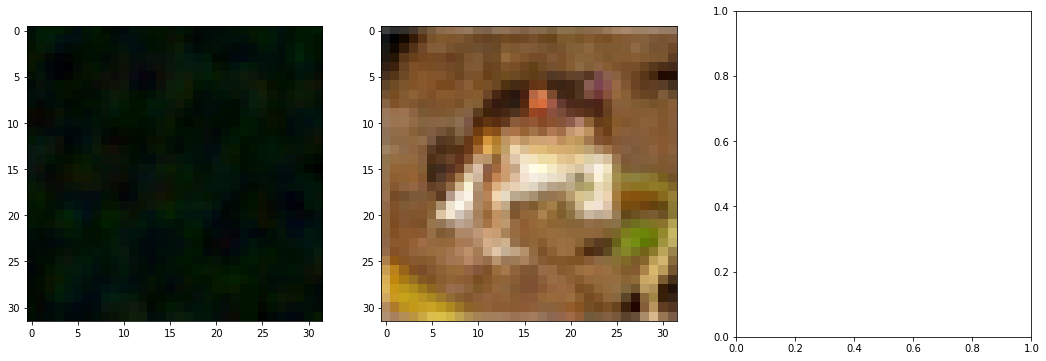

Step 50, Total loss 0.061744
tensor(0.3297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


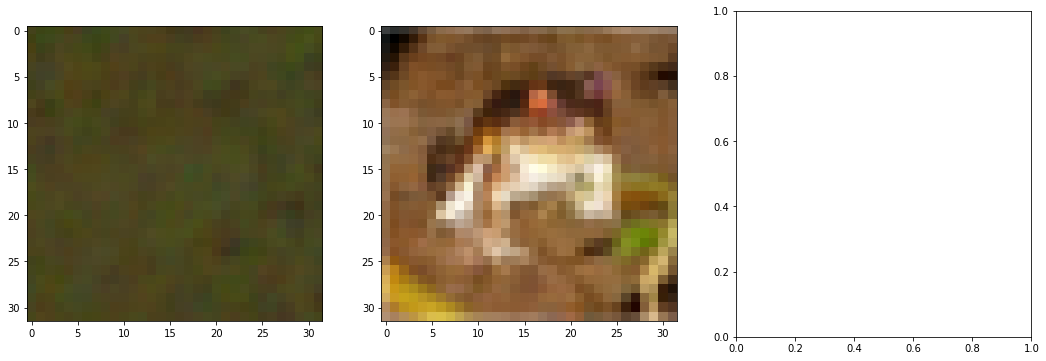

Step 100, Total loss 0.034016
tensor(0.4324, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


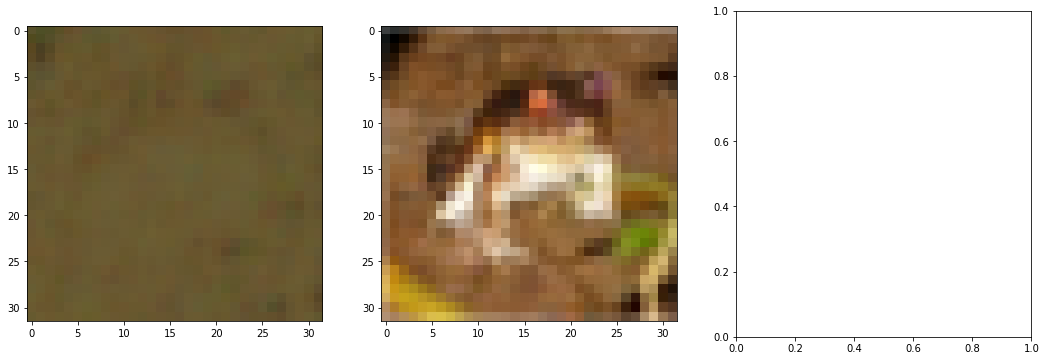

Step 150, Total loss 0.025268
tensor(0.4830, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


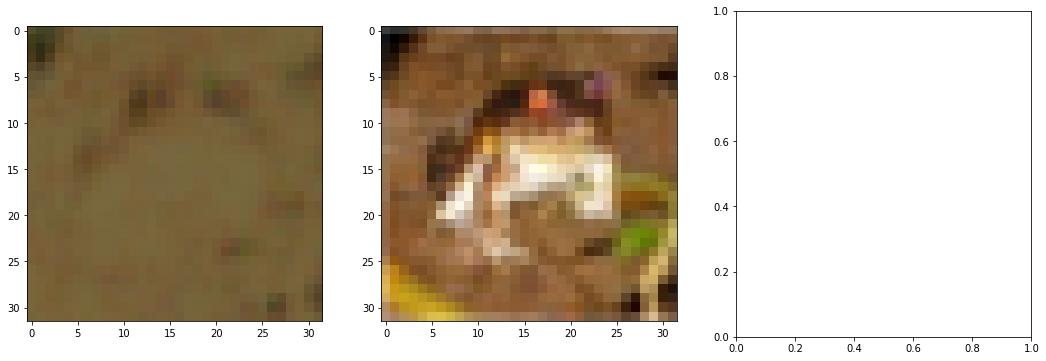

Step 200, Total loss 0.019704
tensor(0.5254, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


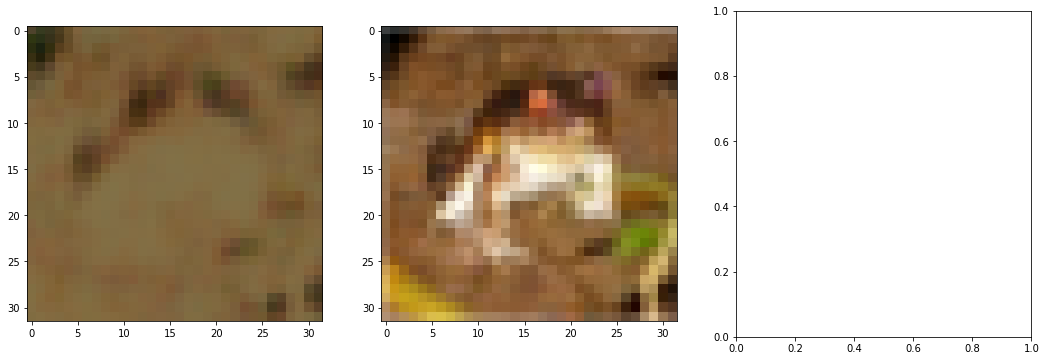

Step 250, Total loss 0.015759
tensor(0.5559, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


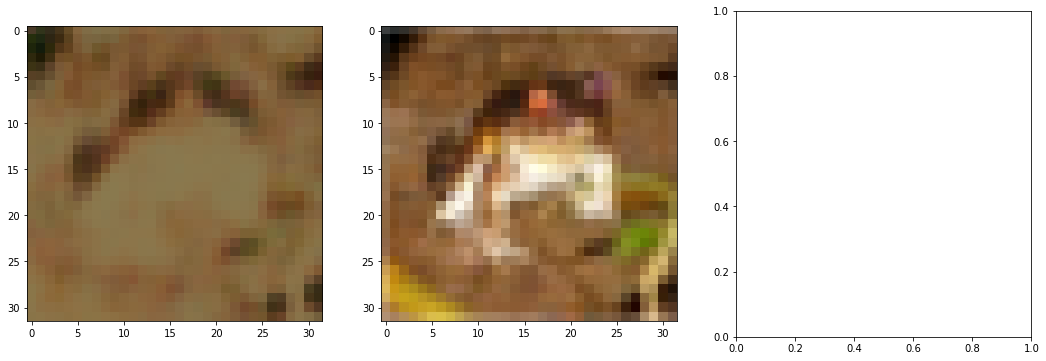

Step 300, Total loss 0.012781
tensor(0.5835, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


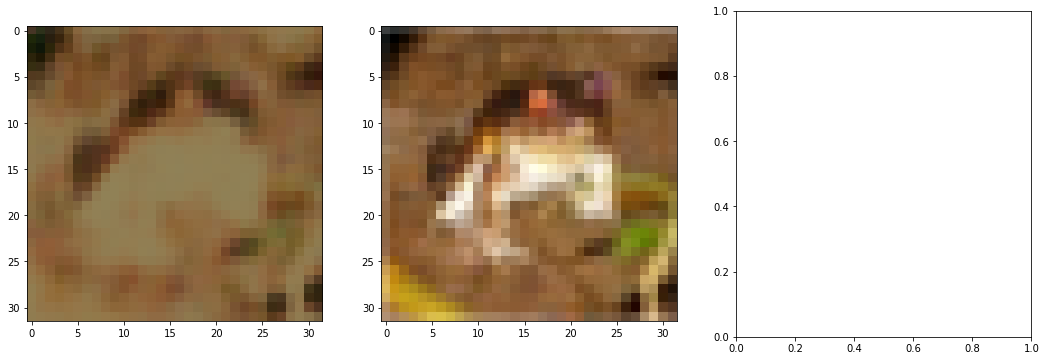

Step 350, Total loss 0.010467
tensor(0.6071, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


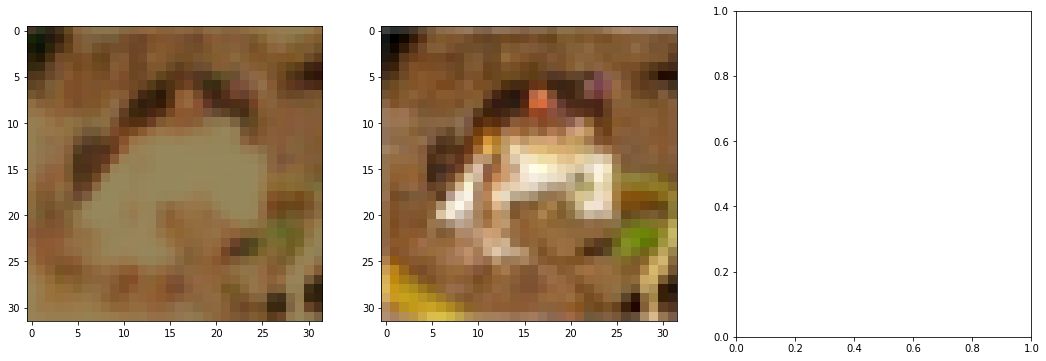

Step 400, Total loss 0.008643
tensor(0.6280, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


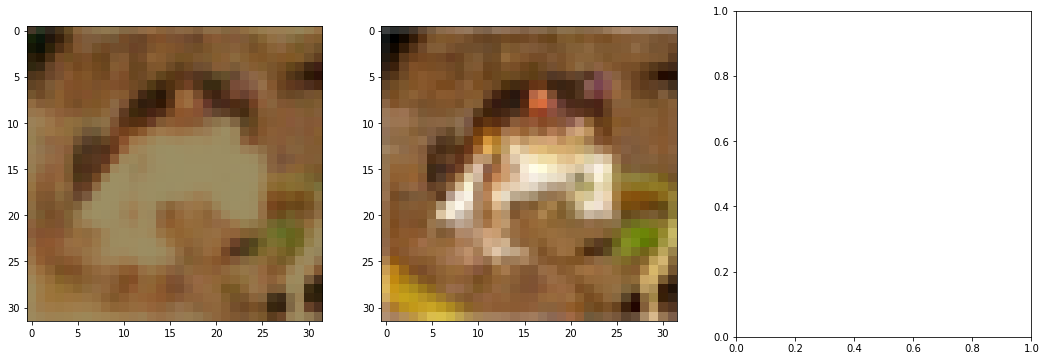

Step 450, Total loss 0.007177
tensor(0.6477, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


KeyboardInterrupt: ignored

In [33]:
total_steps = 100000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-5, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    # model_output = net({'img_sparse': ground_truth.view((1, 1, 28, 28)).cuda(), 'coords': model_input.cuda()})["model_out"]
    model_output = img_siren(model_input)
    # print(model_output.shape)
    # print(ground_truth.shape)
    loss = ((model_output.view(-1, 32 * 32 * 3, 1).cuda() - (ground_truth / 255))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        print(torch.max(model_output))
        print(torch.max(ground_truth))

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(32, 32, 3).detach().numpy())
        axes[1].imshow((ground_truth / 255).cpu().view(32, 32, 3).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

In [16]:
total_steps = 1000000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-6, params=net.hyper_net.parameters())

# model_input, ground_truth = get_mgrid(28, 2), torch.Tensor(np.array(mnist_trainset[step % len(mnist_trainset)][0])).reshape((784, 1))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    
    out = net({'embedding': ground_truth.view((1, 784)).cuda(), 'coords': model_input.cuda()})
    model_output = nn.Sigmoid()(out["model_out"])
    hypo_params = out["hypo_params"]
    all_hypo_params = torch.cat([x.view(-1) for x in list(hypo_params.values())])
    # model_output, coords = img_siren(model_input)    
    loss = ((model_output.cuda() - (ground_truth / 255))**2).mean() + 1000 * ((all_hypo_params.cuda())**2).mean()
    
    if not step % 250:
        print("Step %d, Total loss %0.6f" % (step, loss))

        print(torch.max(model_output))
        print(torch.max(ground_truth))

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(28,28).detach().numpy())
        axes[1].imshow((ground_truth / 255).cpu().view(28,28).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

NameError: ignored

In [17]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [36]:
net = ConvolutionalNeuralProcessImplicit2DHypernet(3, 3, 32)
net.cuda()

ConvolutionalNeuralProcessImplicit2DHypernet(
  (encoder): ConvImgEncoder(
    (conv_theta): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (cnn): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2dResBlock(
        (convs): Sequential(
          (0): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (3): ReLU()
        )
        (final_relu): ReLU()
      )
      (3): Conv2dResBlock(
        (convs): Sequential(
          (0): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (3): ReLU()
        )
        (final_relu): ReLU()
      )
      (4): Conv2dResBlock(
        (convs): Sequential(
        

In [37]:
class CIFARSirenDataset(torch.utils.data.Dataset):
    def __init__(self, trainCIFAR):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trainCIFAR = trainCIFAR

    def __len__(self):
        return len(self.trainCIFAR)

    def __getitem__(self, idx):
        image = torch.Tensor(np.array(self.trainCIFAR[idx][0])).reshape((32 * 32 * 3, 1))
        coord = get_mgrid(32, 2)

        return image, coord

In [38]:
loader = DataLoader(CIFARSirenDataset(cifar_trainset), batch_size=16, shuffle=True)

Step 0, Total loss 0.007006
tensor(1.1289, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


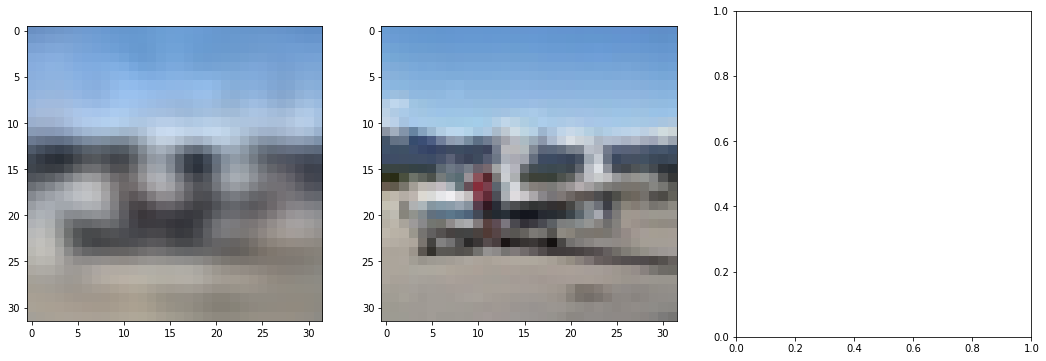

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.009722
tensor(1.1618, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


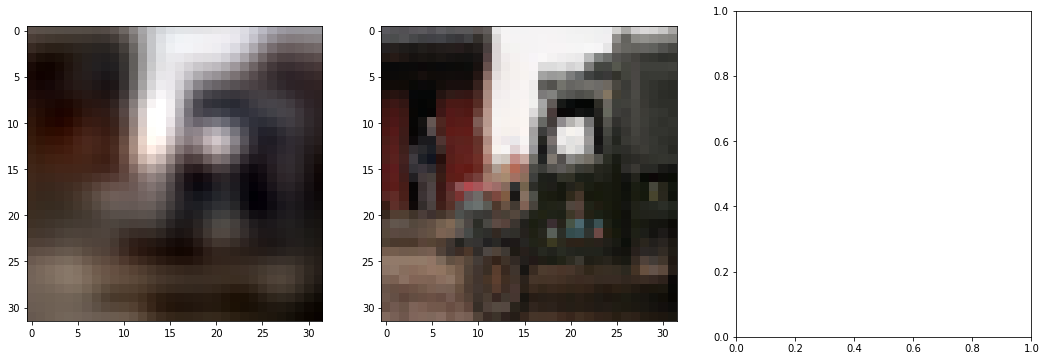

Step 500, Total loss 0.006506
tensor(1.1300, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


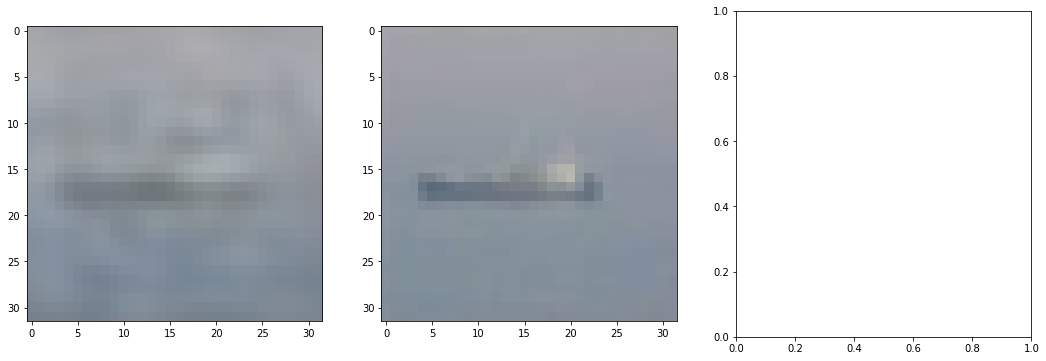

Step 750, Total loss 0.006694
tensor(1.1152, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


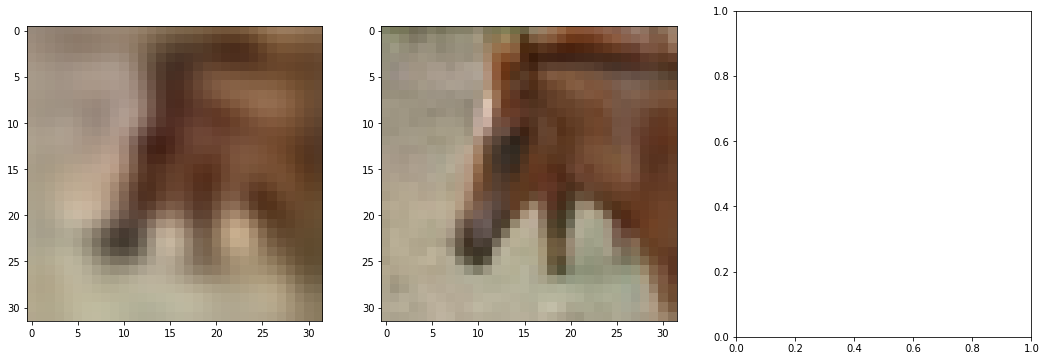

Step 1000, Total loss 0.007115
tensor(1.1218, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


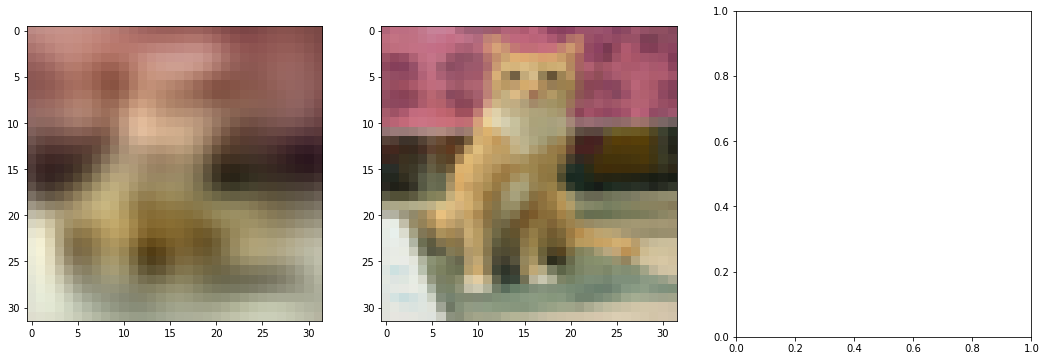

Step 1250, Total loss 0.005550
tensor(1.1740, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


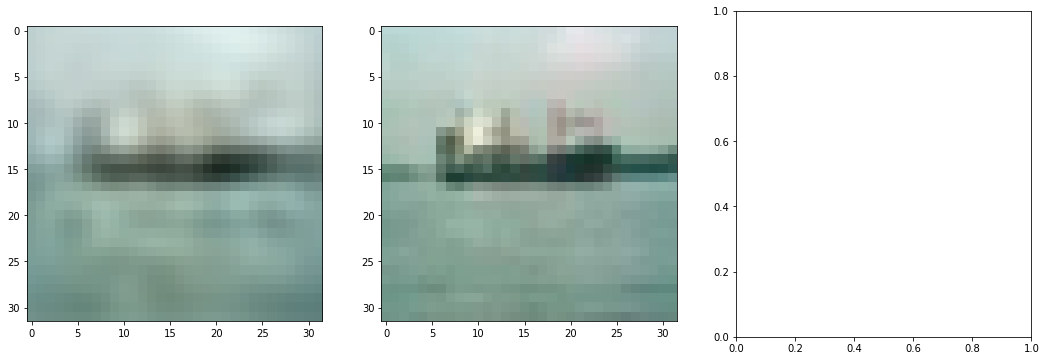

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006694
tensor(1.1196, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


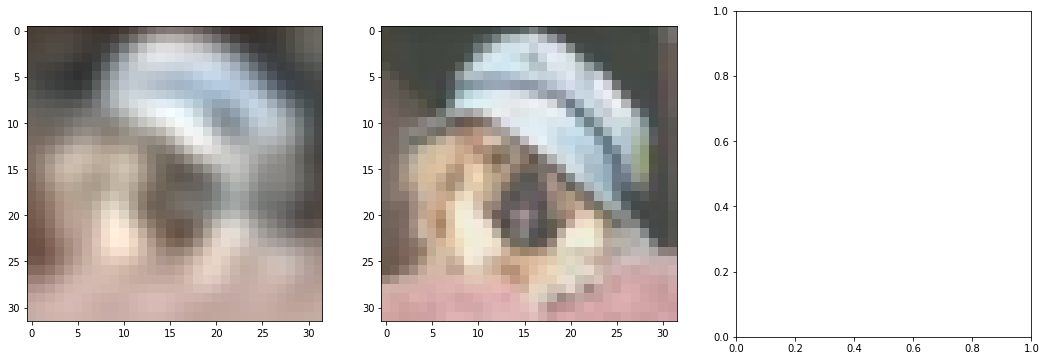

Step 1750, Total loss 0.007681
tensor(1.1399, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


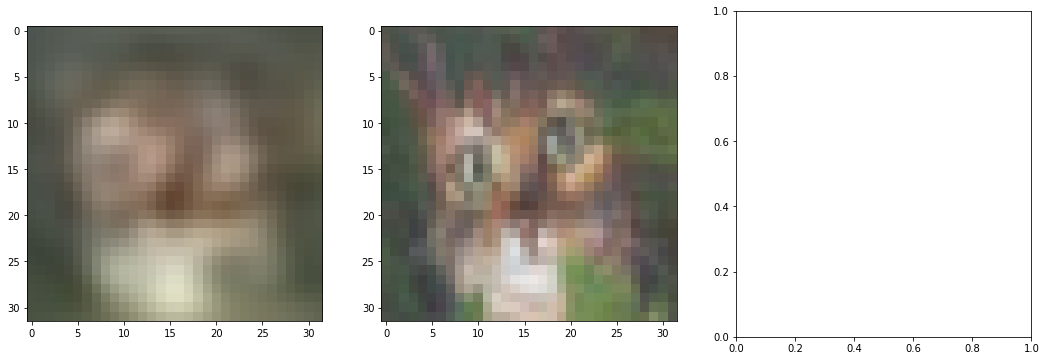

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006584
tensor(1.0936, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


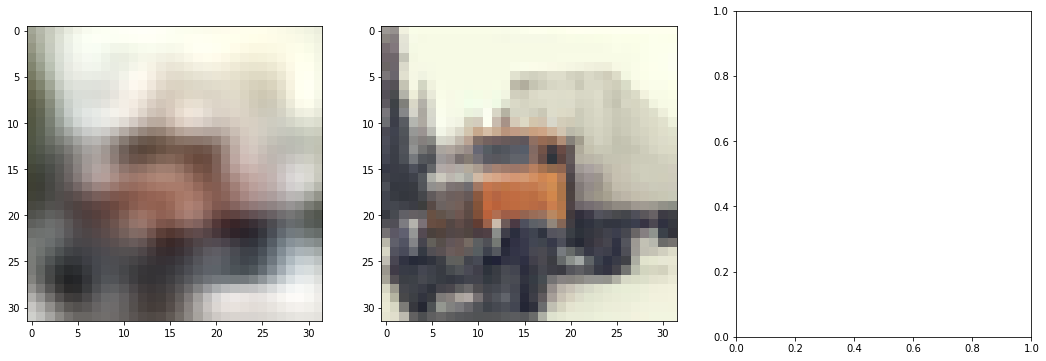

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006281
tensor(1.1060, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


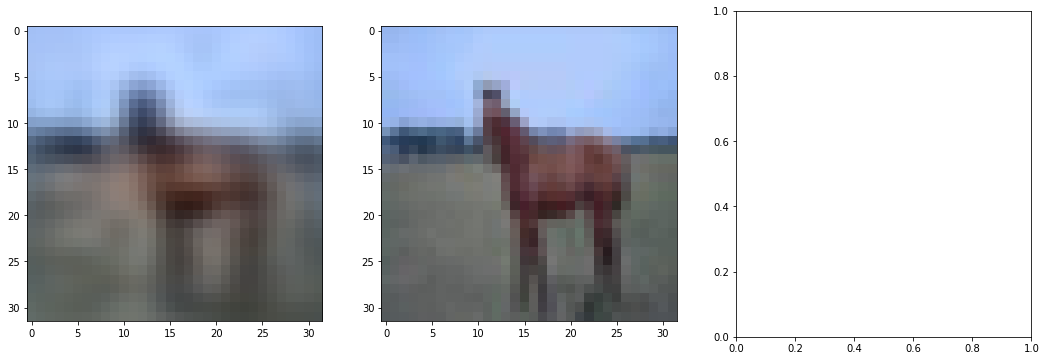

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.007075
tensor(1.0477, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


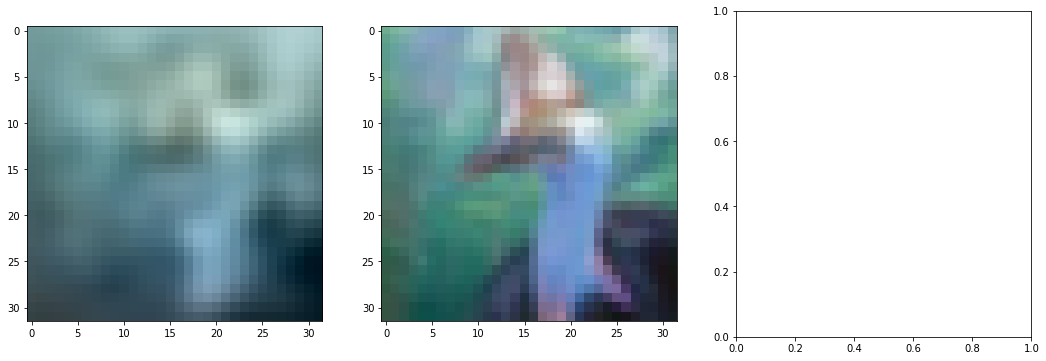

Step 2750, Total loss 0.007234
tensor(1.0861, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


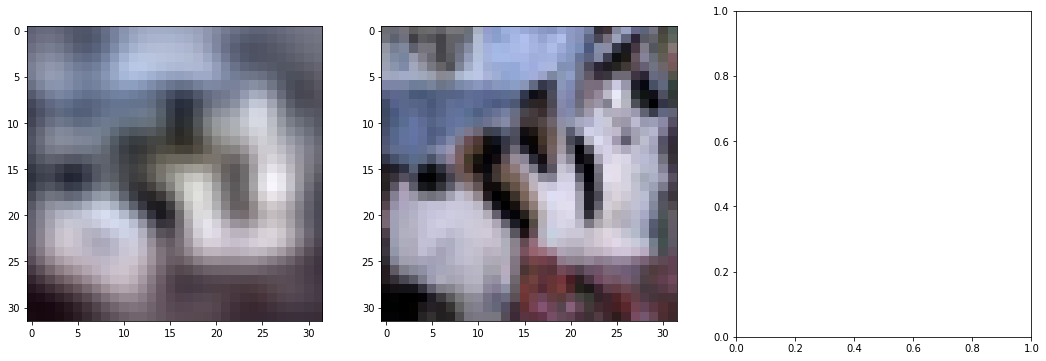

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.007248
tensor(1.1365, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


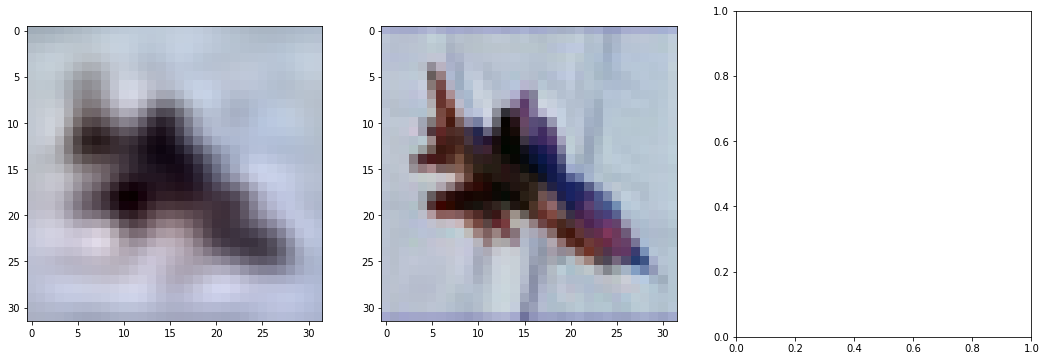

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.006345
tensor(1.2032, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


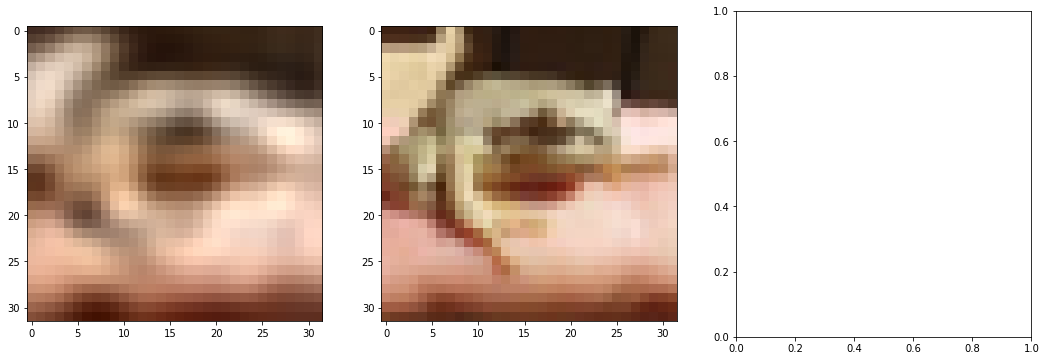

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006485
tensor(1.1926, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


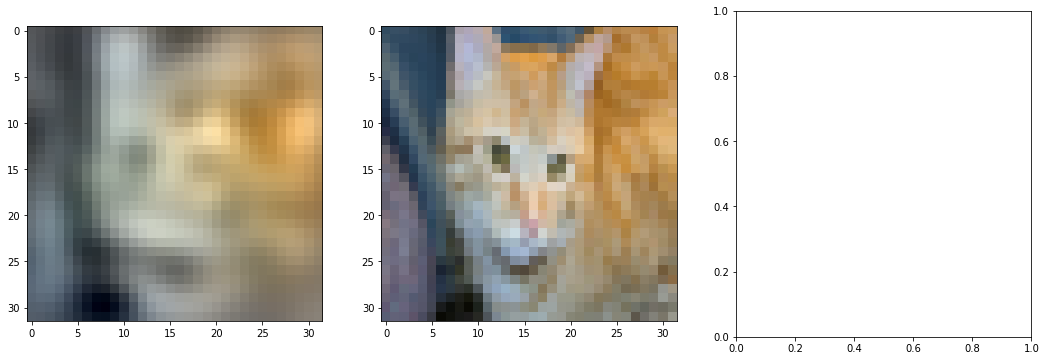

Step 500, Total loss 0.007619
tensor(1.0346, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


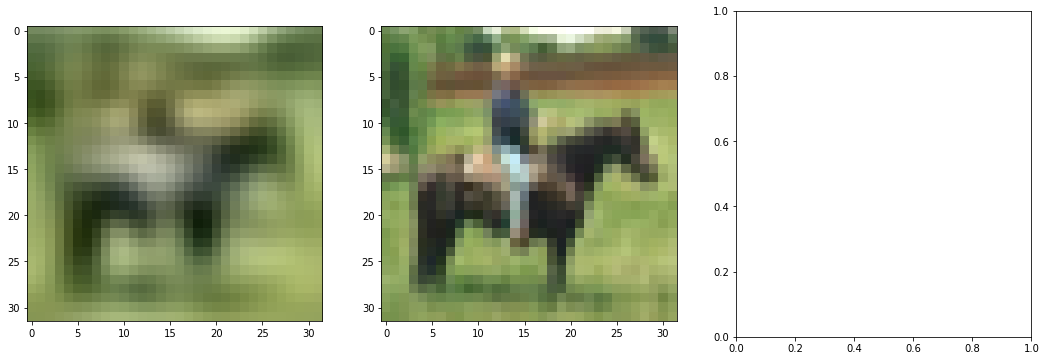

Step 750, Total loss 0.008716
tensor(1.1173, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


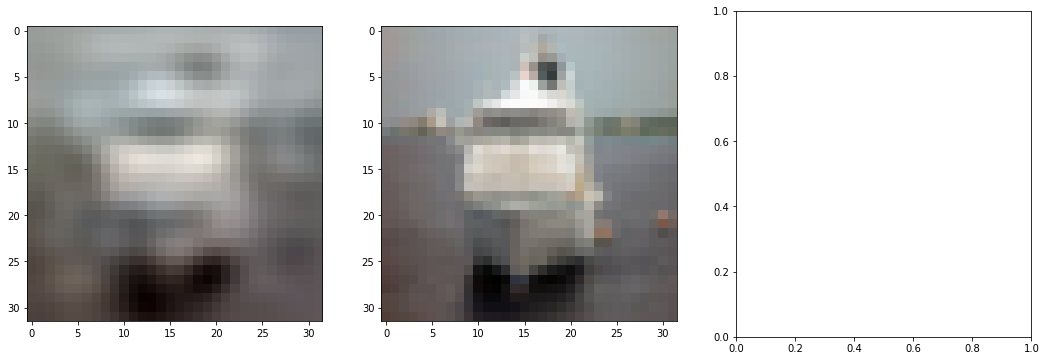

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006832
tensor(1.1620, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


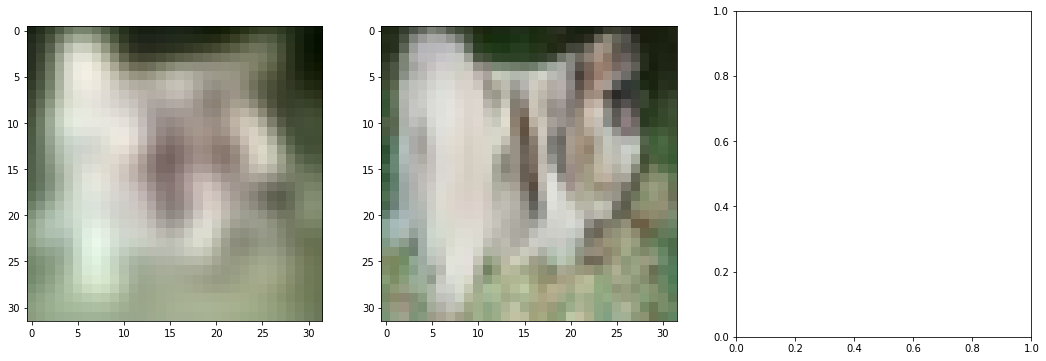

Step 1250, Total loss 0.006819
tensor(1.1520, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


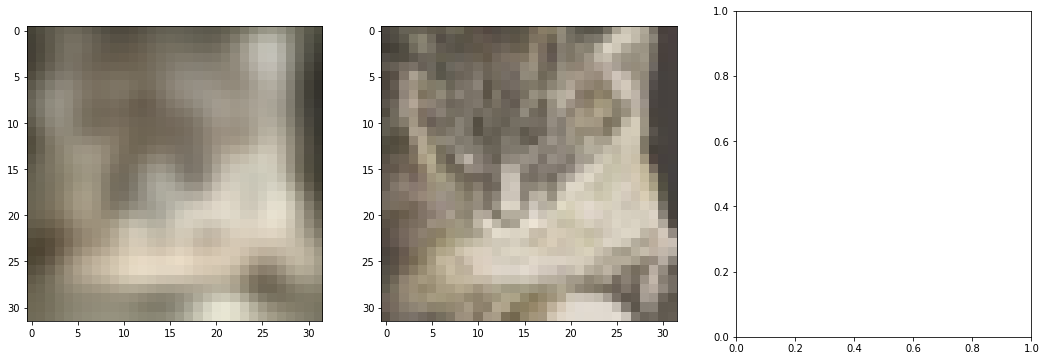

Step 1500, Total loss 0.007047
tensor(1.1277, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


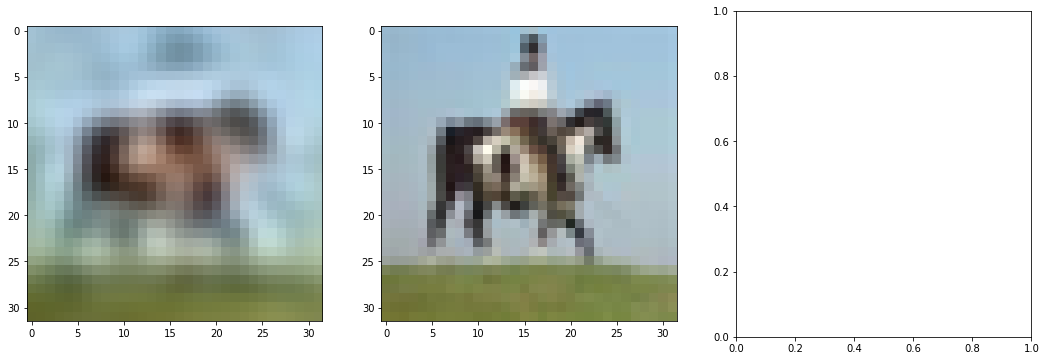

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006769
tensor(1.1122, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


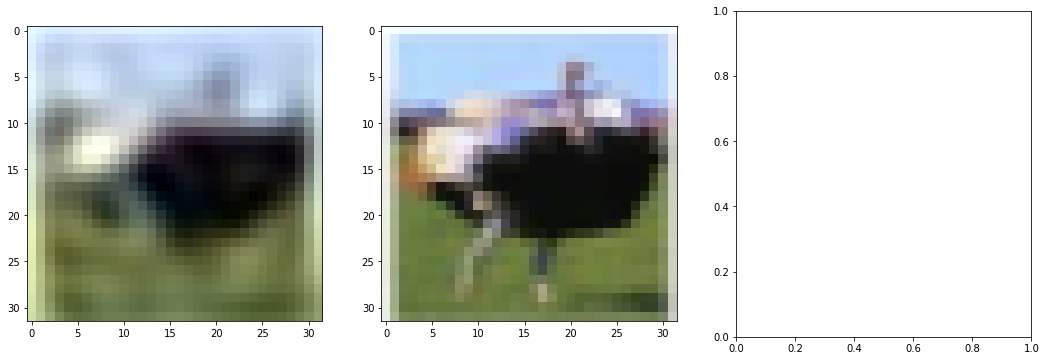

Step 2000, Total loss 0.008001
tensor(1.1338, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


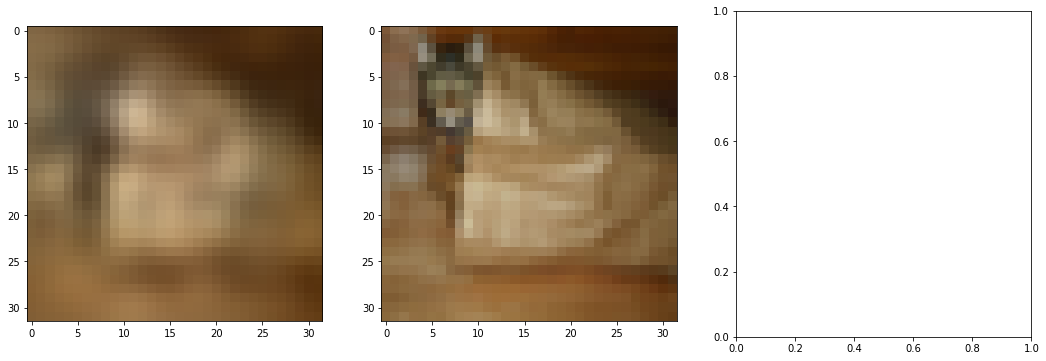

Step 2250, Total loss 0.007066
tensor(1.1535, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


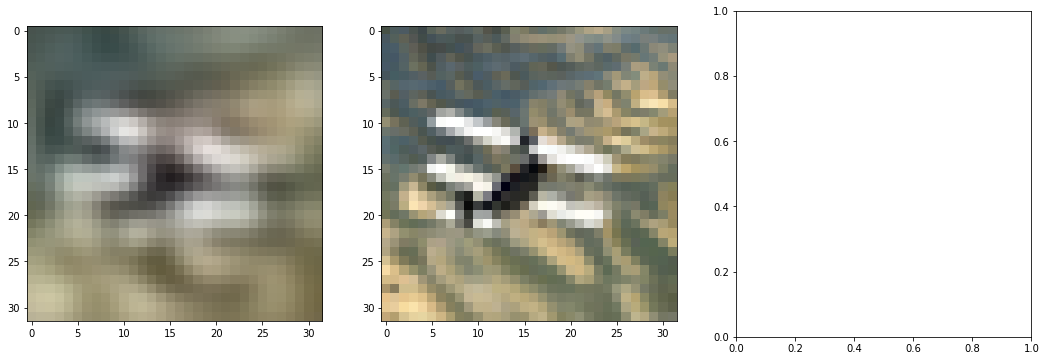

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.008316
tensor(1.1917, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


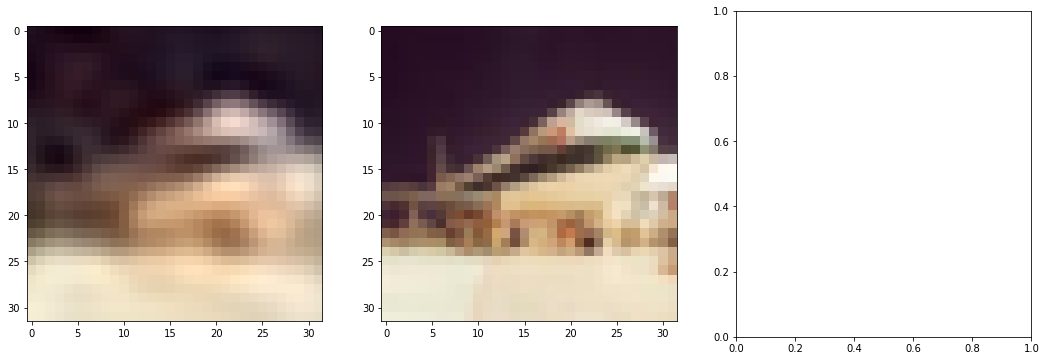

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.009166
tensor(1.1417, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


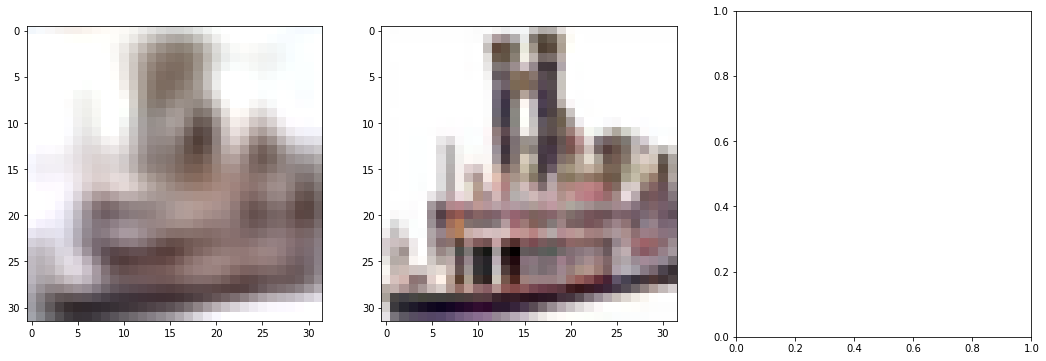

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.008187
tensor(1.0915, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


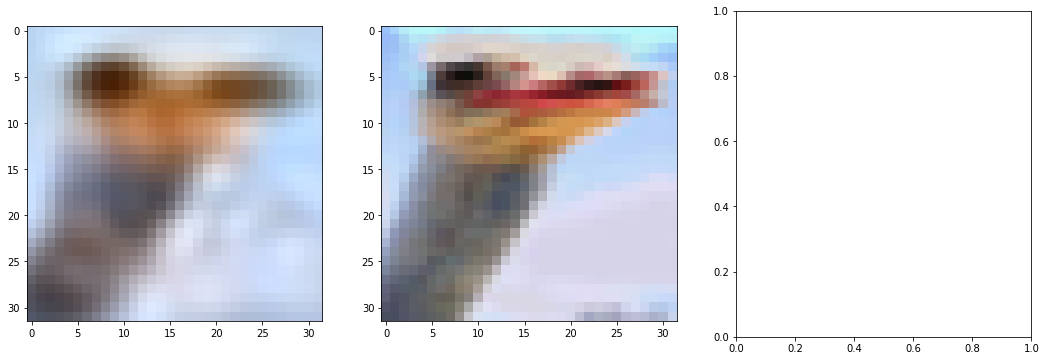

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.007948
tensor(1.1163, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


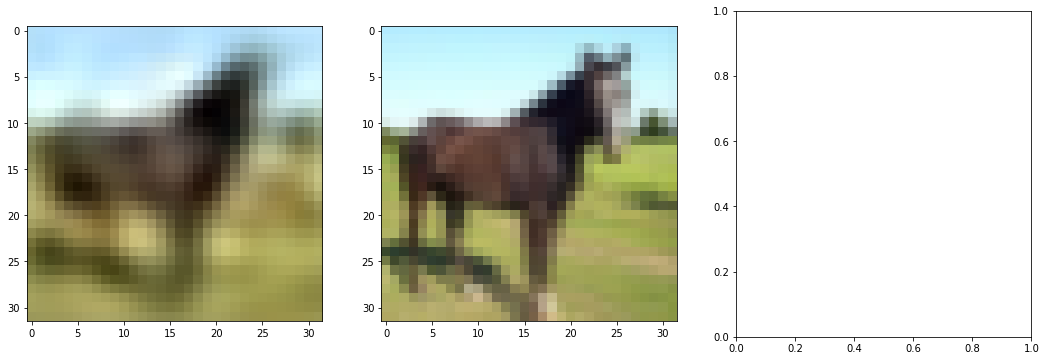

Step 250, Total loss 0.007380
tensor(1.1276, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


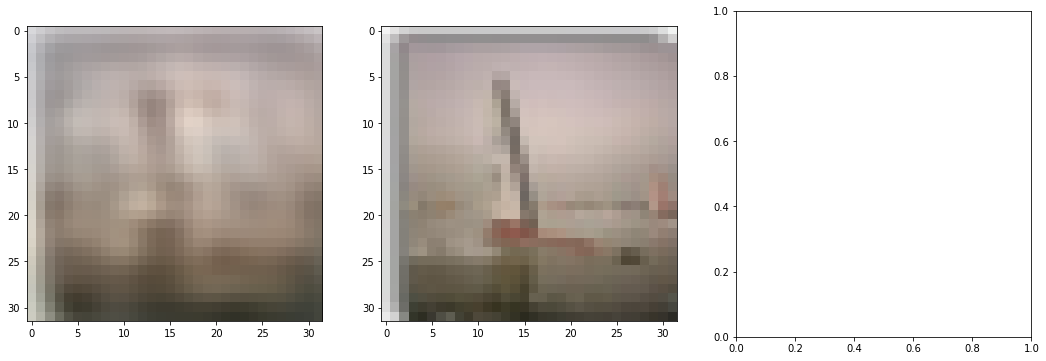

Step 500, Total loss 0.006642
tensor(1.0612, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


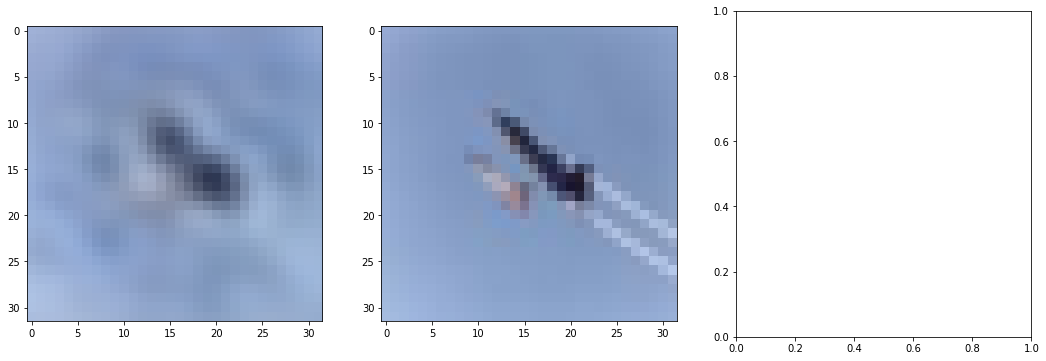

Step 750, Total loss 0.007860
tensor(1.1211, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


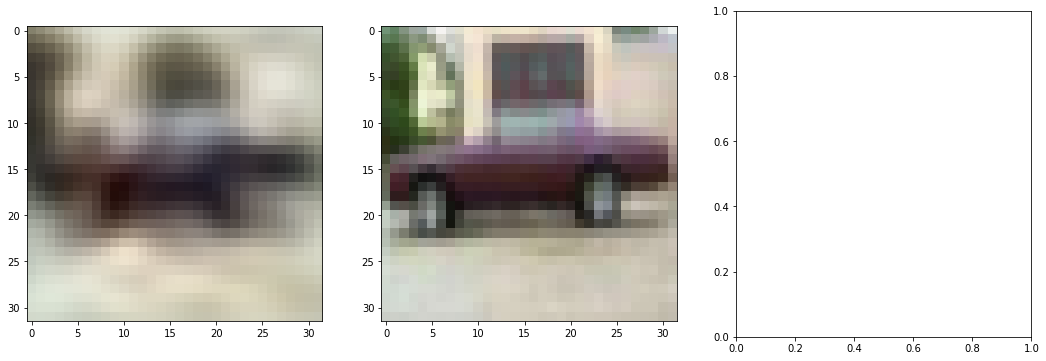

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006833
tensor(1.0945, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


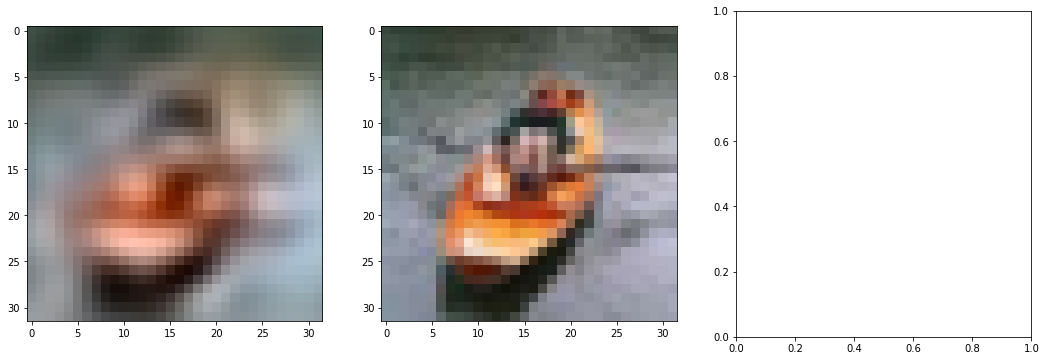

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.006701
tensor(1.0633, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


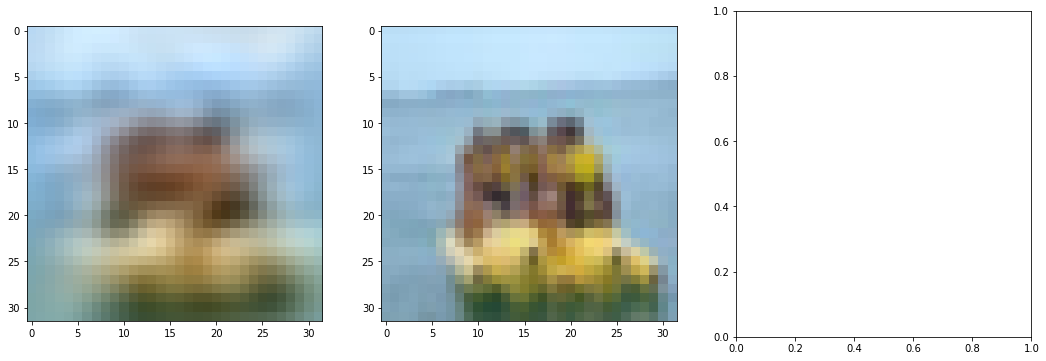

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.007229
tensor(1.1427, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


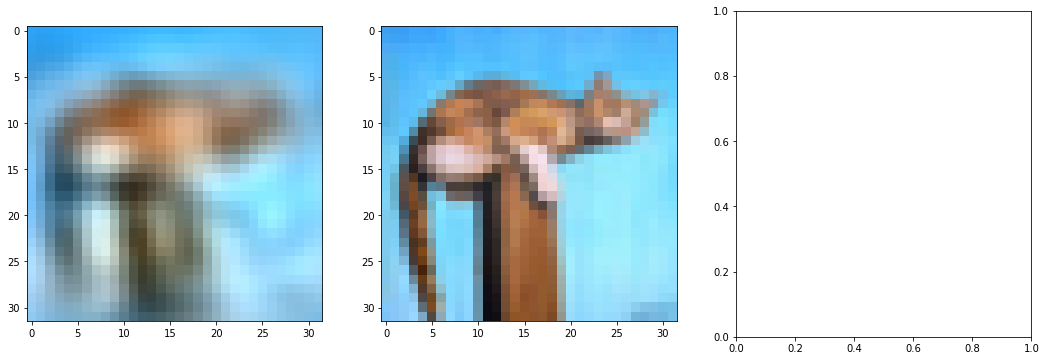

Step 1750, Total loss 0.007979
tensor(1.1565, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


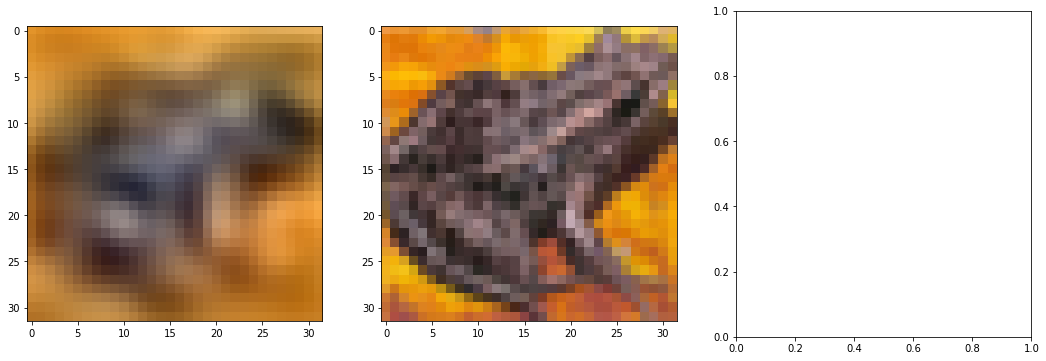

Step 2000, Total loss 0.006788
tensor(1.0903, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


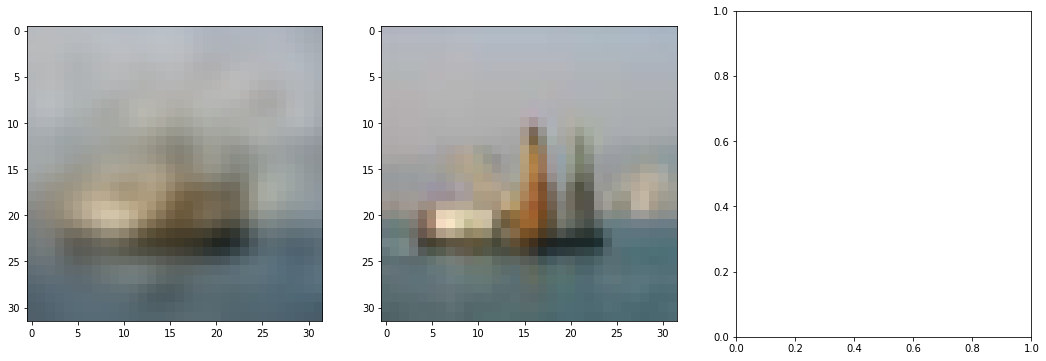

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.007045
tensor(1.0784, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


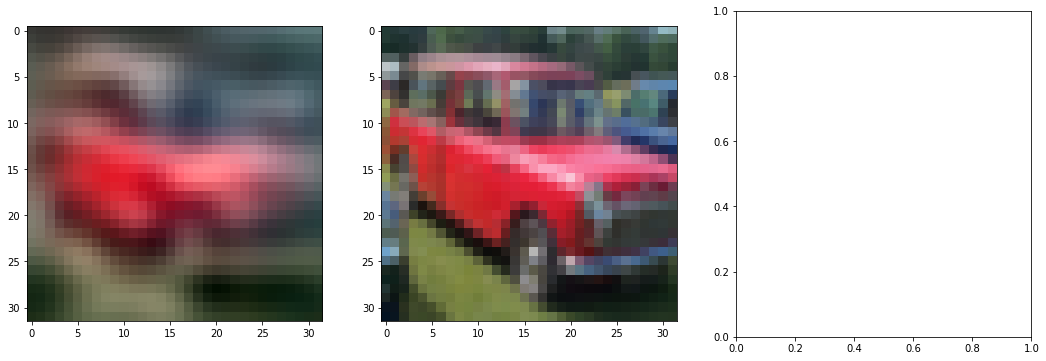

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.007236
tensor(1.1199, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


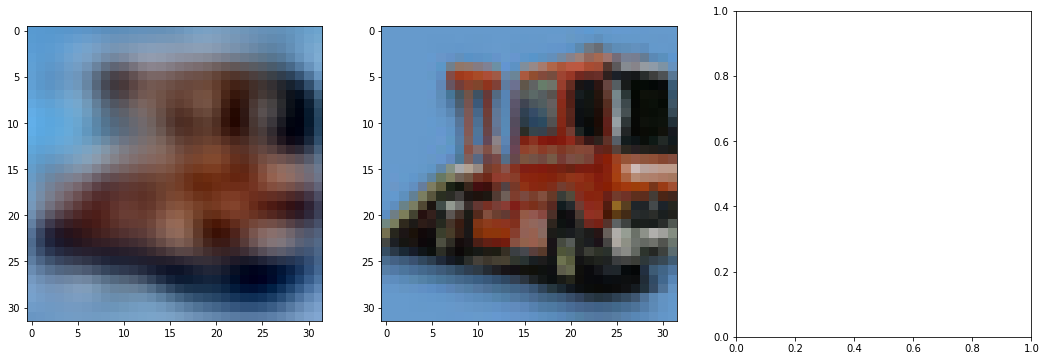

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.007498
tensor(1.1334, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


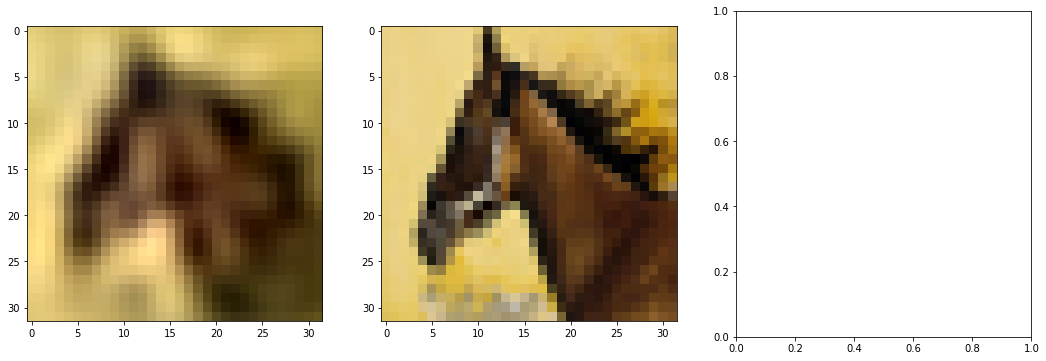

Step 3000, Total loss 0.006600
tensor(1.1181, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


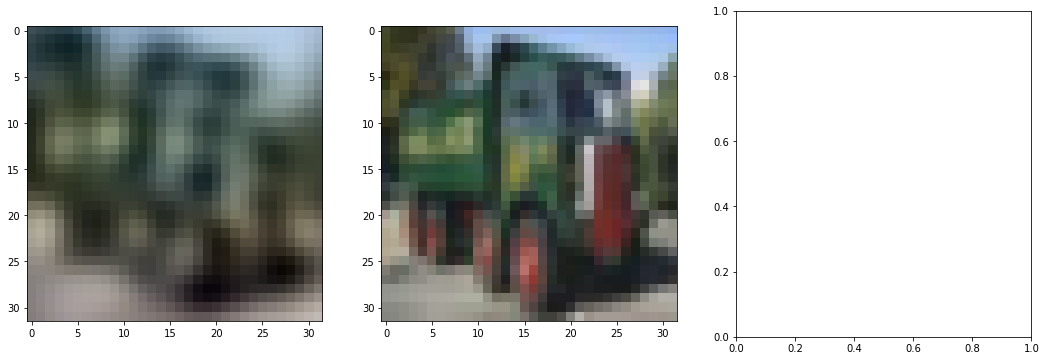

Step 0, Total loss 0.006778
tensor(1.1494, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


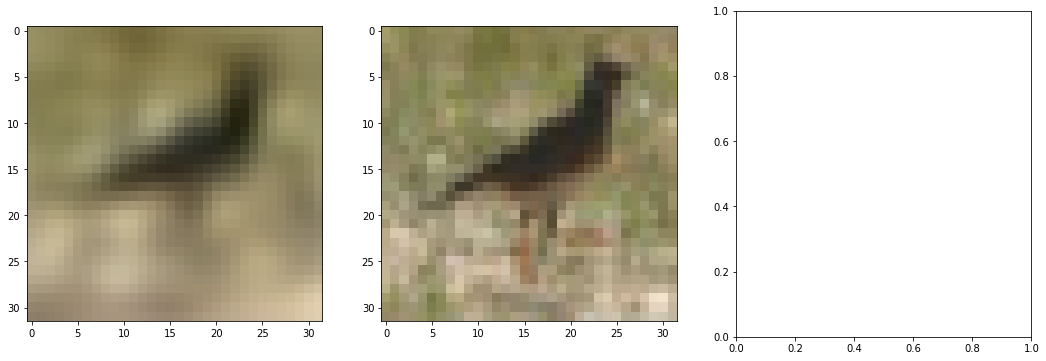

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006325
tensor(1.0846, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


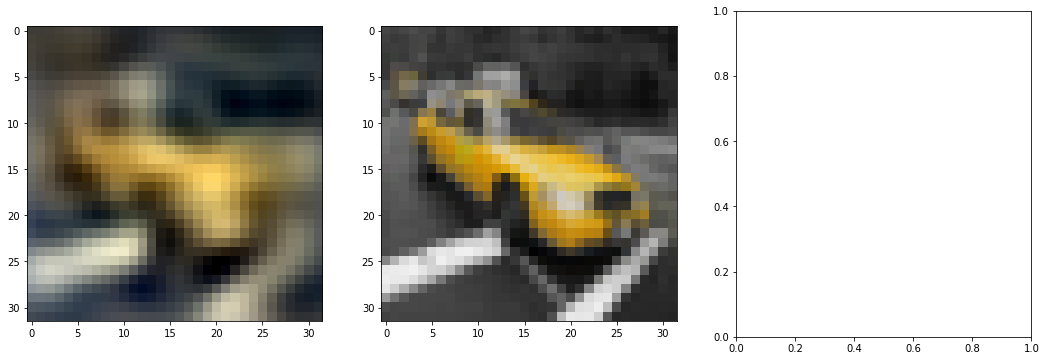

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006029
tensor(1.0904, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


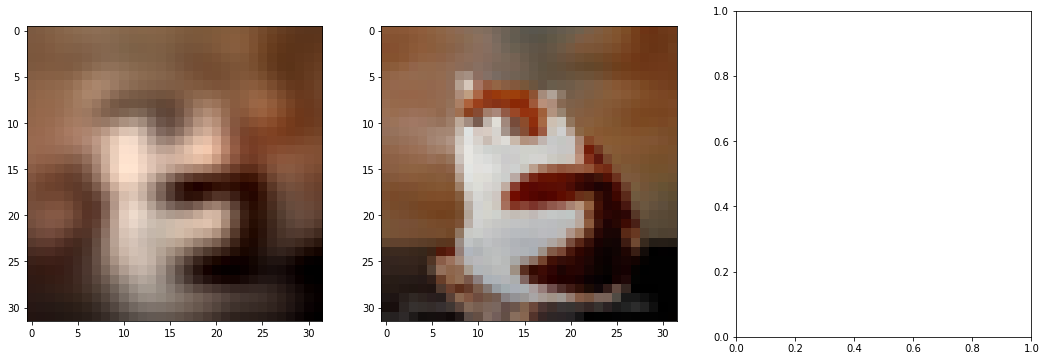

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.006827
tensor(1.0809, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


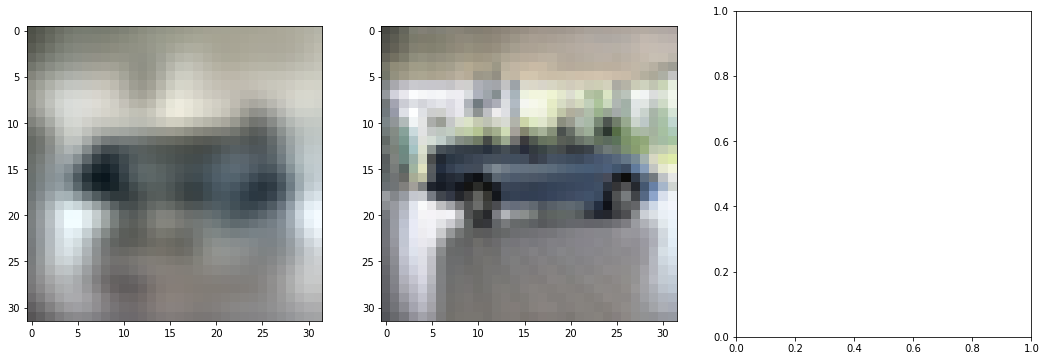

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.008327
tensor(1.0955, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


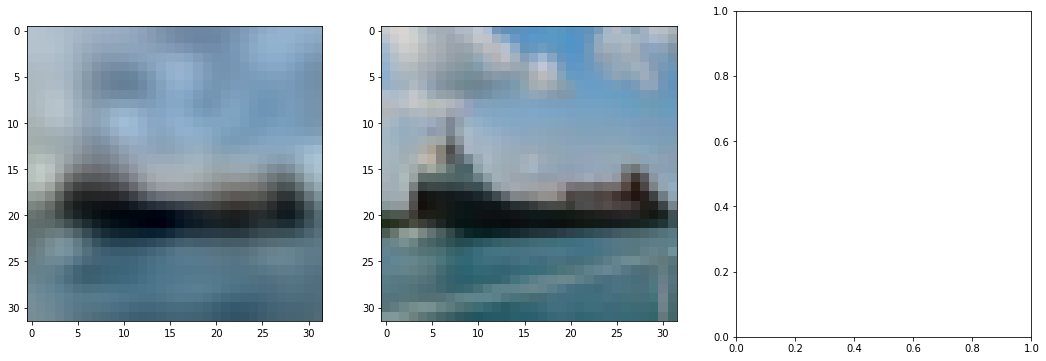

Step 1250, Total loss 0.006750
tensor(1.0620, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


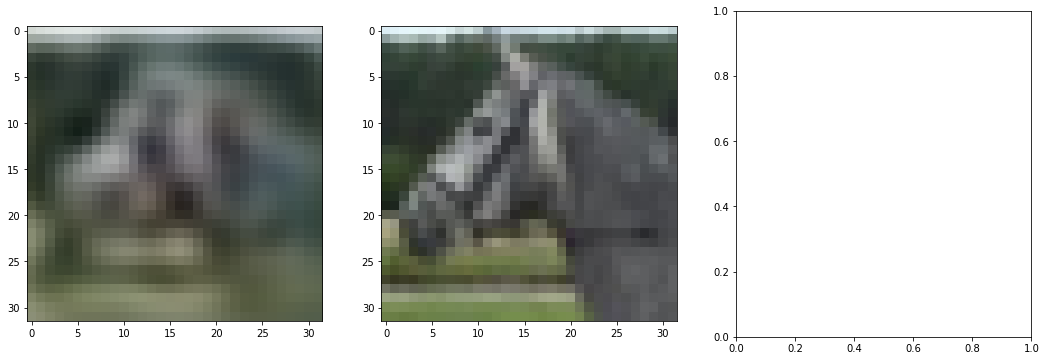

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006231
tensor(1.1071, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


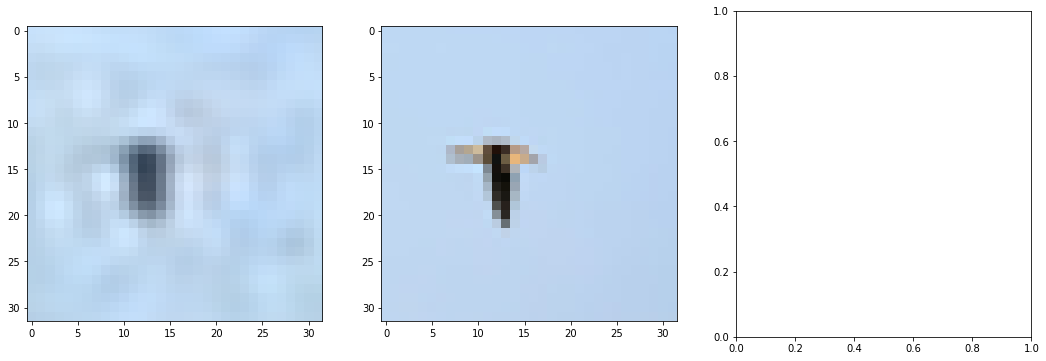

Step 1750, Total loss 0.006572
tensor(1.0991, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


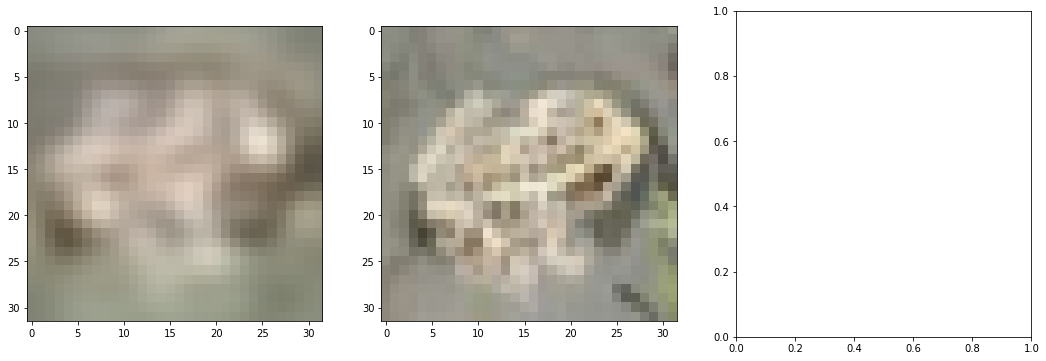

Step 2000, Total loss 0.006554
tensor(1.1332, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


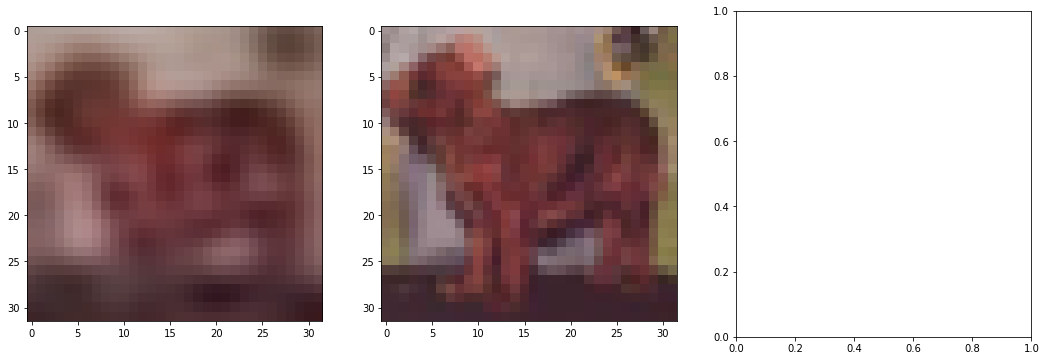

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.005911
tensor(1.0904, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


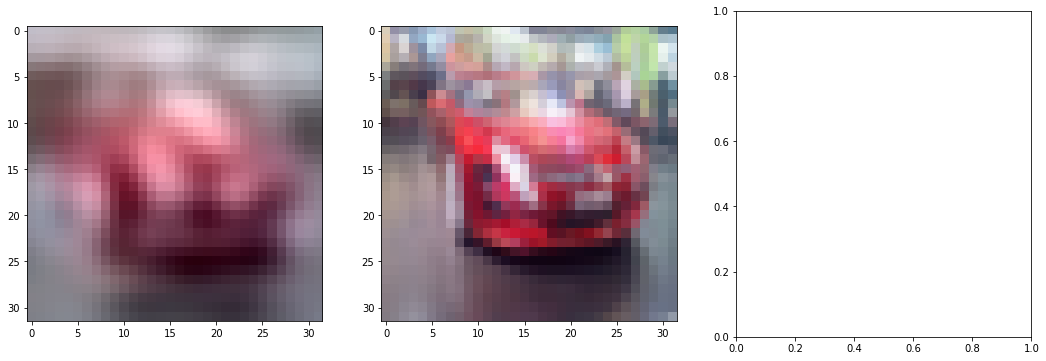

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.007512
tensor(1.1407, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


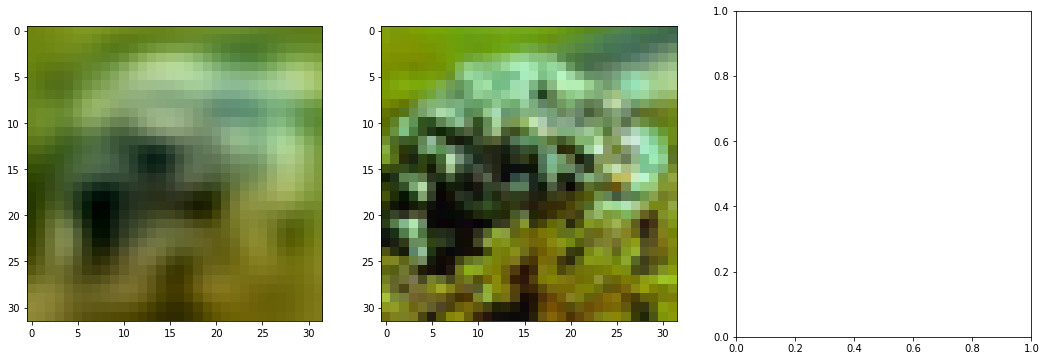

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.007629
tensor(1.1877, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


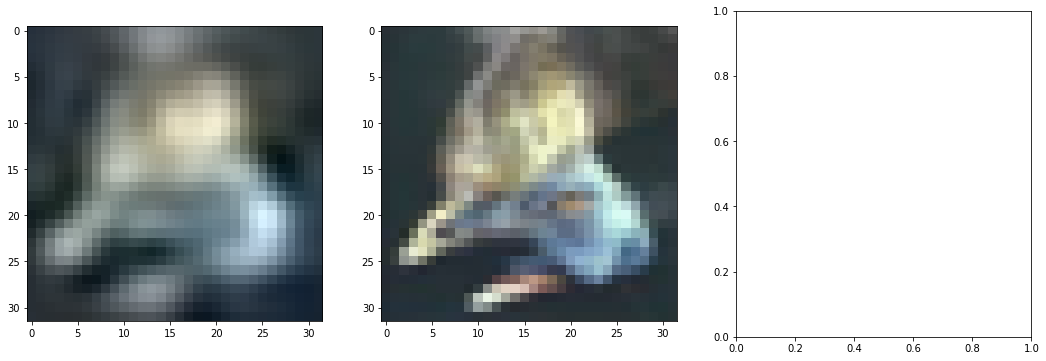

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.007437
tensor(1.1318, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


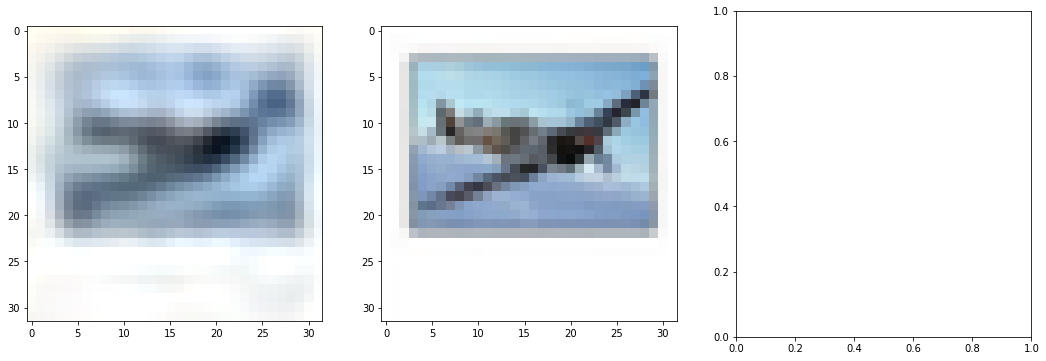

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.006901
tensor(1.1079, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


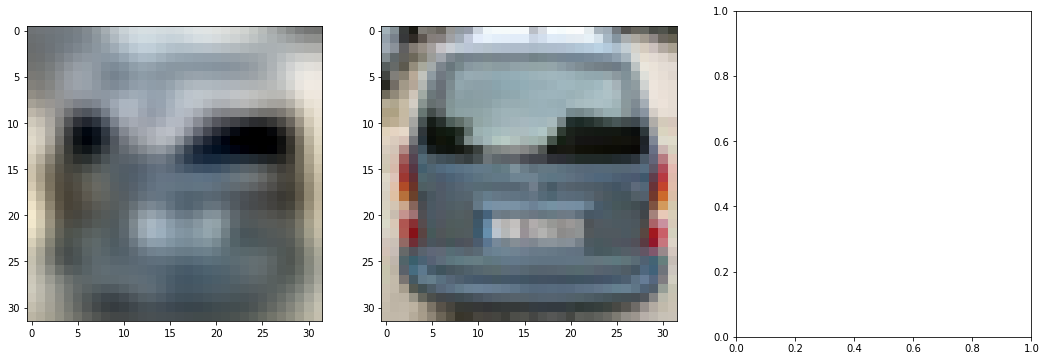

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.007220
tensor(1.1174, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


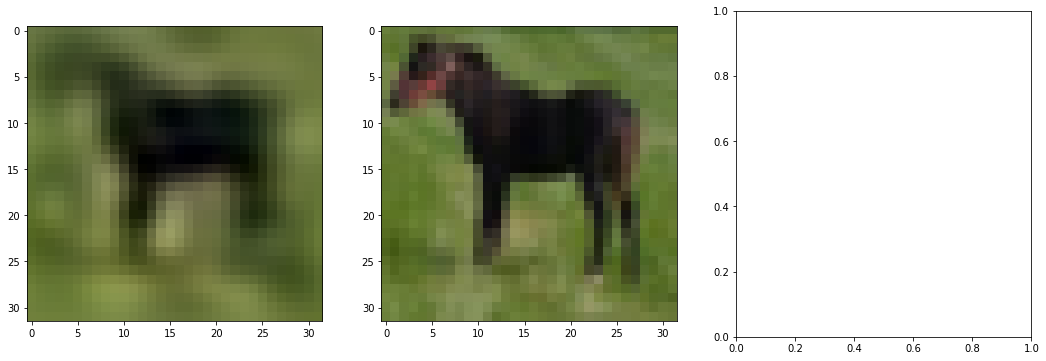

Step 500, Total loss 0.007875
tensor(1.1611, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


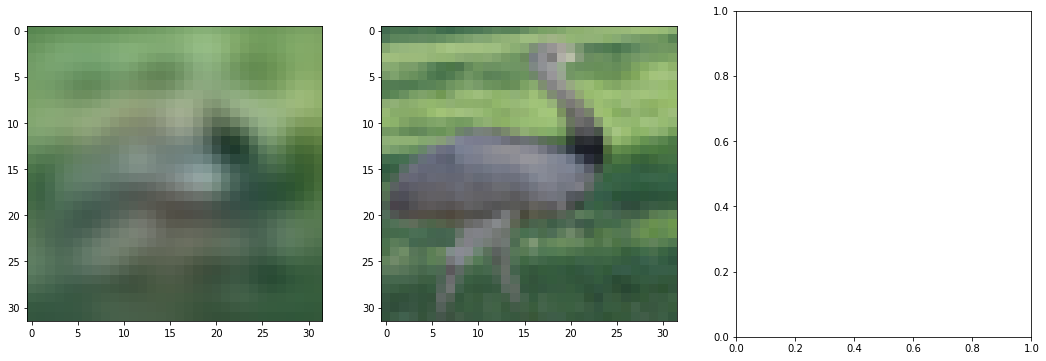

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.008090
tensor(1.2709, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


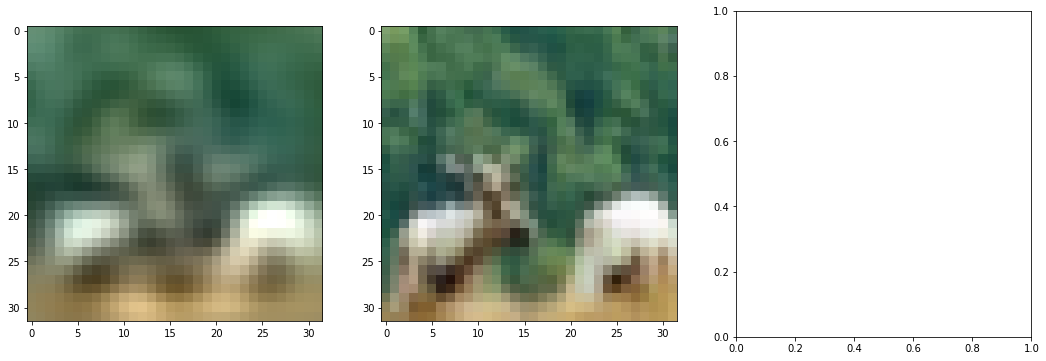

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.007150
tensor(1.1403, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


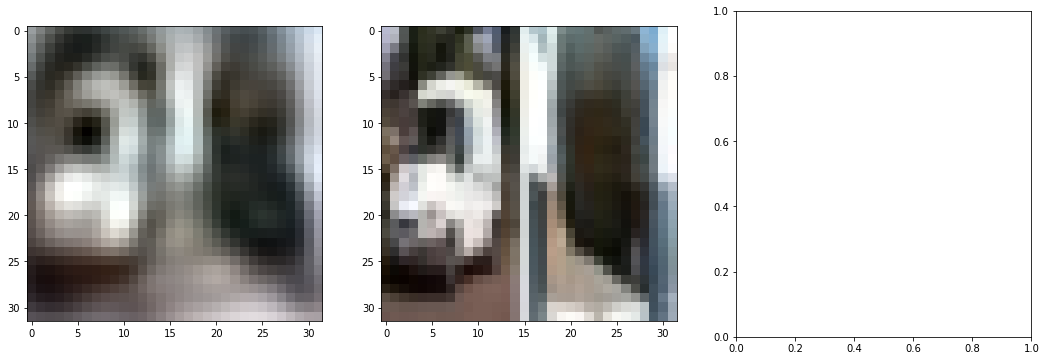

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.007337
tensor(1.1273, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


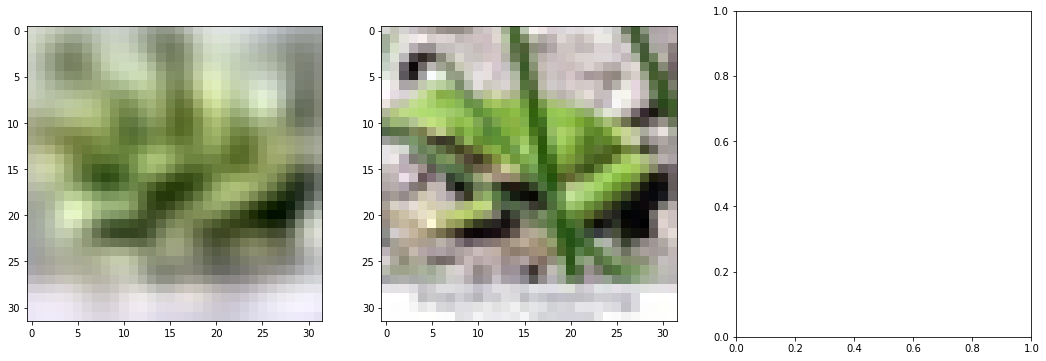

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006725
tensor(1.1732, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


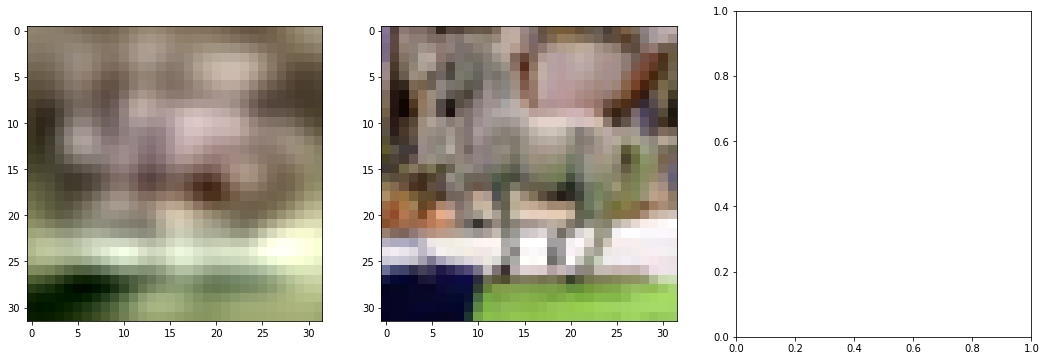

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.007566
tensor(1.0773, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


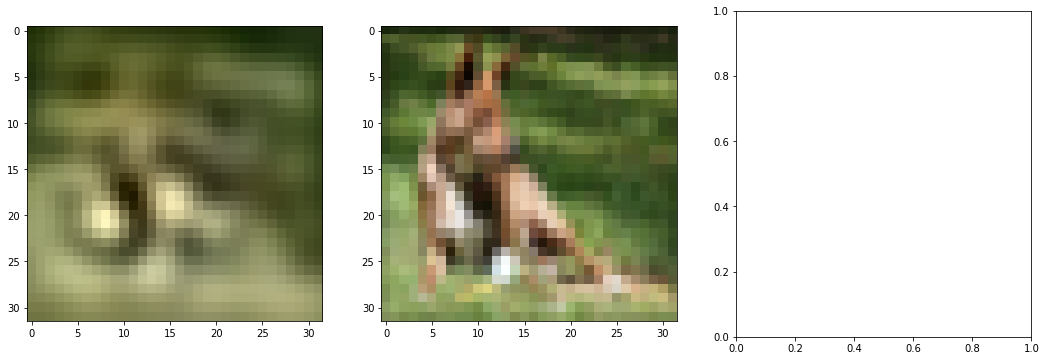

Step 2000, Total loss 0.006916
tensor(1.0891, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


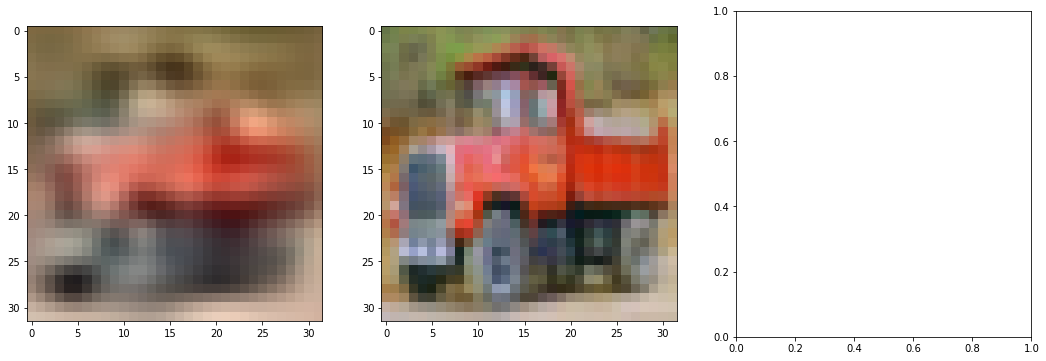

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006294
tensor(1.0600, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


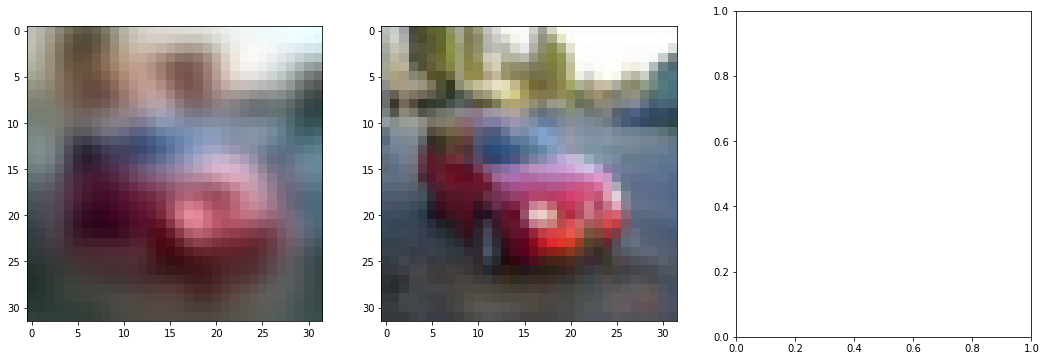

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.006208
tensor(1.0754, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


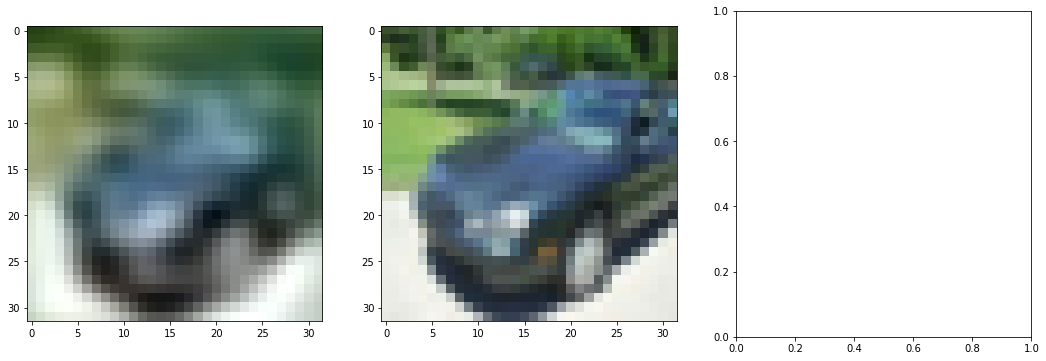

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.008002
tensor(1.1015, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


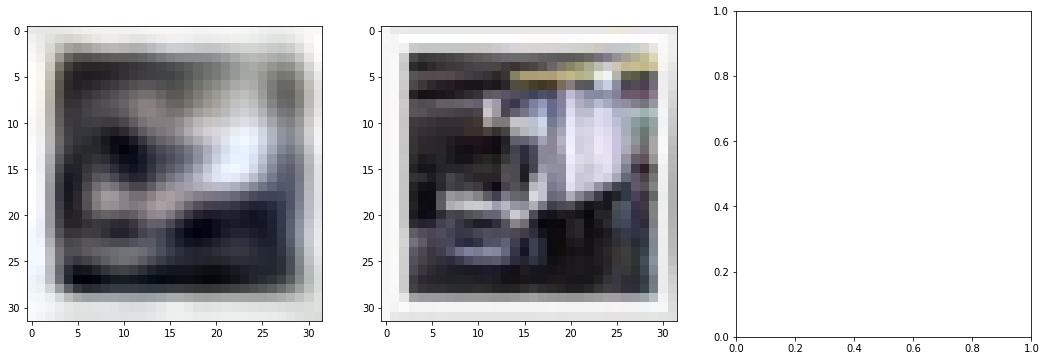

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.009036
tensor(1.1269, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


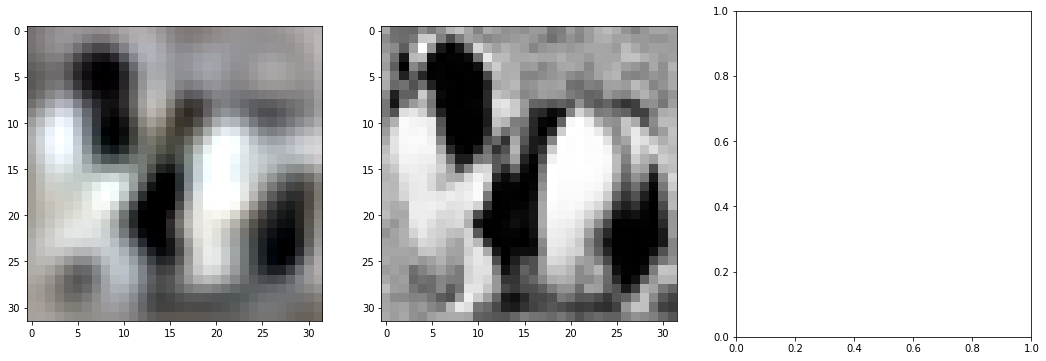

Step 0, Total loss 0.006580
tensor(1.0691, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


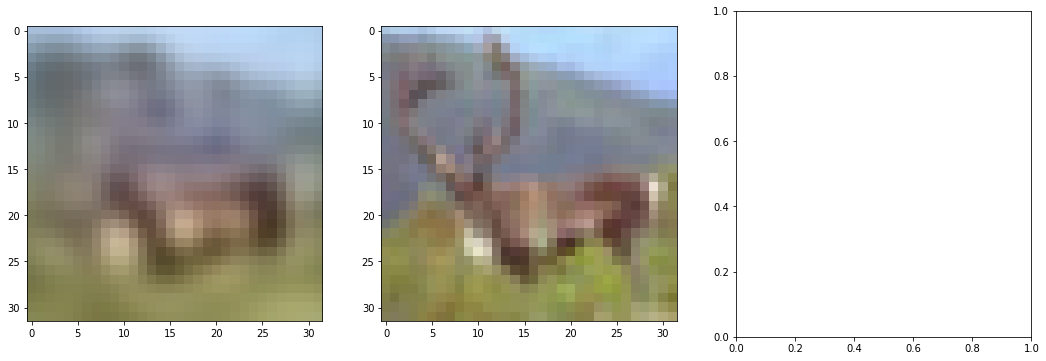

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.007118
tensor(1.1411, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


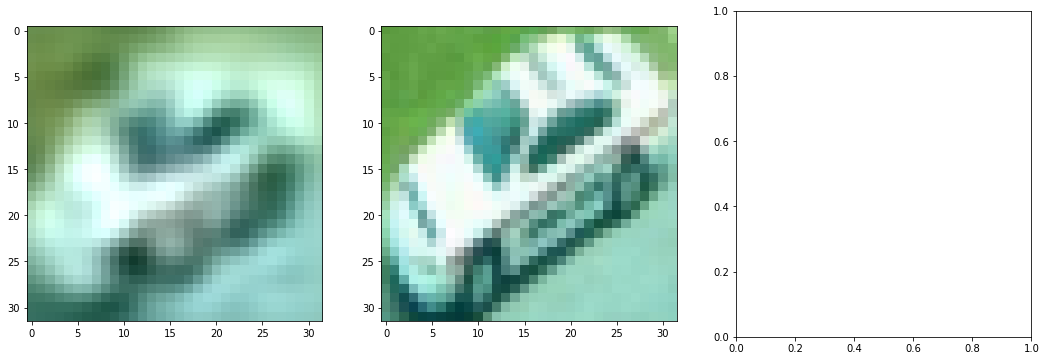

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.005868
tensor(1.0766, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


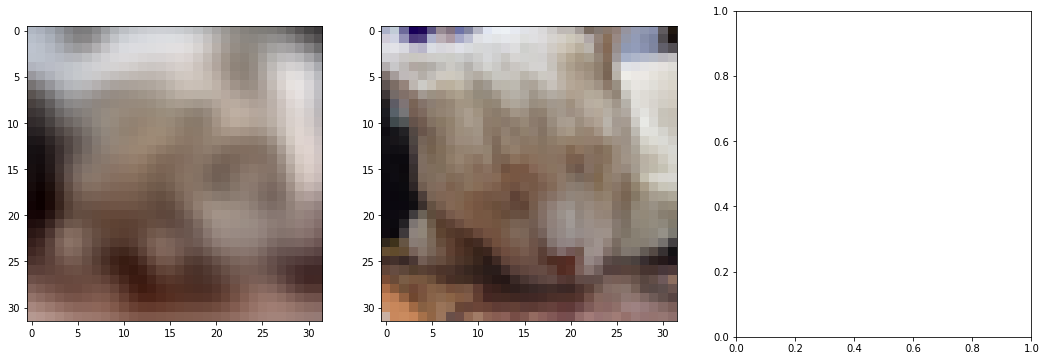

Step 750, Total loss 0.007933
tensor(1.0749, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


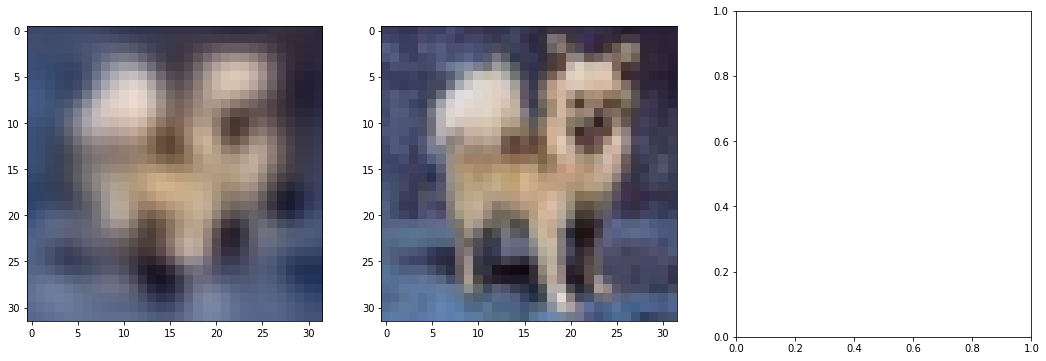

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.008281
tensor(1.2003, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


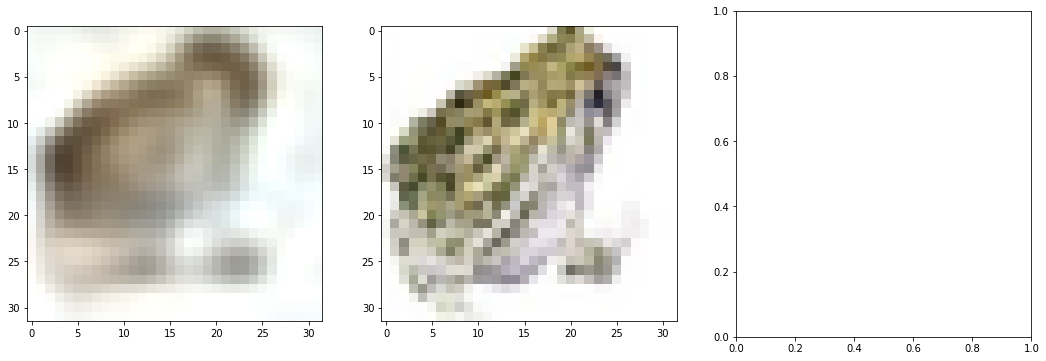

Step 1250, Total loss 0.006816
tensor(1.1516, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


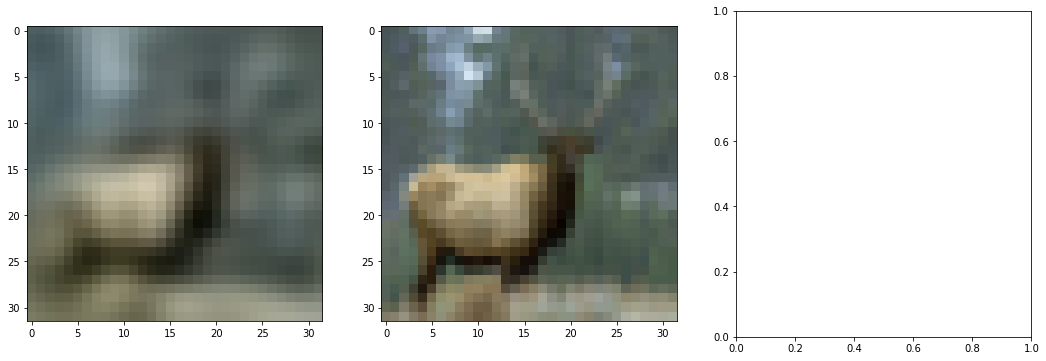

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006561
tensor(1.1317, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


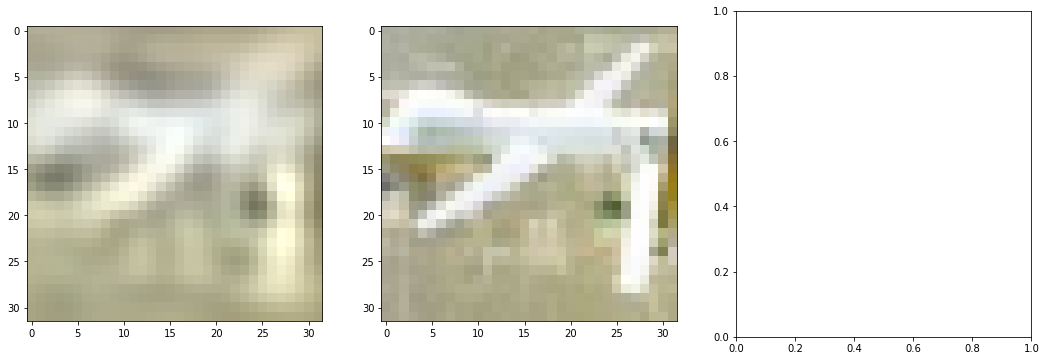

Step 1750, Total loss 0.006258
tensor(1.1333, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


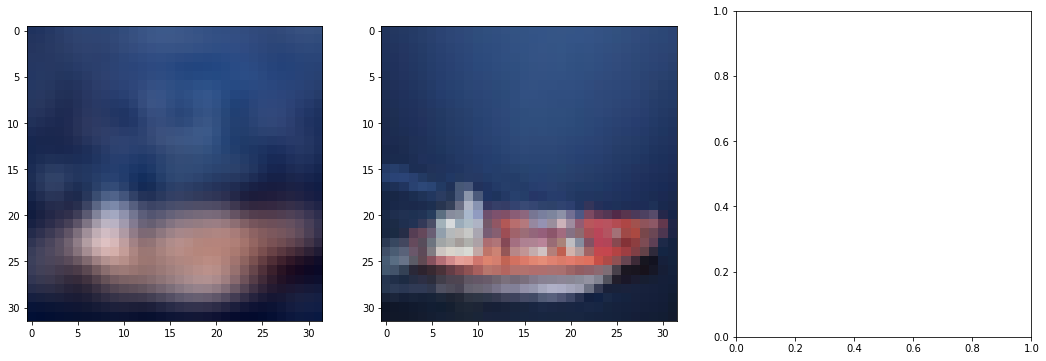

Step 2000, Total loss 0.006597
tensor(1.1804, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


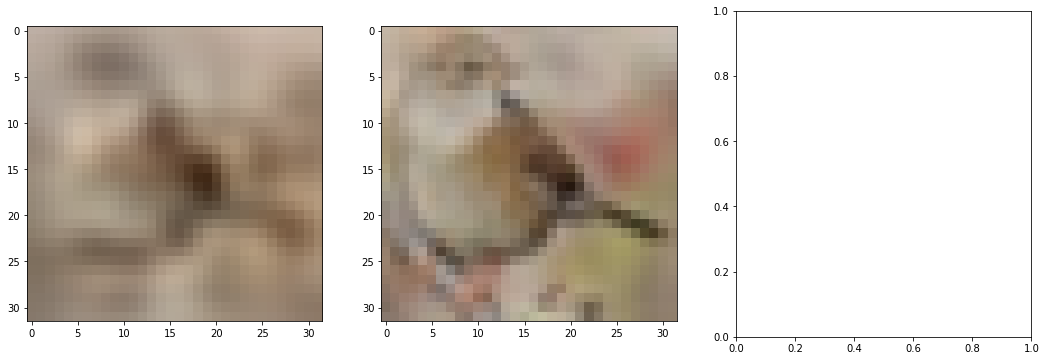

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006638
tensor(1.1141, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


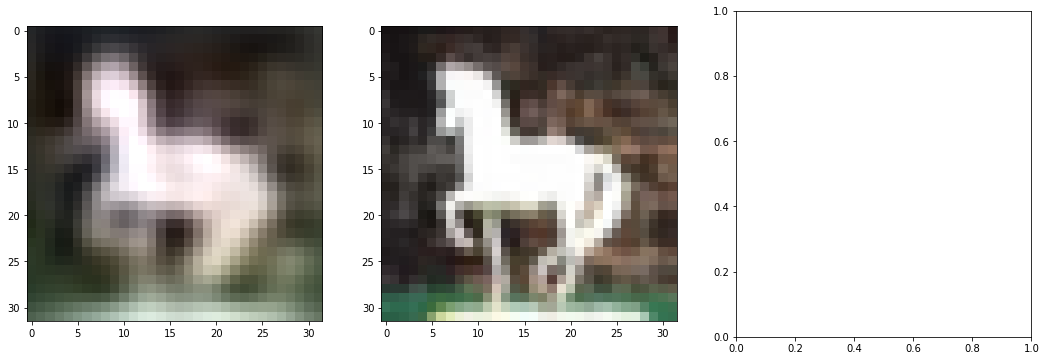

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.005789
tensor(1.0658, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


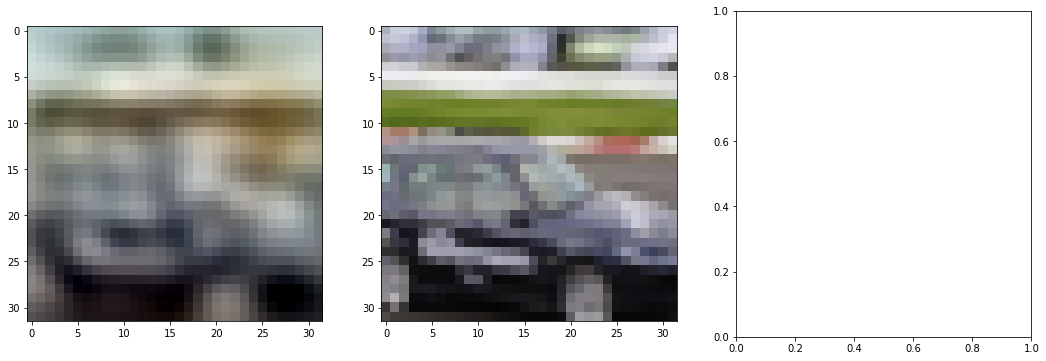

Step 2750, Total loss 0.006283
tensor(1.1302, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


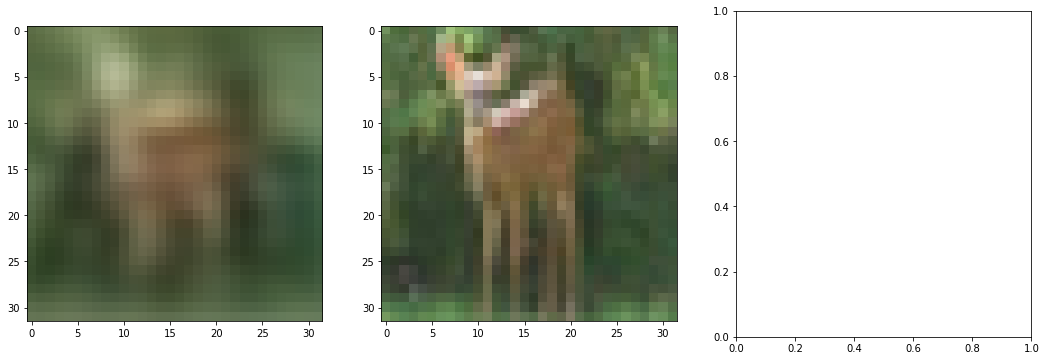

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.006253
tensor(1.0863, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


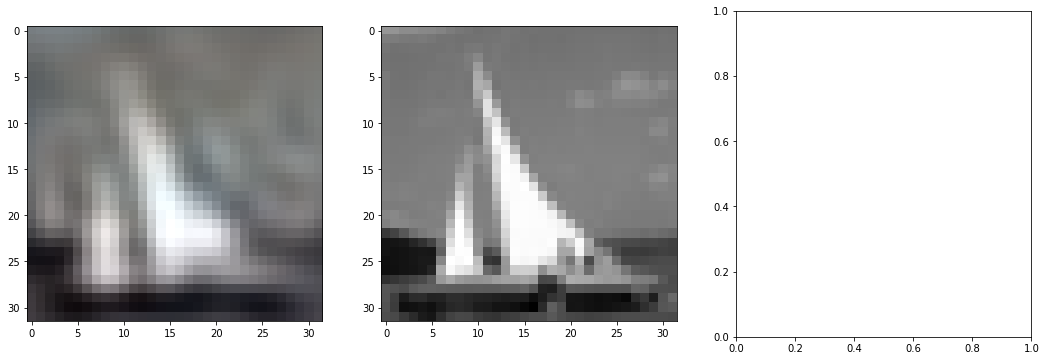

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.006117
tensor(1.1355, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


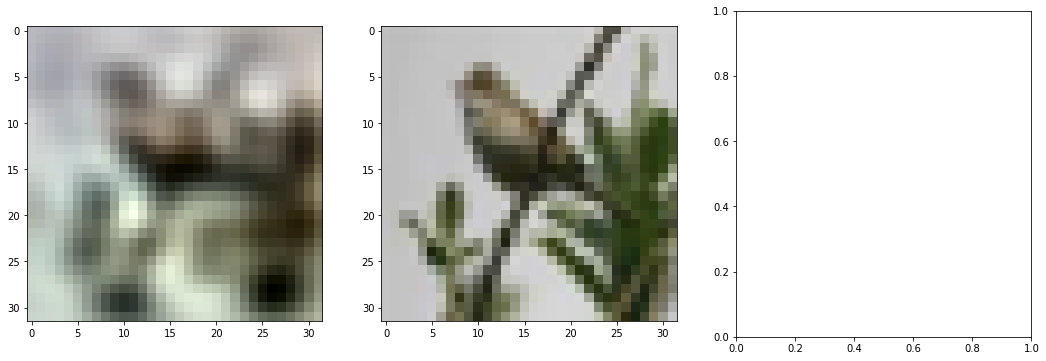

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006060
tensor(1.1279, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


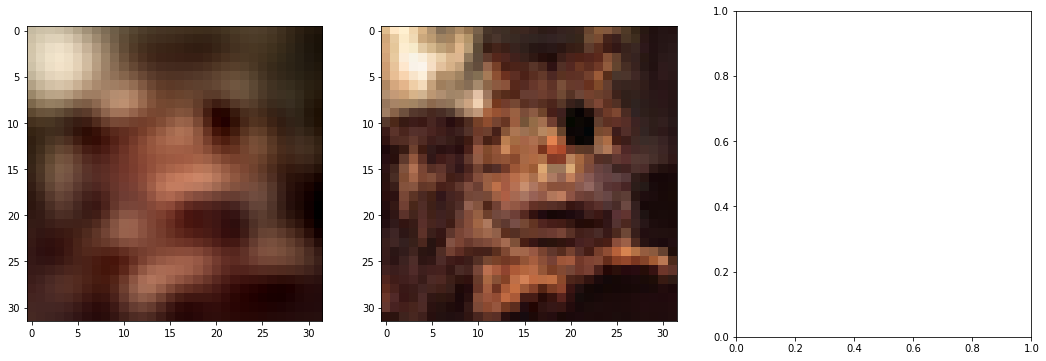

Step 500, Total loss 0.006383
tensor(1.1650, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


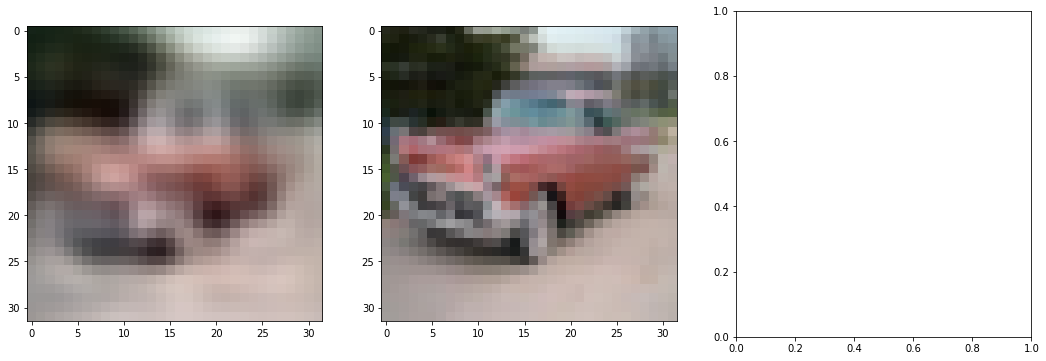

Step 750, Total loss 0.008091
tensor(1.1303, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


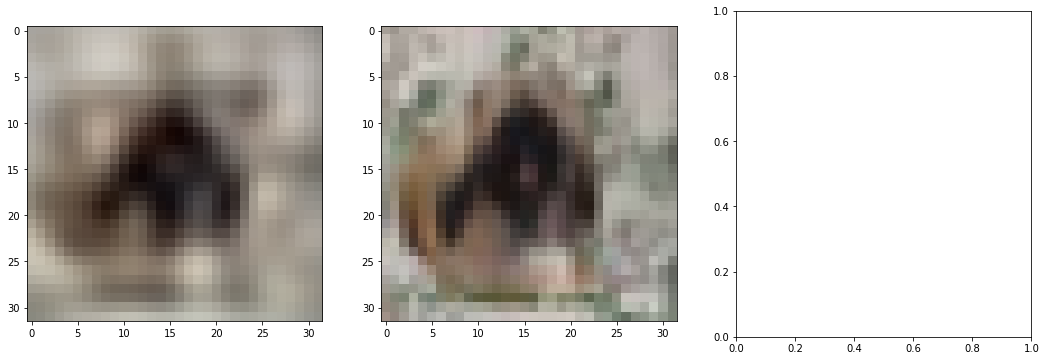

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006097
tensor(1.1109, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


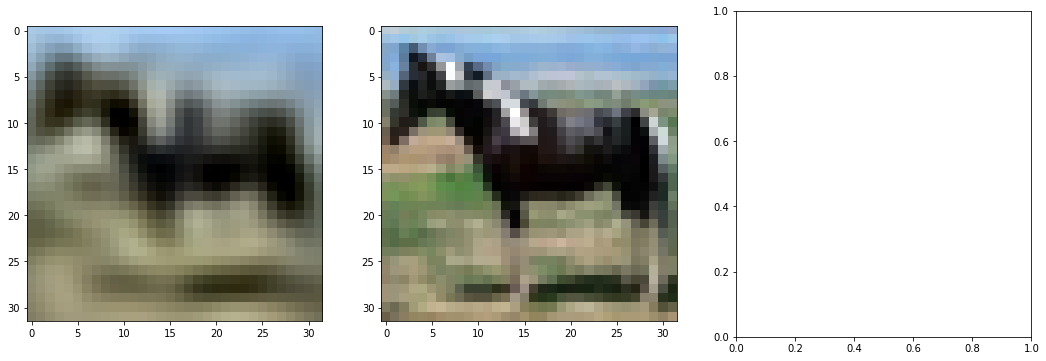

Step 1250, Total loss 0.007132
tensor(1.0769, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


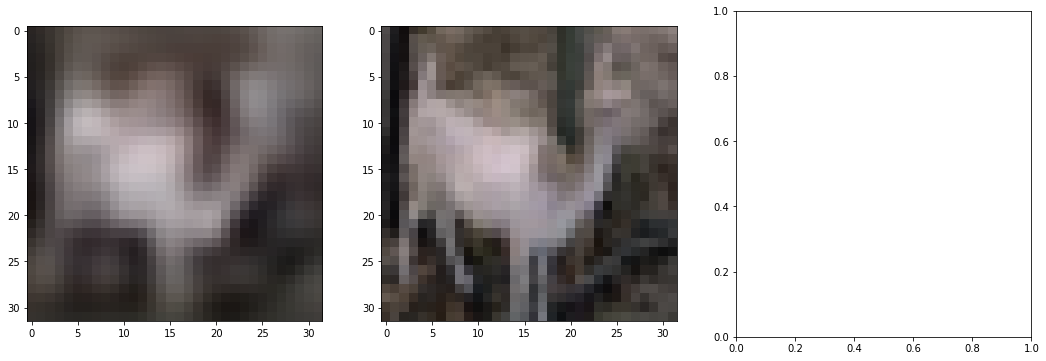

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006887
tensor(1.2017, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


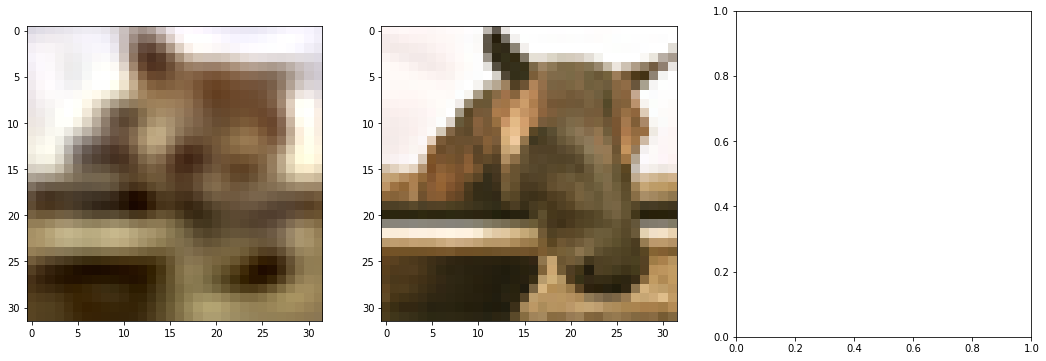

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.005486
tensor(1.1304, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


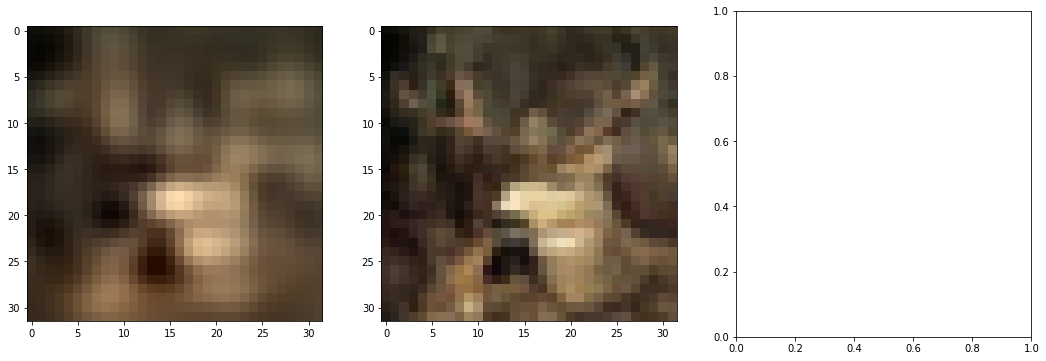

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006878
tensor(1.1335, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


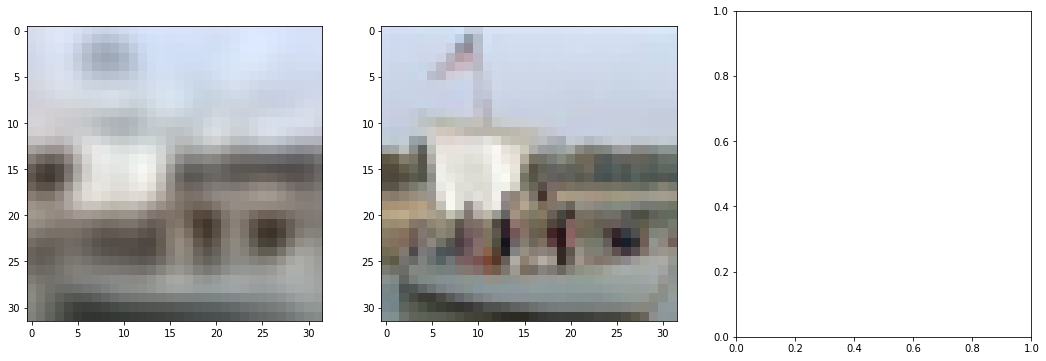

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006974
tensor(1.1251, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


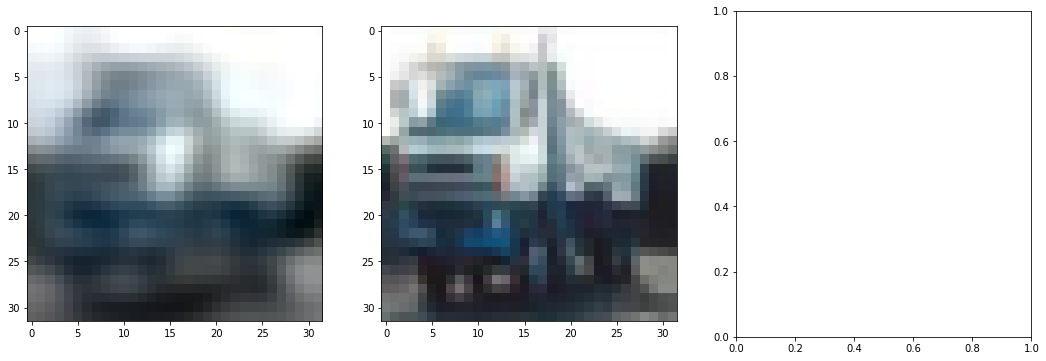

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.006106
tensor(1.1551, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


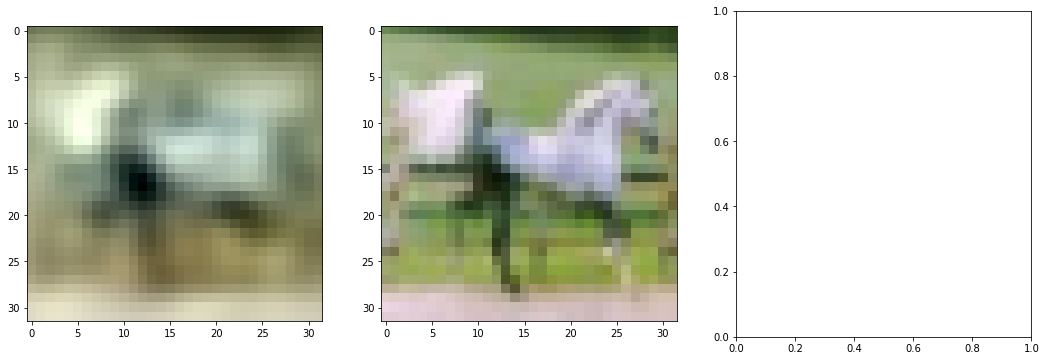

Step 2750, Total loss 0.005949
tensor(1.1056, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


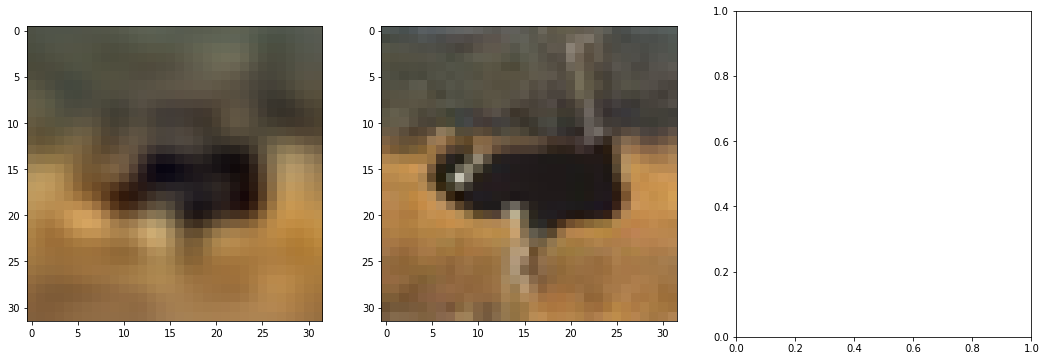

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.007722
tensor(1.1428, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


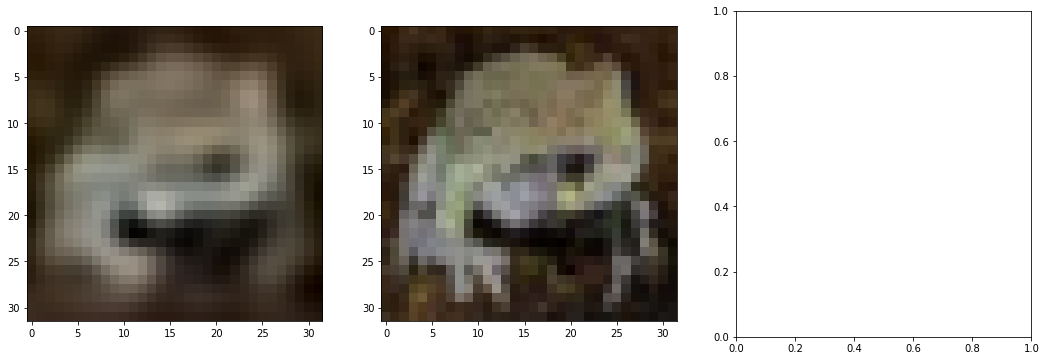

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.007433
tensor(1.1021, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


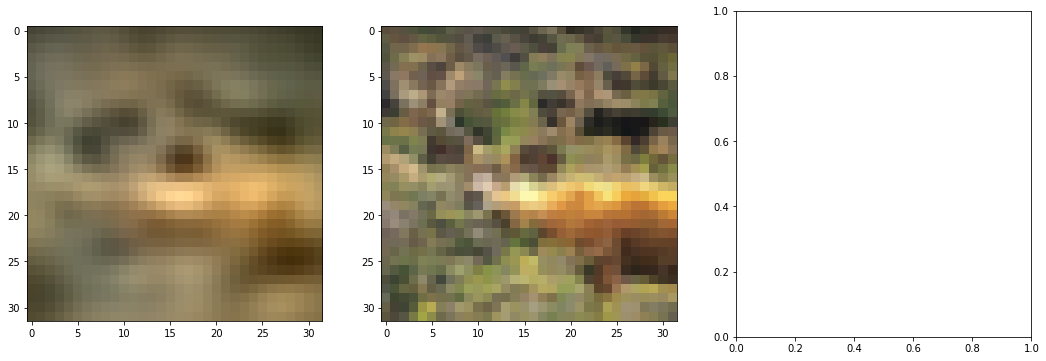

Step 250, Total loss 0.006935
tensor(1.1623, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


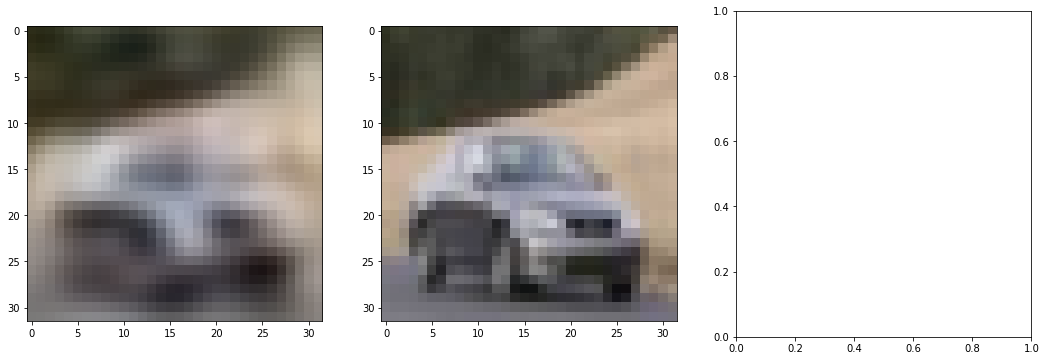

Step 500, Total loss 0.006303
tensor(1.0647, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


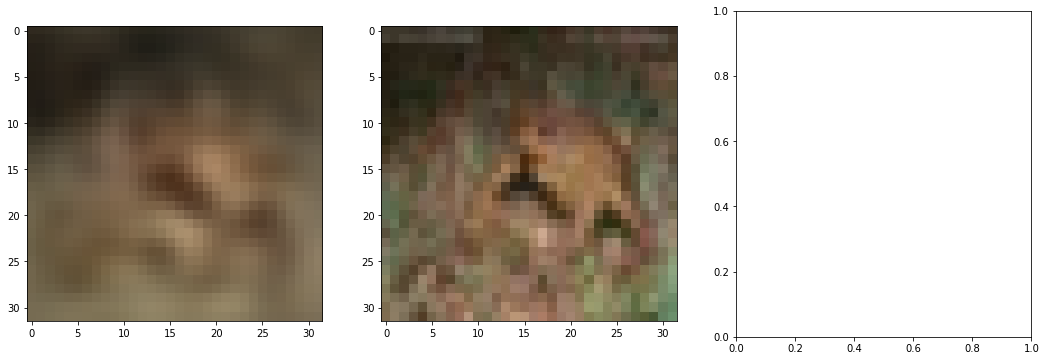

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.007507
tensor(1.1272, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


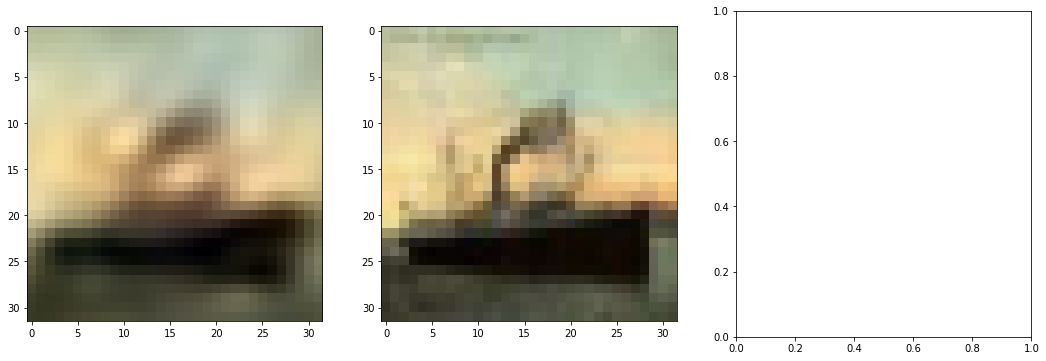

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.005333
tensor(1.1293, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


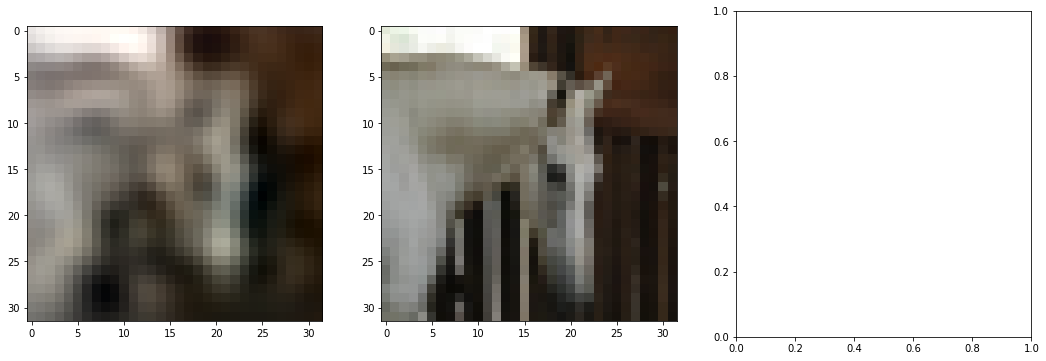

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.005455
tensor(1.1406, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


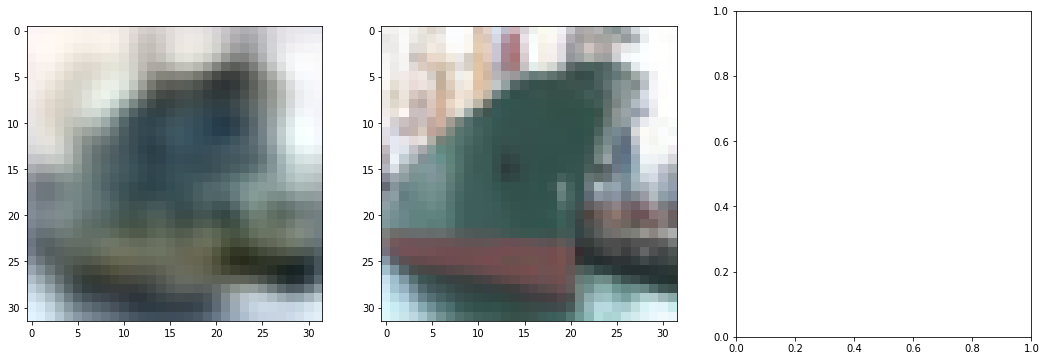

Step 1500, Total loss 0.005215
tensor(1.1372, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


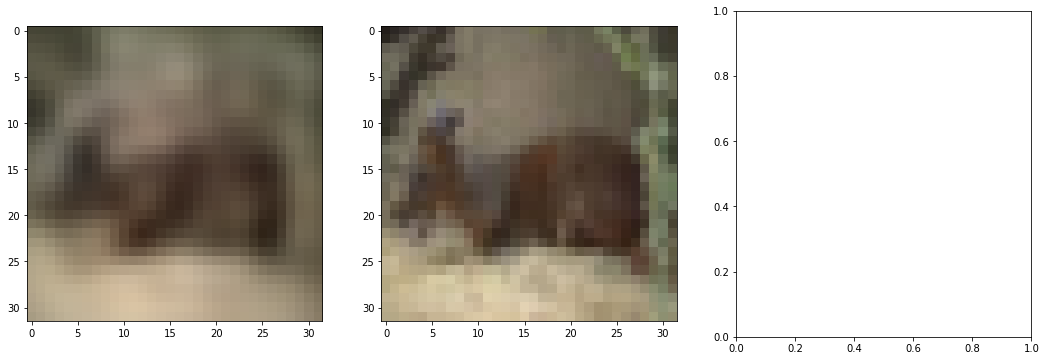

Step 1750, Total loss 0.006141
tensor(1.1431, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


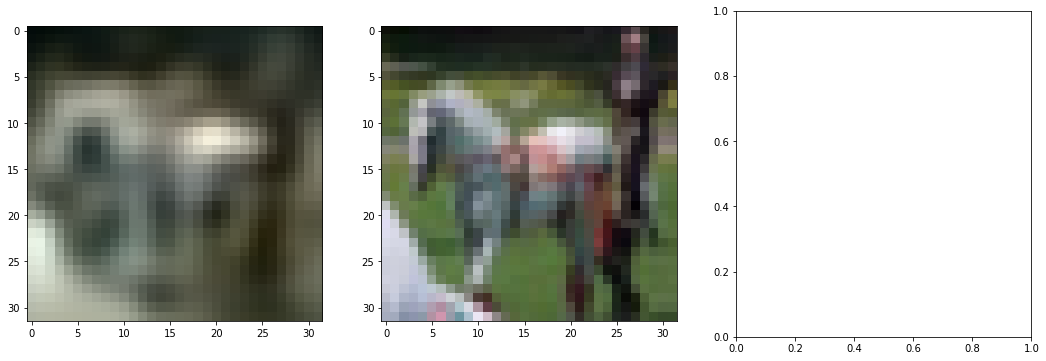

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006923
tensor(1.1132, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


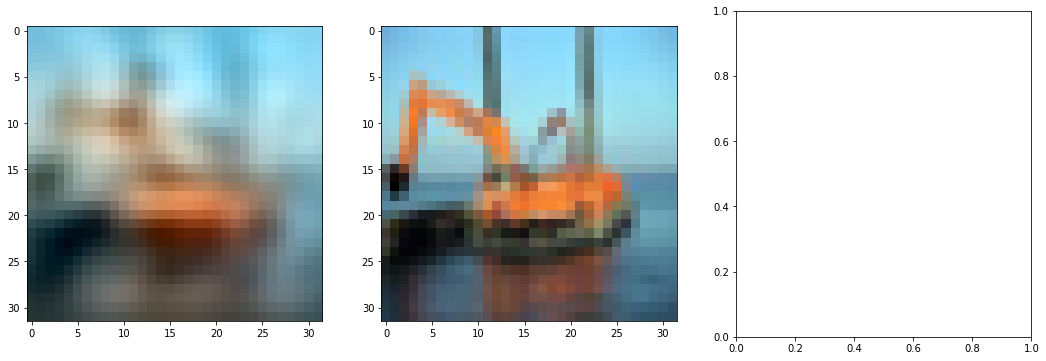

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006639
tensor(1.1105, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


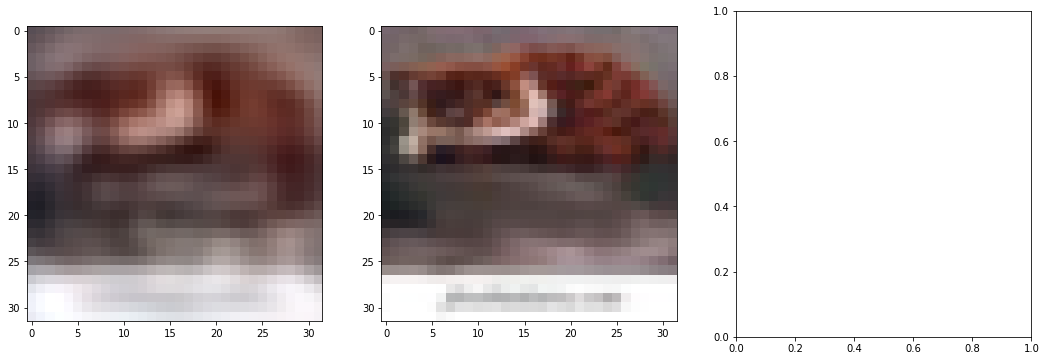

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.008728
tensor(1.1393, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


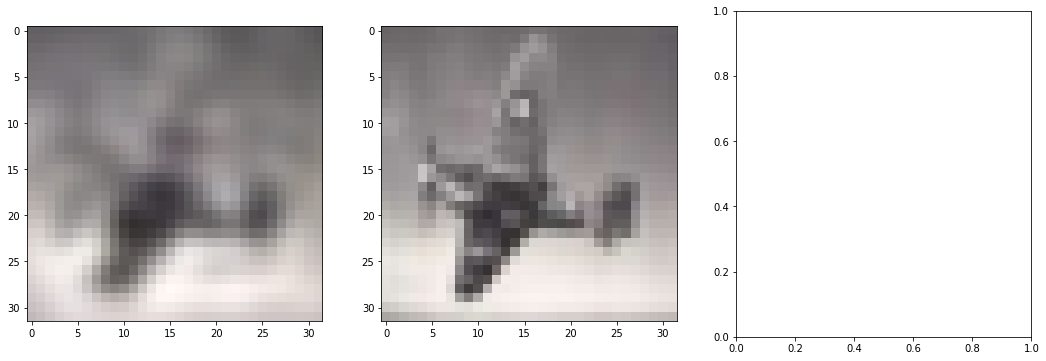

Step 2750, Total loss 0.007135
tensor(1.1709, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


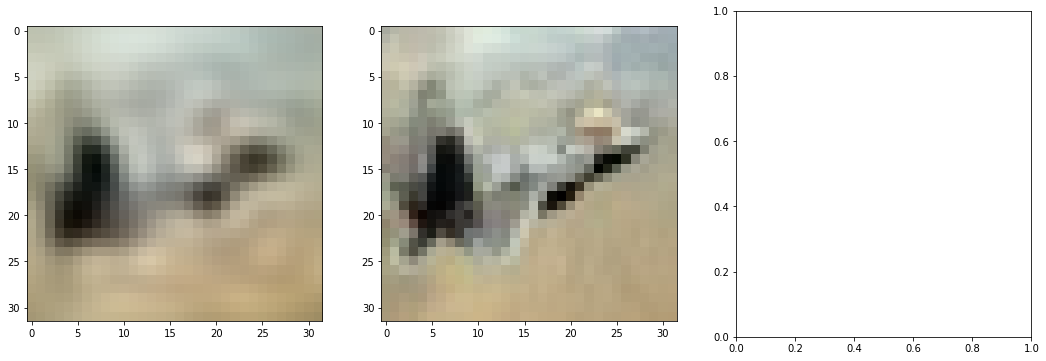

Step 3000, Total loss 0.006526
tensor(1.1708, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


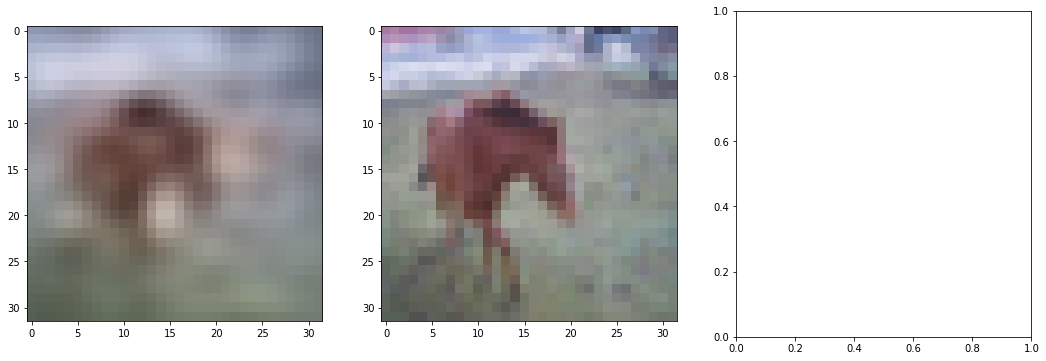

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.006515
tensor(1.1258, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


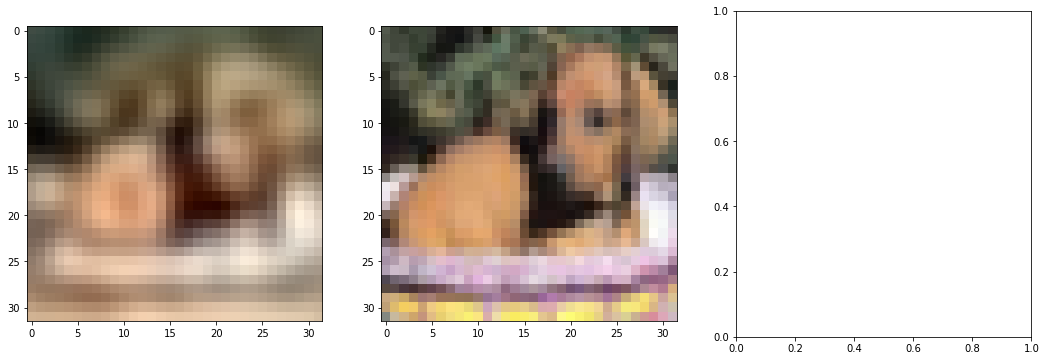

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.005918
tensor(1.0714, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


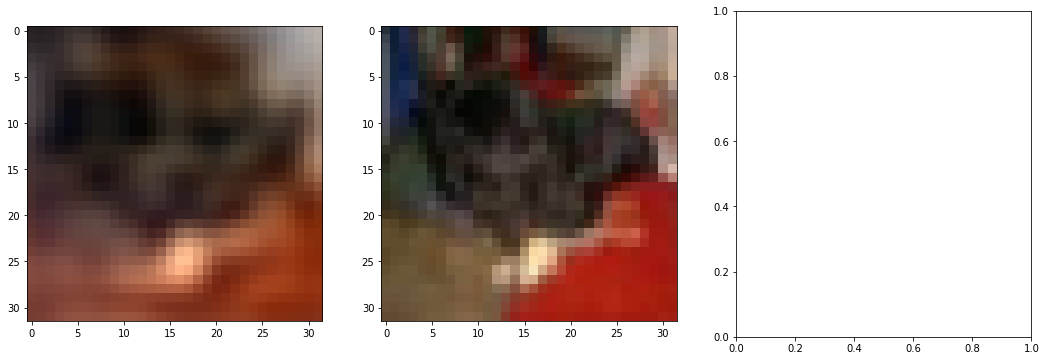

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006428
tensor(1.1086, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


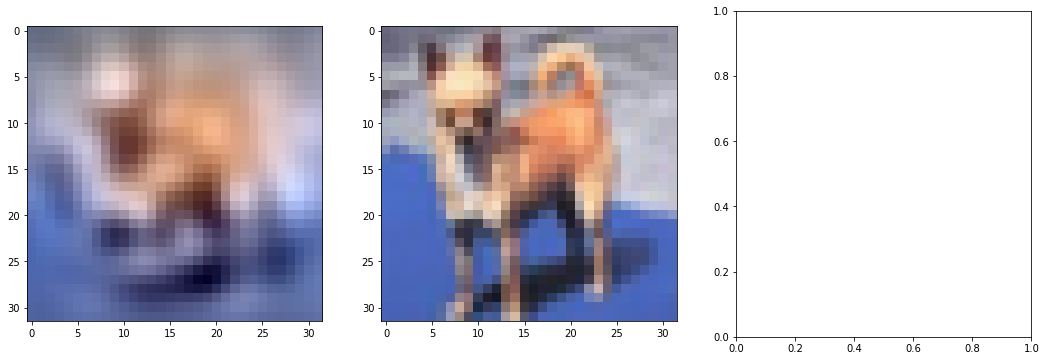

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.005221
tensor(1.0860, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


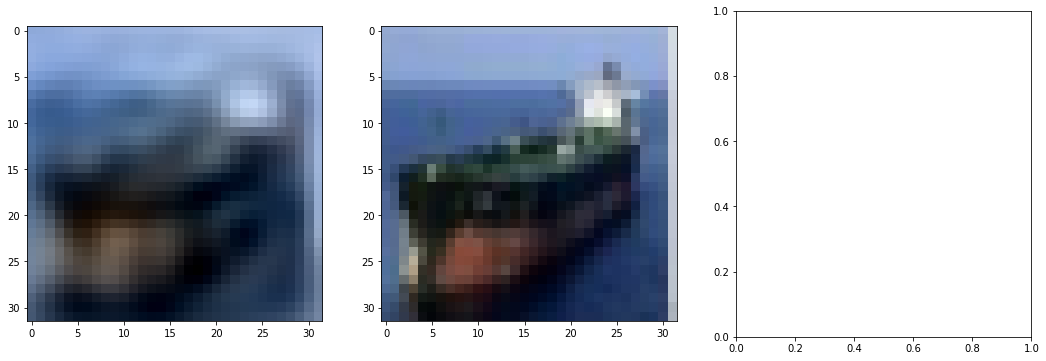

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.005608
tensor(1.1222, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


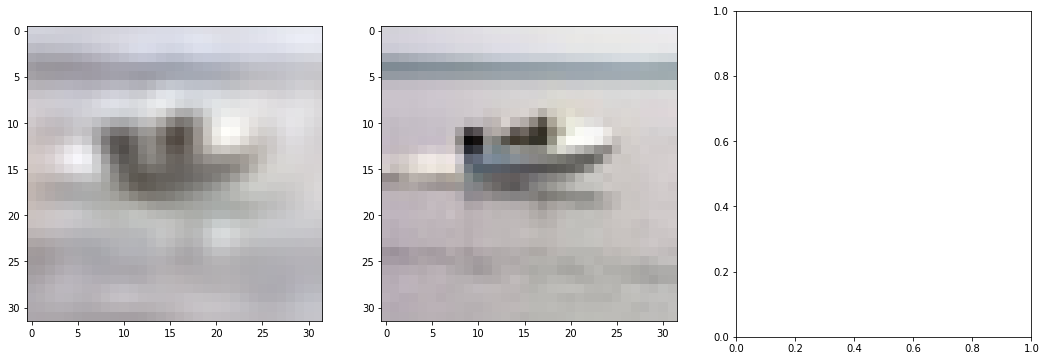

Step 1250, Total loss 0.006964
tensor(1.0486, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


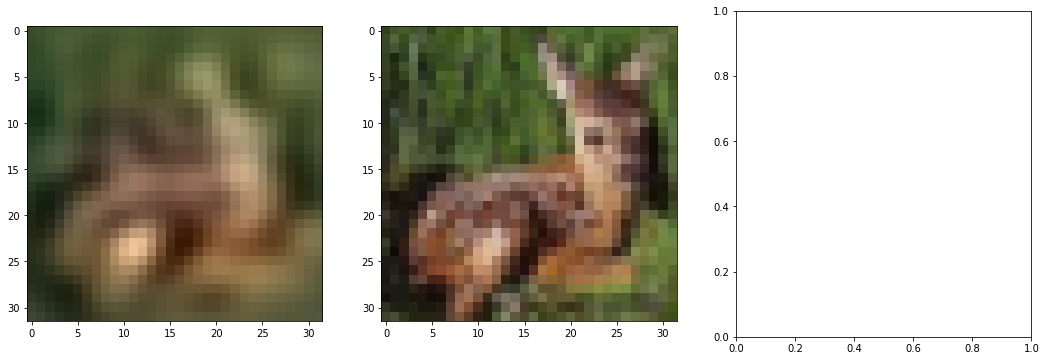

Step 1500, Total loss 0.005171
tensor(1.0819, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


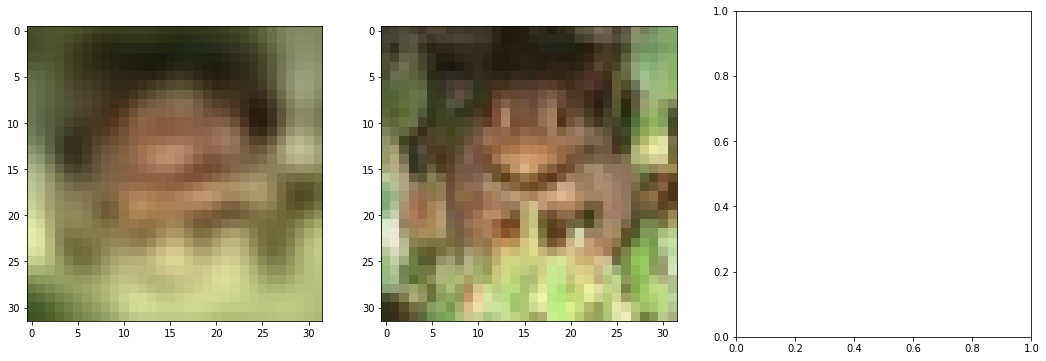

Step 1750, Total loss 0.004992
tensor(1.1812, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


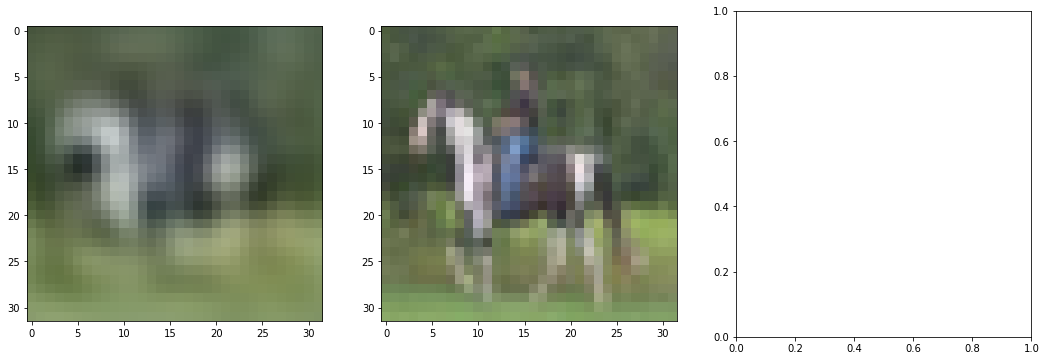

Step 2000, Total loss 0.006881
tensor(1.1158, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


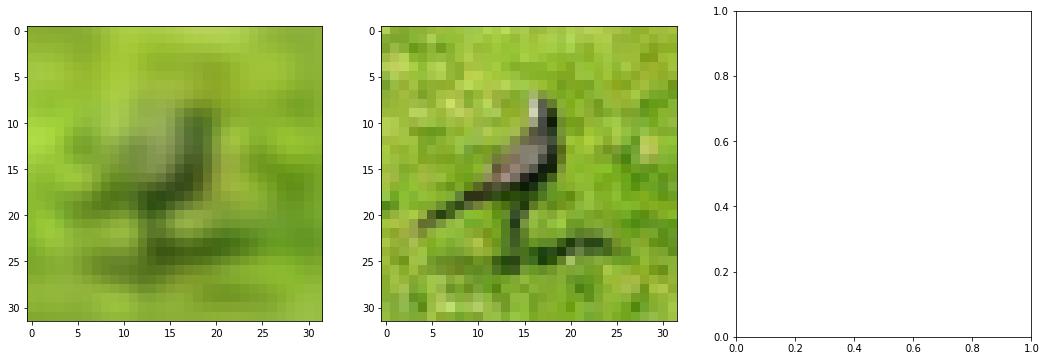

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.005408
tensor(1.0700, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


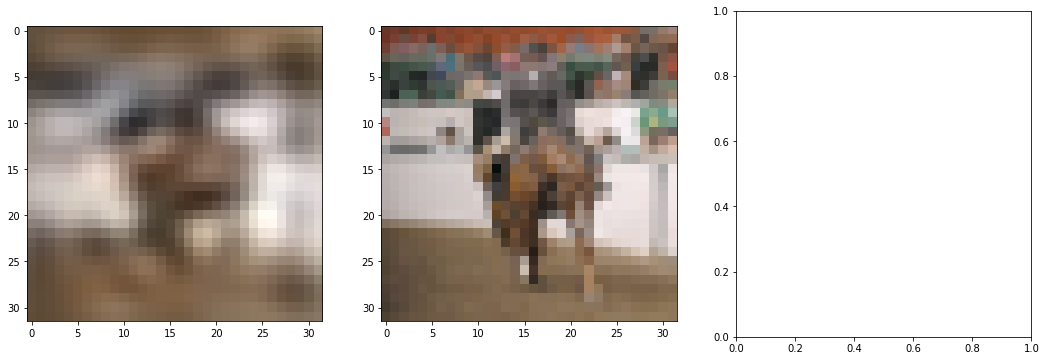

Step 2500, Total loss 0.006449
tensor(1.1428, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


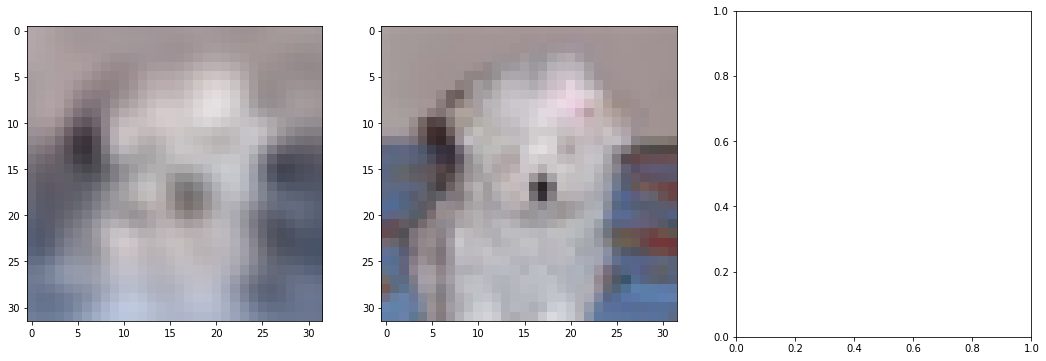

Step 2750, Total loss 0.006882
tensor(1.1870, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


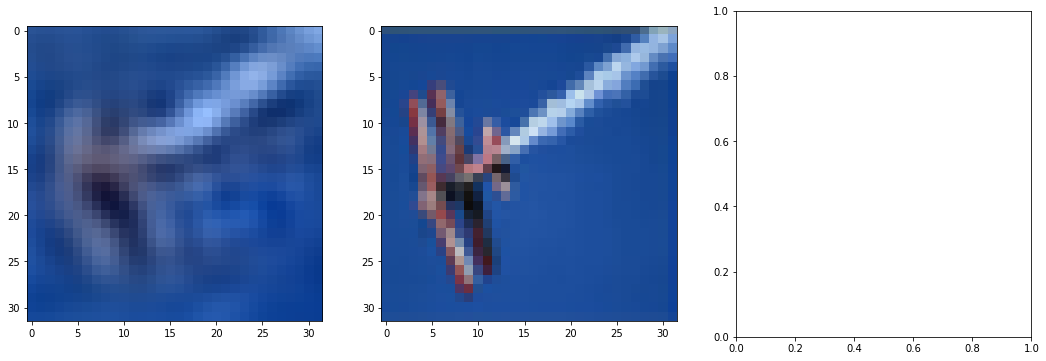

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.006534
tensor(1.1051, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


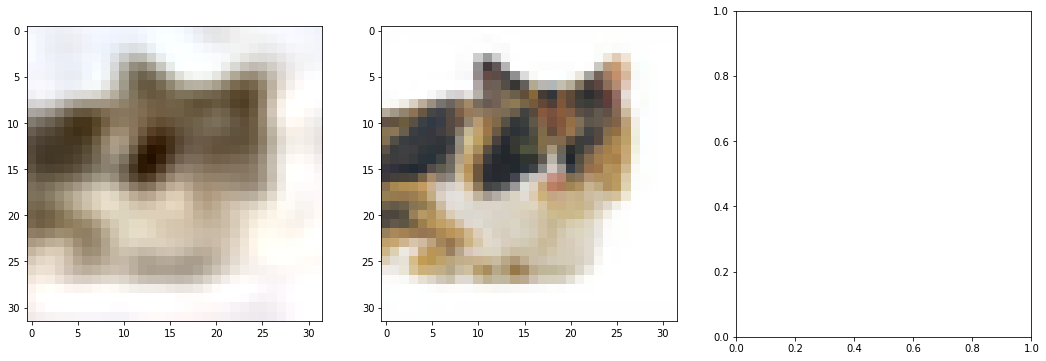

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.007555
tensor(1.1072, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


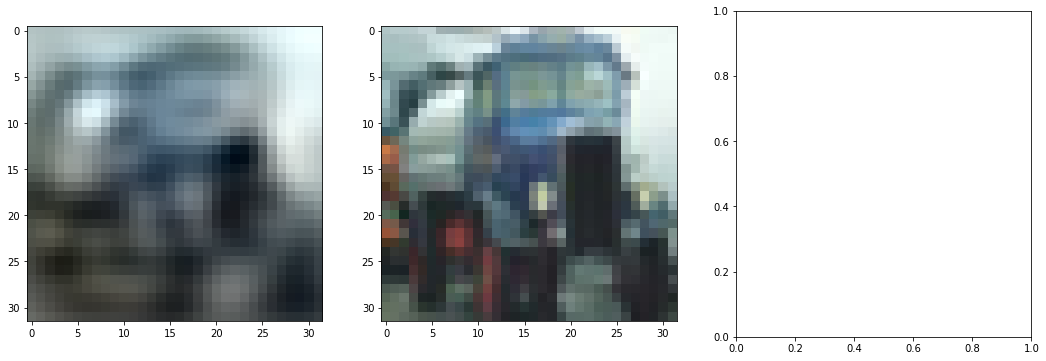

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006553
tensor(1.1136, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


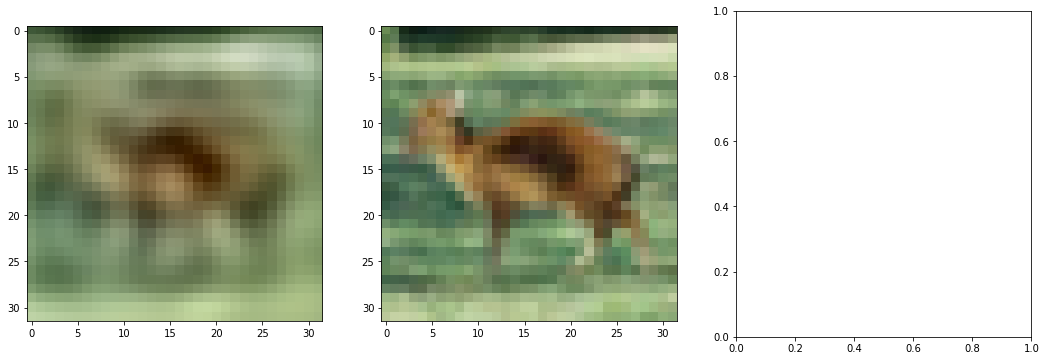

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006392
tensor(1.1469, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


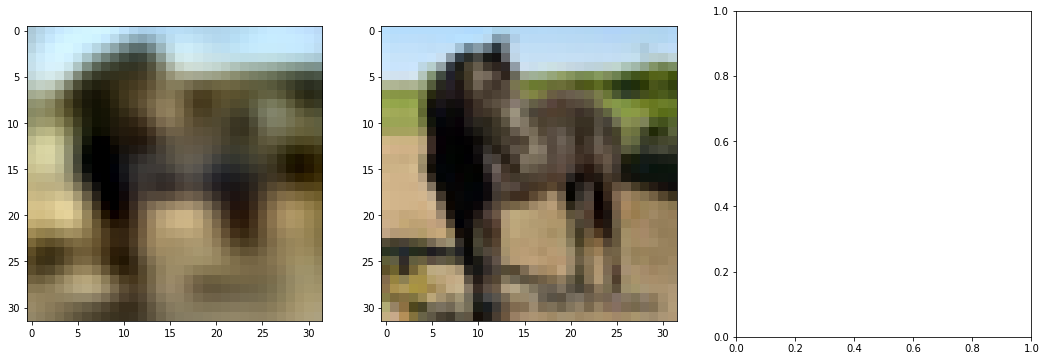

Step 750, Total loss 0.007059
tensor(1.1463, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


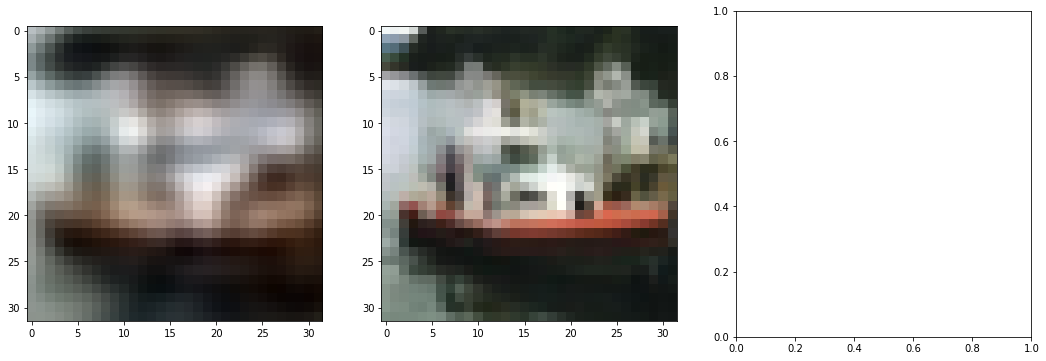

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006731
tensor(1.1334, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


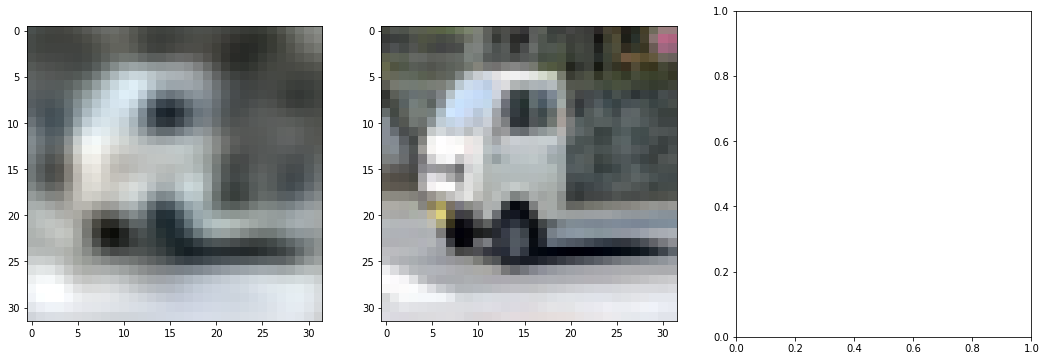

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.005859
tensor(1.1316, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


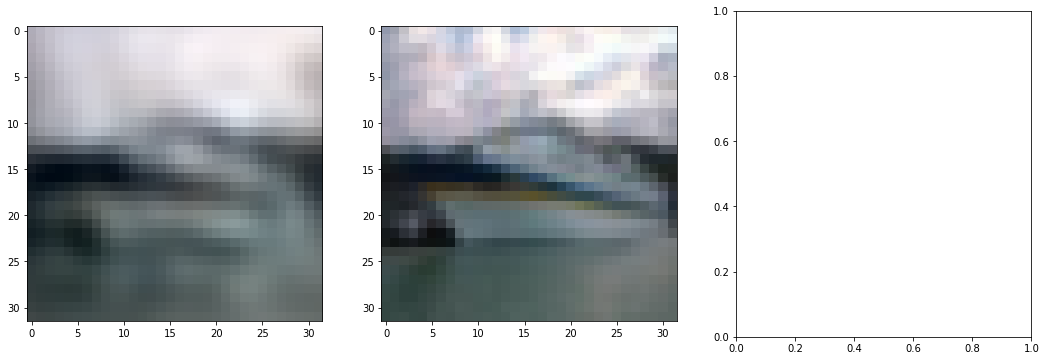

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.007345
tensor(1.1318, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


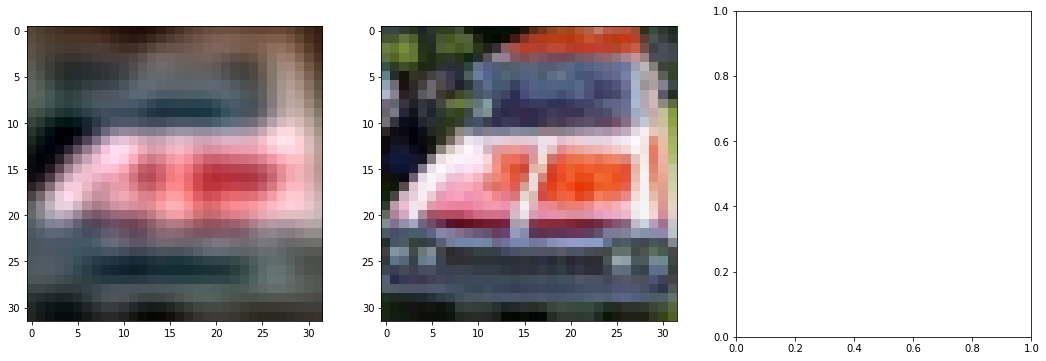

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006007
tensor(1.1599, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


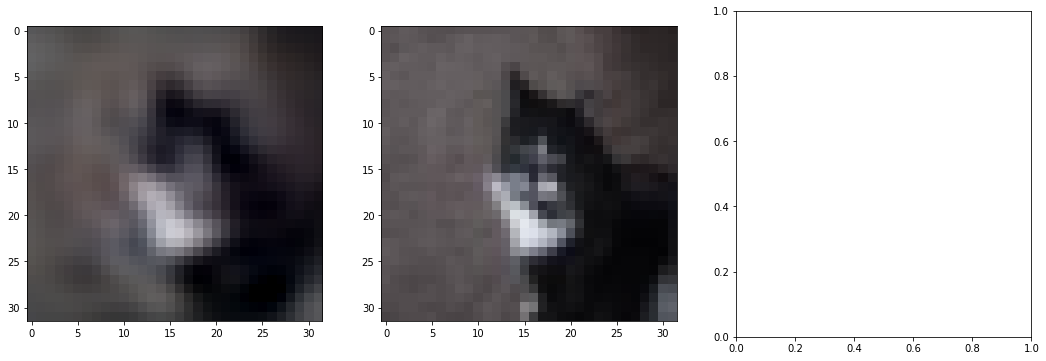

Step 2000, Total loss 0.006785
tensor(1.1028, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


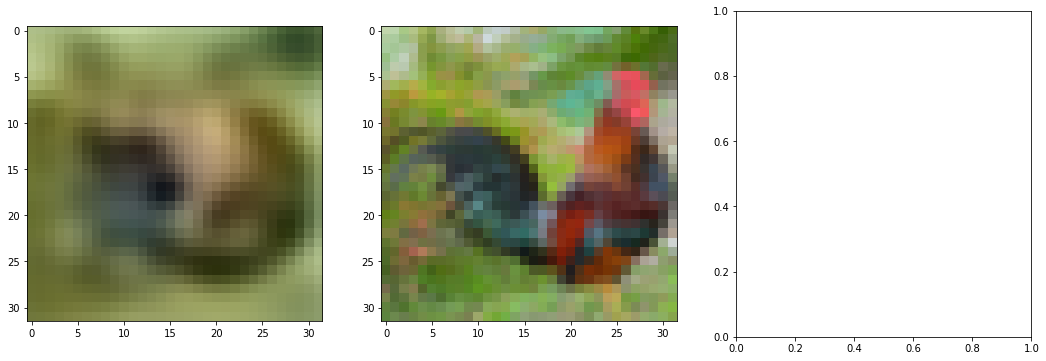

Step 2250, Total loss 0.005470
tensor(1.1329, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


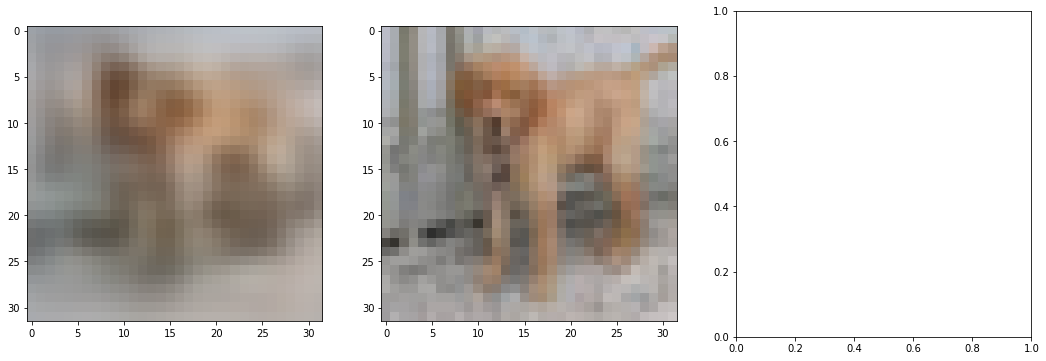

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.006393
tensor(1.0848, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


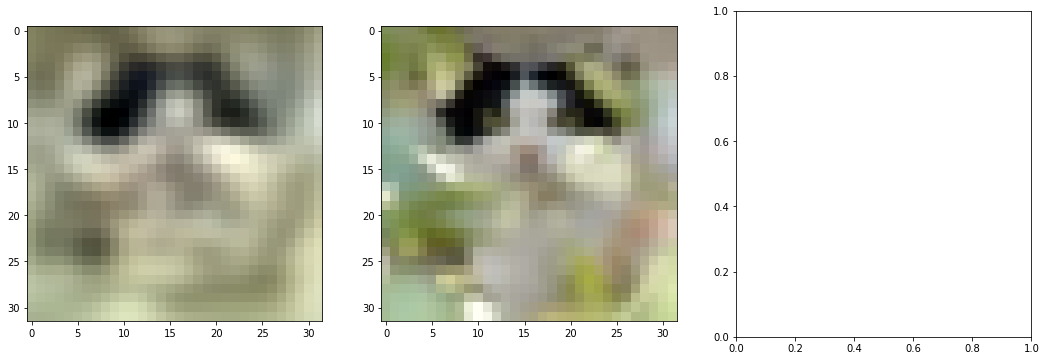

Step 2750, Total loss 0.007949
tensor(1.1693, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


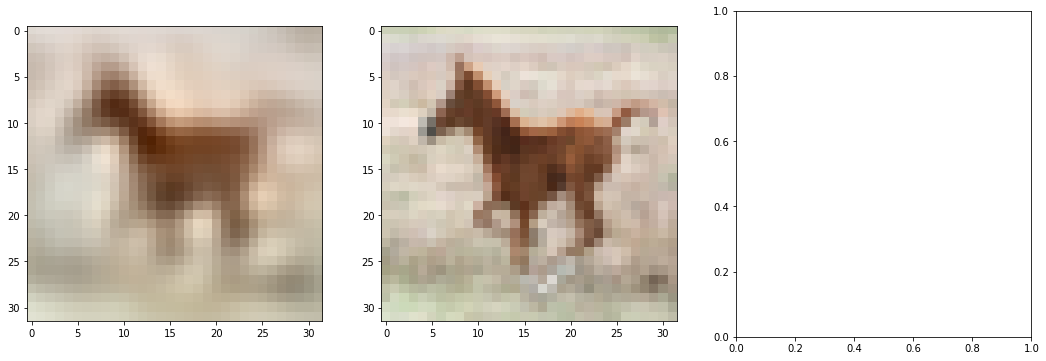

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.005861
tensor(1.1381, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


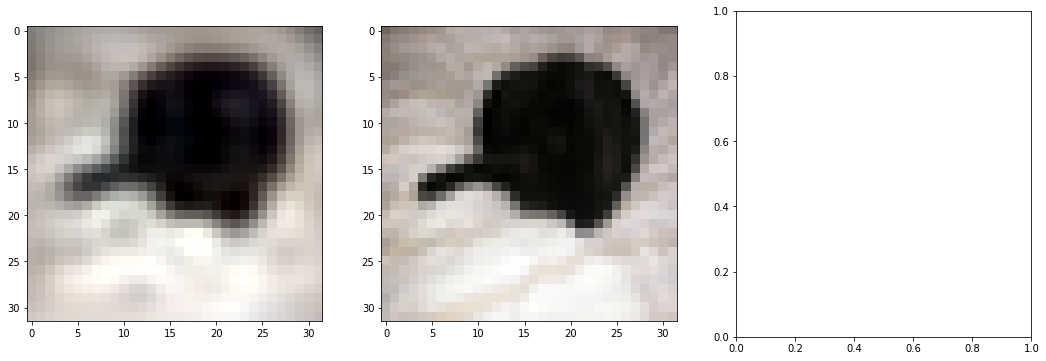

Step 0, Total loss 0.005430
tensor(1.1893, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


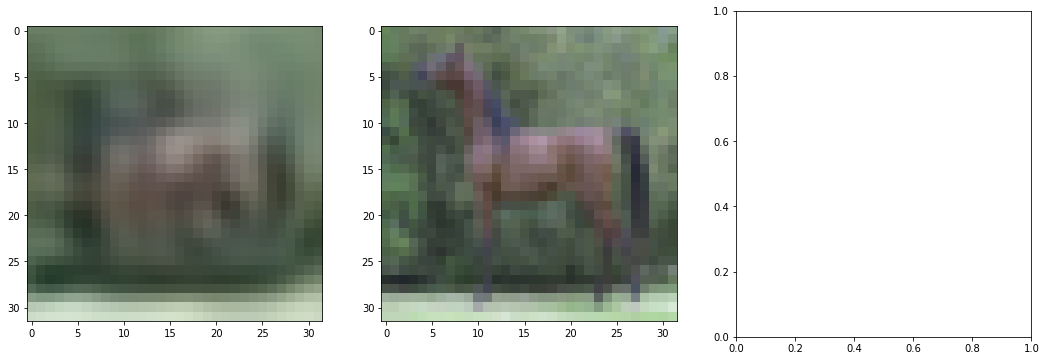

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.005662
tensor(1.1430, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


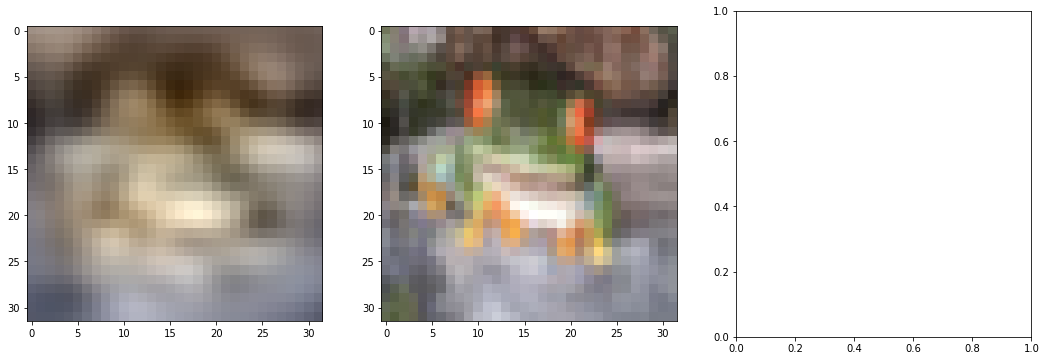

Step 500, Total loss 0.006841
tensor(1.1693, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


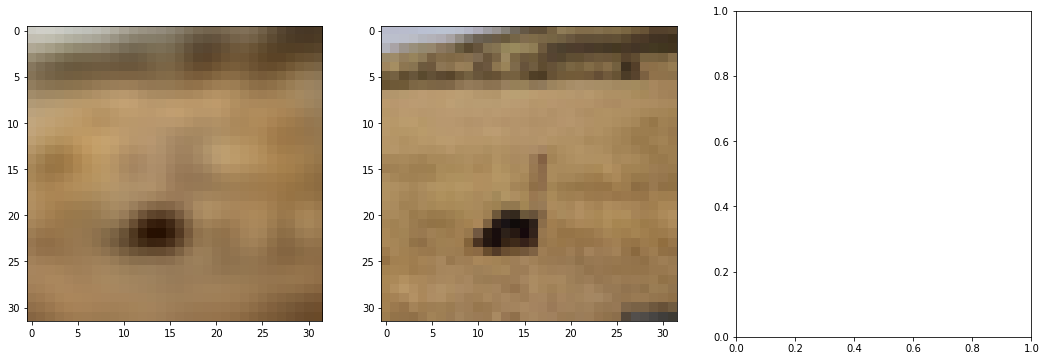

Step 750, Total loss 0.006701
tensor(1.0764, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


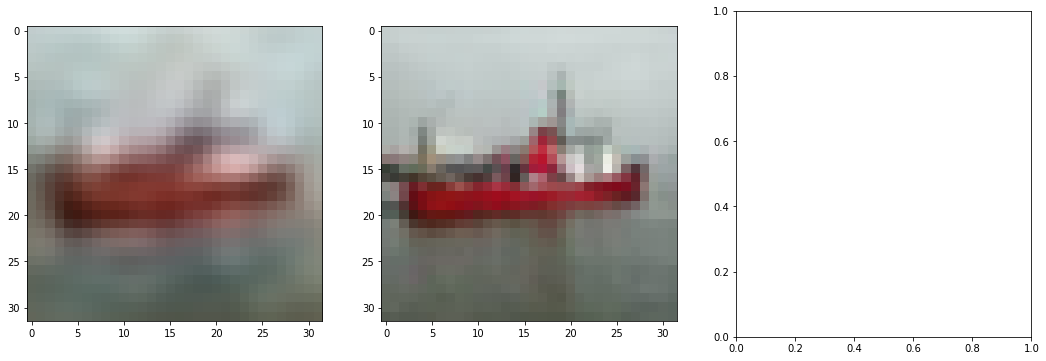

Step 1000, Total loss 0.005776
tensor(1.1010, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


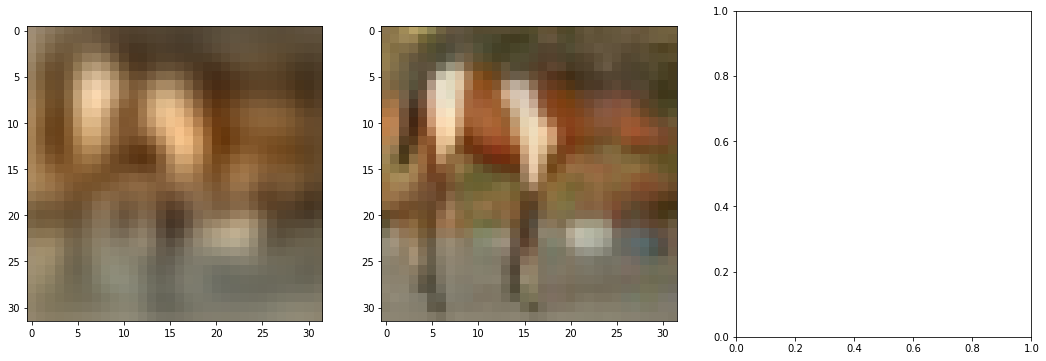

Step 1250, Total loss 0.007177
tensor(1.1174, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


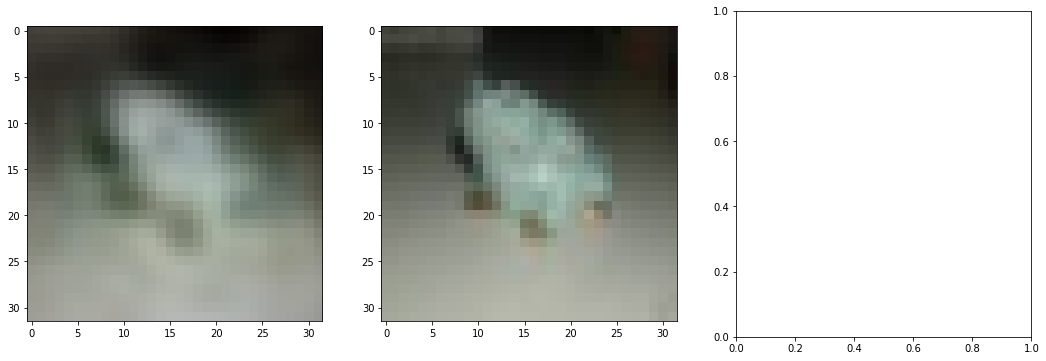

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006280
tensor(1.0911, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


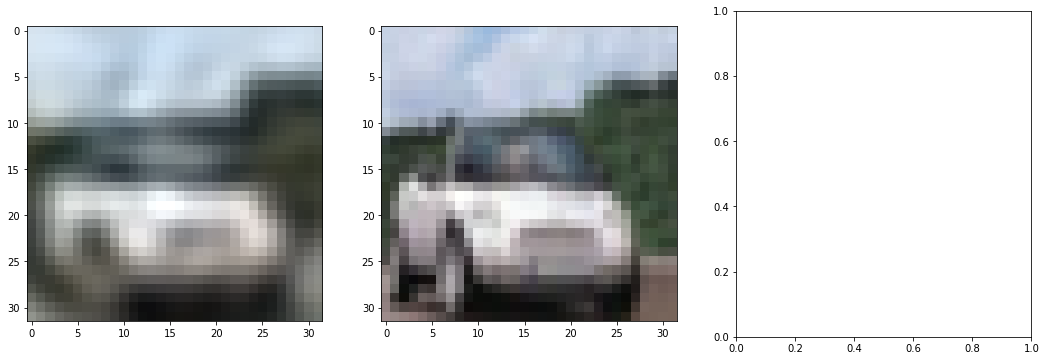

Step 1750, Total loss 0.006284
tensor(1.1507, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


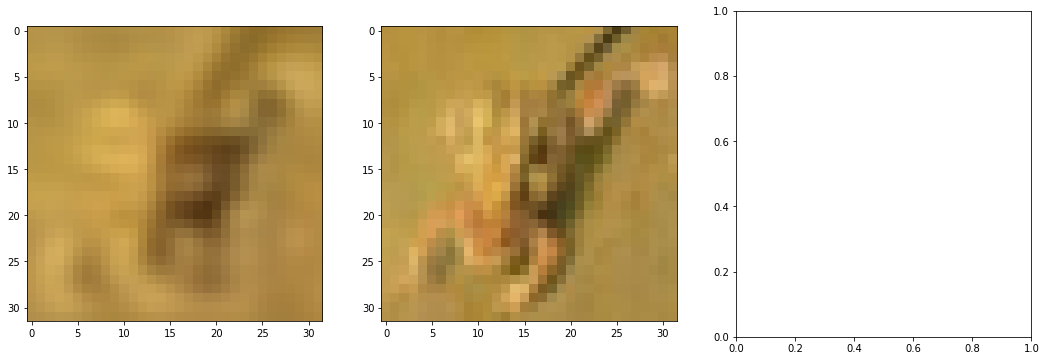

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006565
tensor(1.1481, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


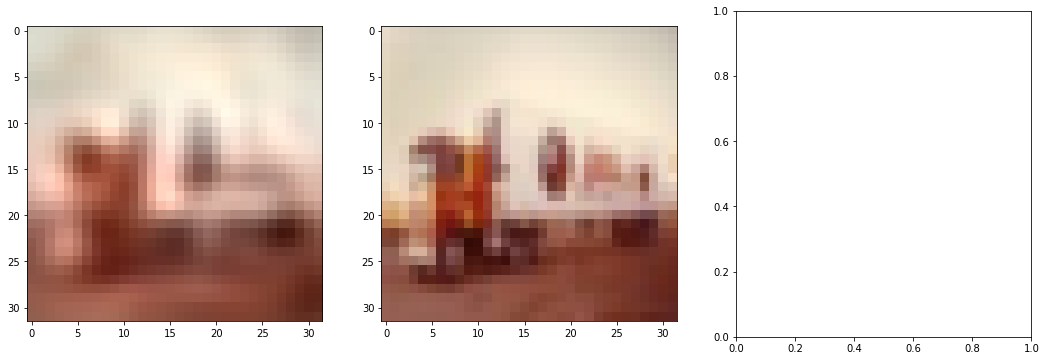

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.008692
tensor(1.1487, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


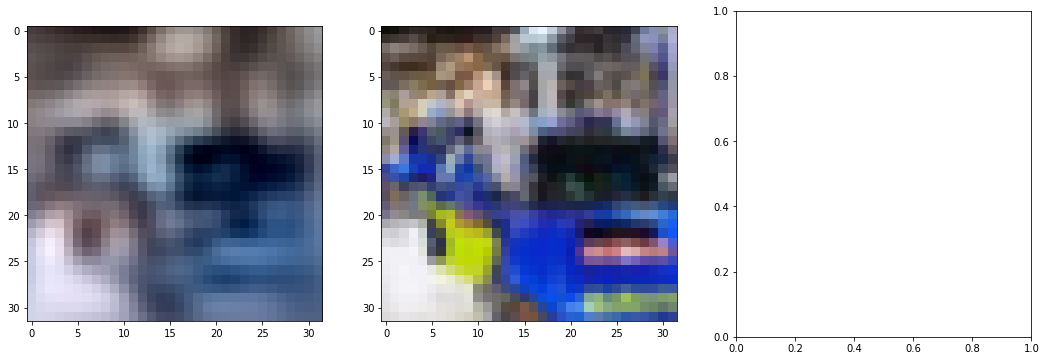

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.005748
tensor(1.1092, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


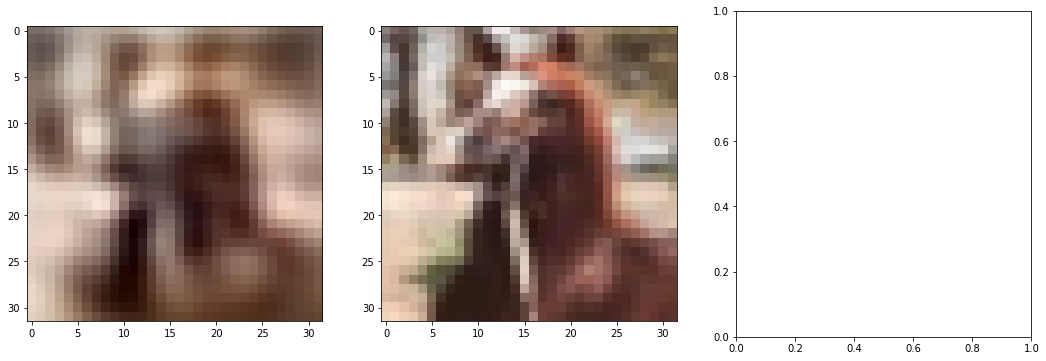

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.006728
tensor(1.1011, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


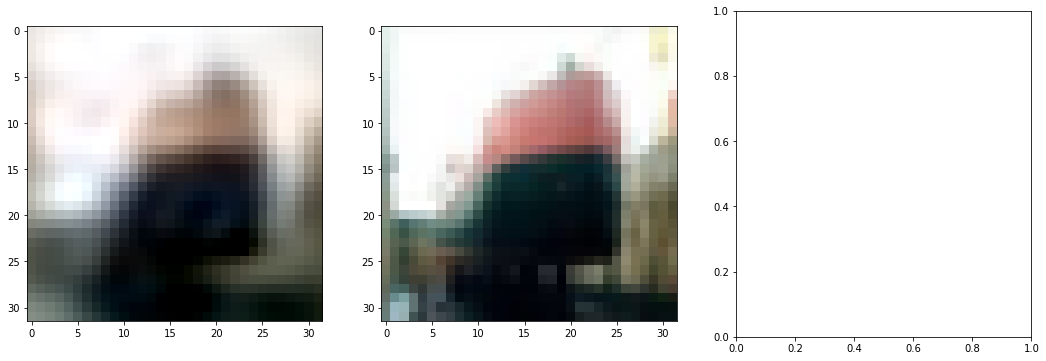

Step 3000, Total loss 0.006883
tensor(1.1190, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


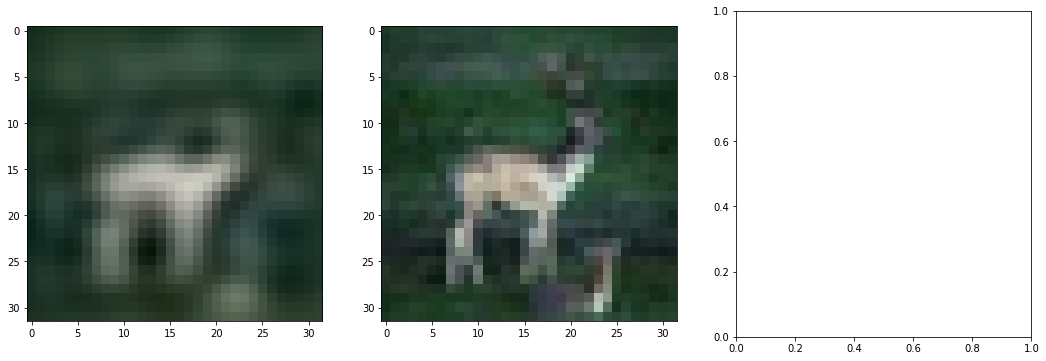

Step 0, Total loss 0.008013
tensor(1.1414, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


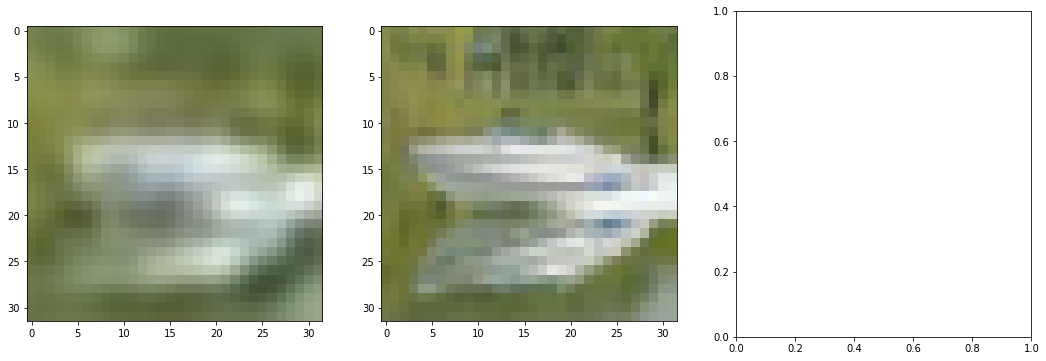

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006409
tensor(1.1861, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


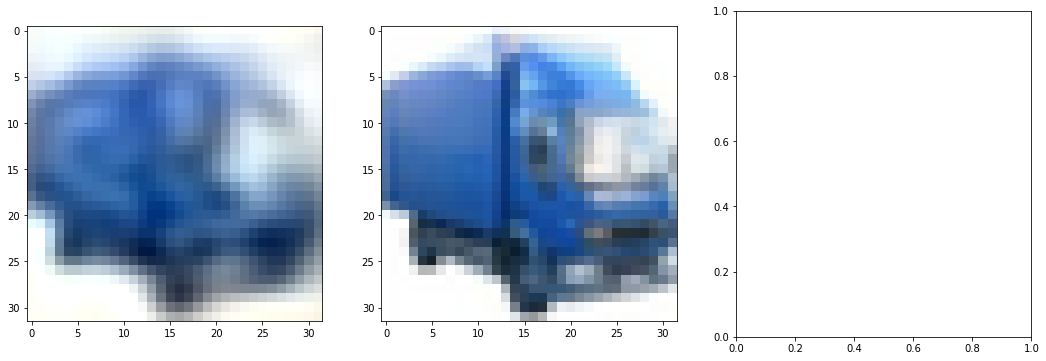

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006247
tensor(1.1722, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


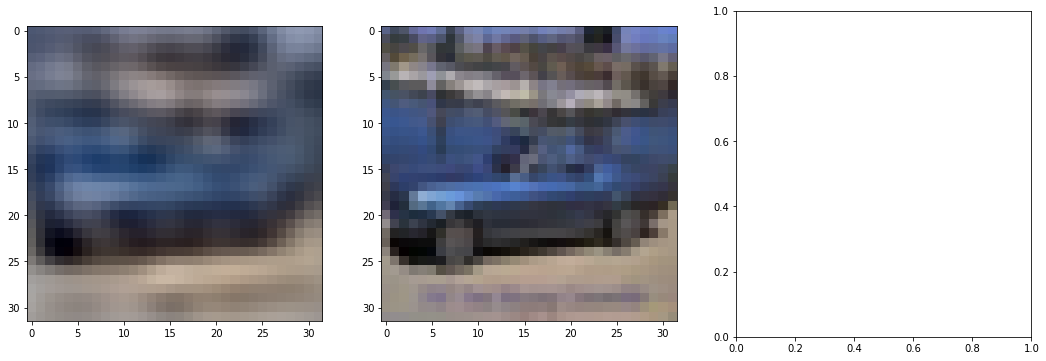

Step 750, Total loss 0.006642
tensor(1.1484, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


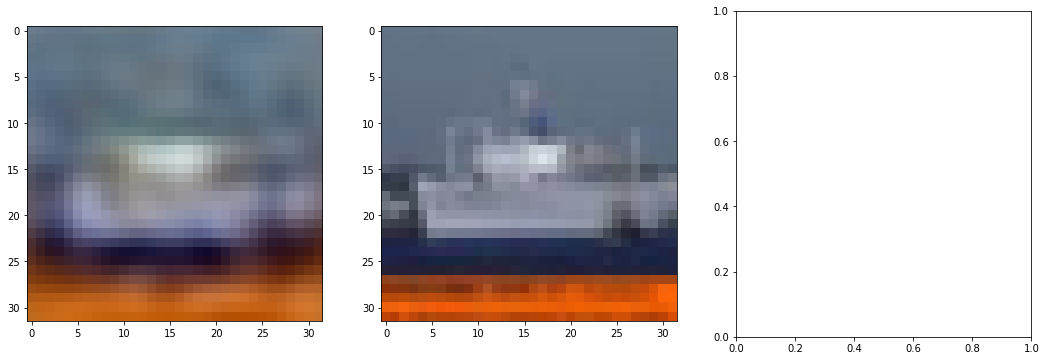

Step 1000, Total loss 0.006791
tensor(1.0960, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


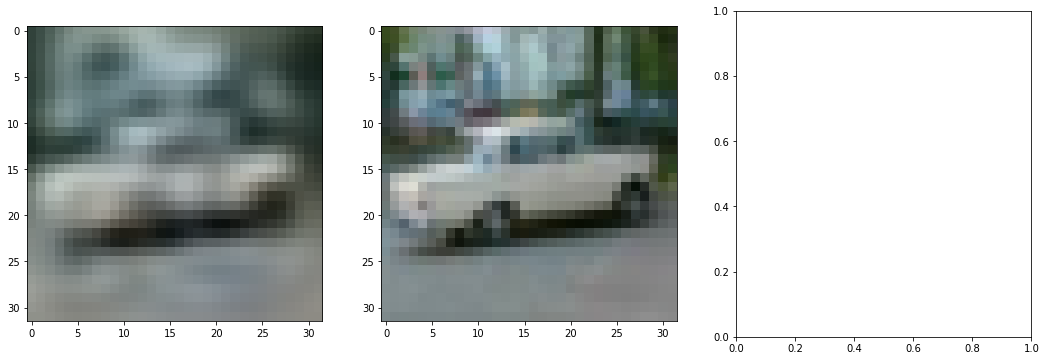

Step 1250, Total loss 0.006219
tensor(1.1846, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


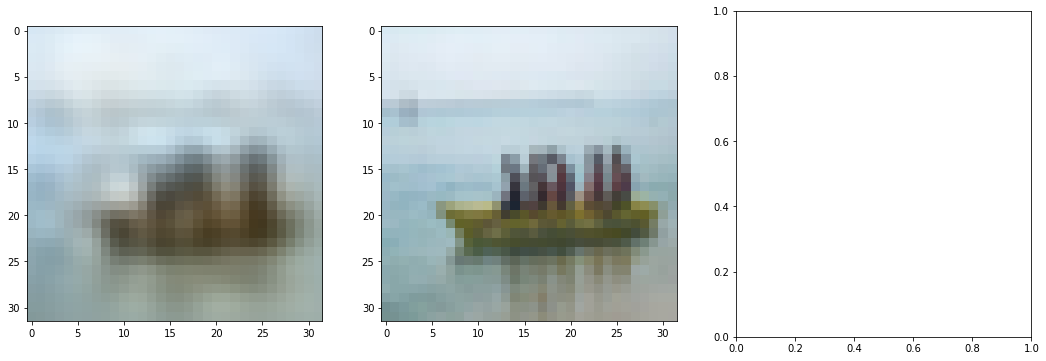

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.007550
tensor(1.1681, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


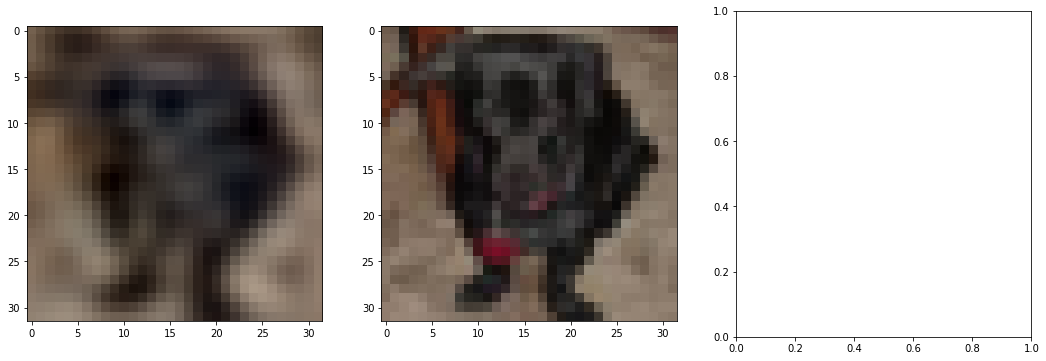

Step 1750, Total loss 0.005890
tensor(1.0441, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


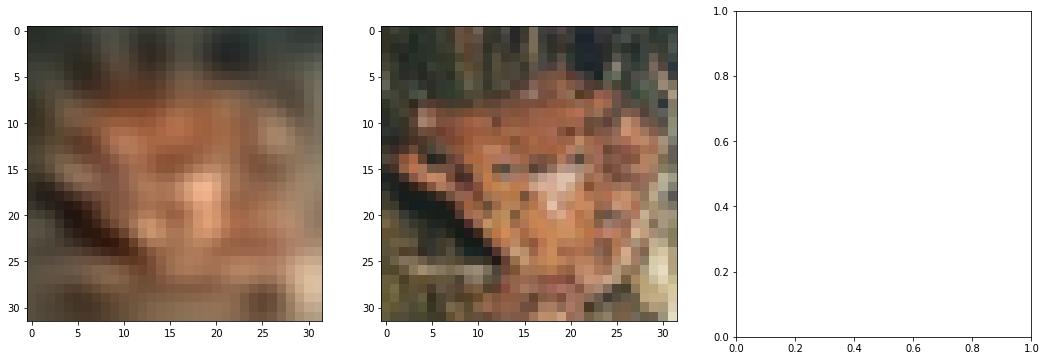

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.005631
tensor(1.1347, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


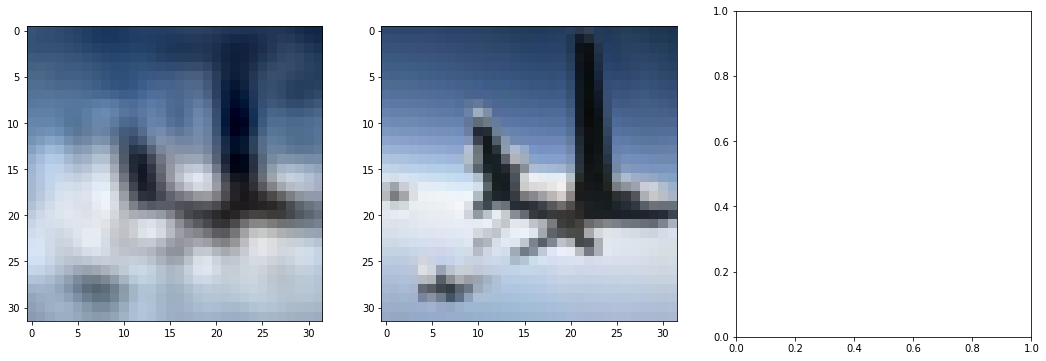

Step 2250, Total loss 0.005417
tensor(1.0664, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


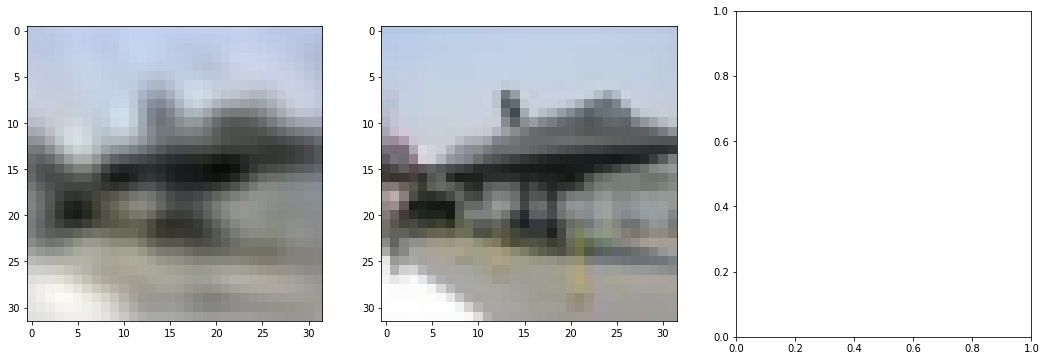

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.005359
tensor(1.1870, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


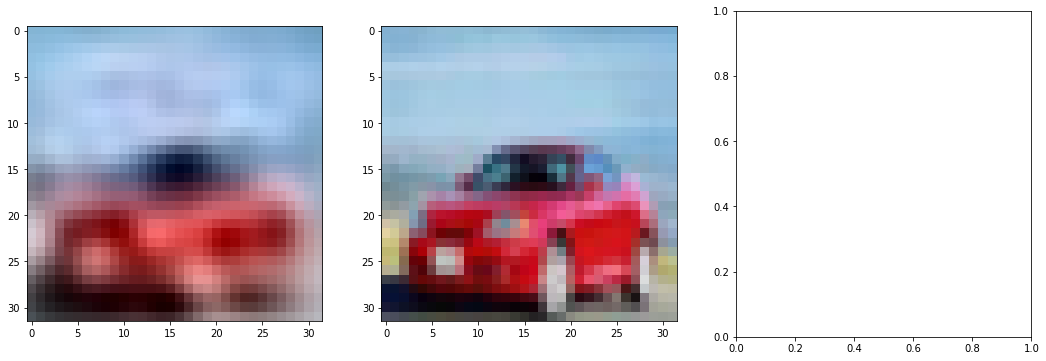

Step 2750, Total loss 0.006545
tensor(1.1244, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


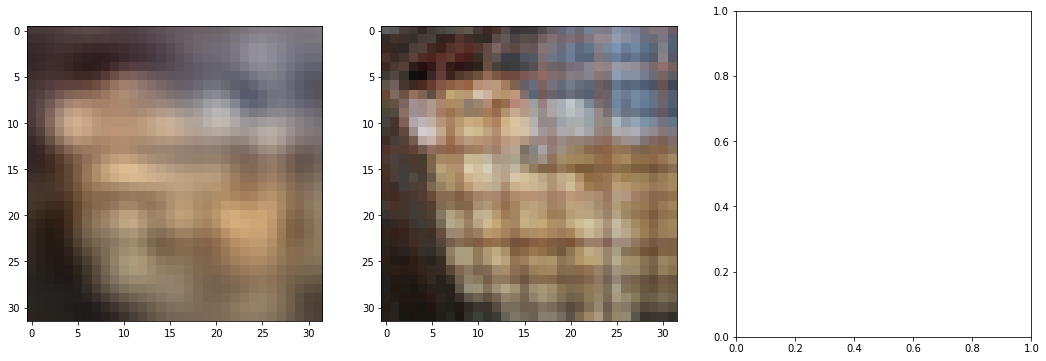

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.005299
tensor(1.0903, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


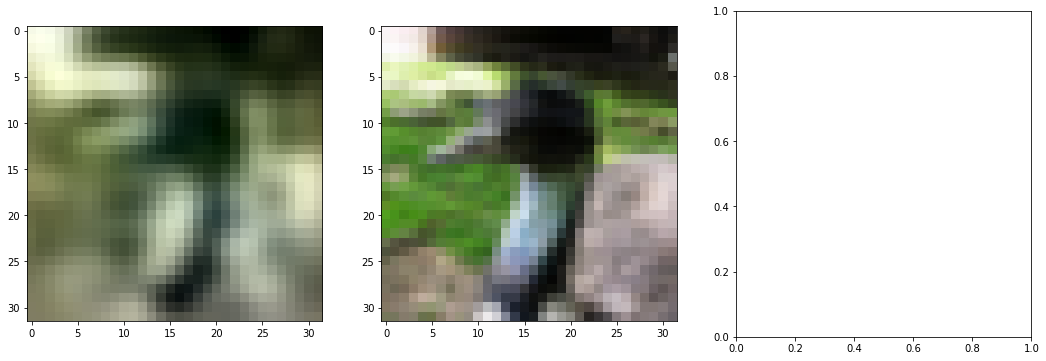

Step 0, Total loss 0.006270
tensor(1.0422, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


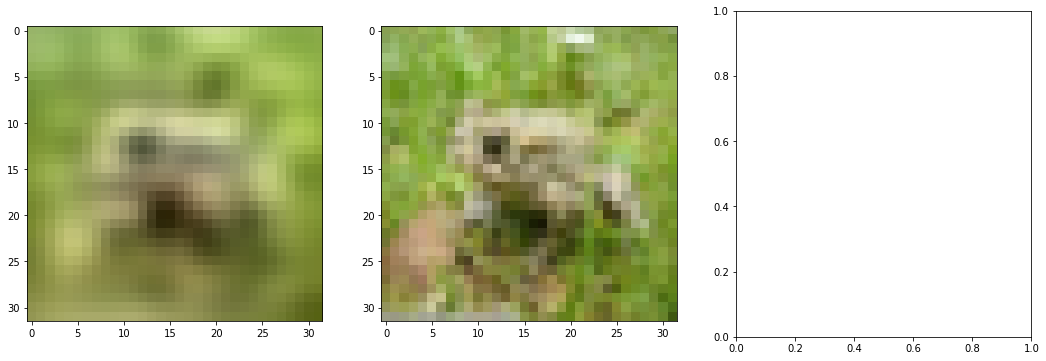

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.005136
tensor(1.0998, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


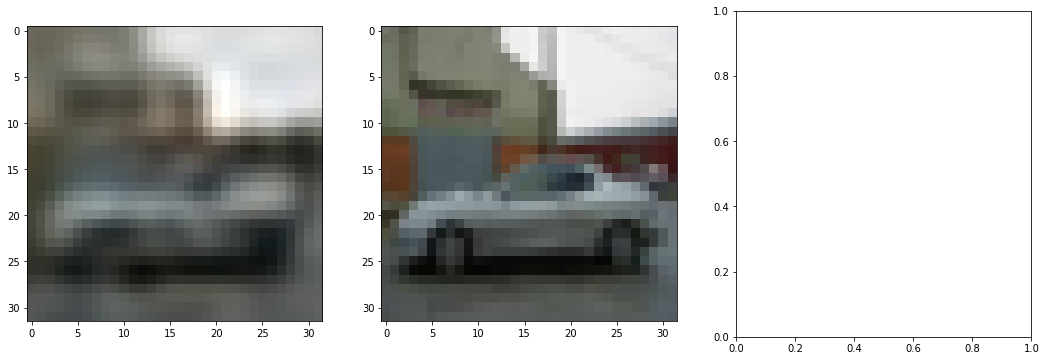

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.005935
tensor(1.1009, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


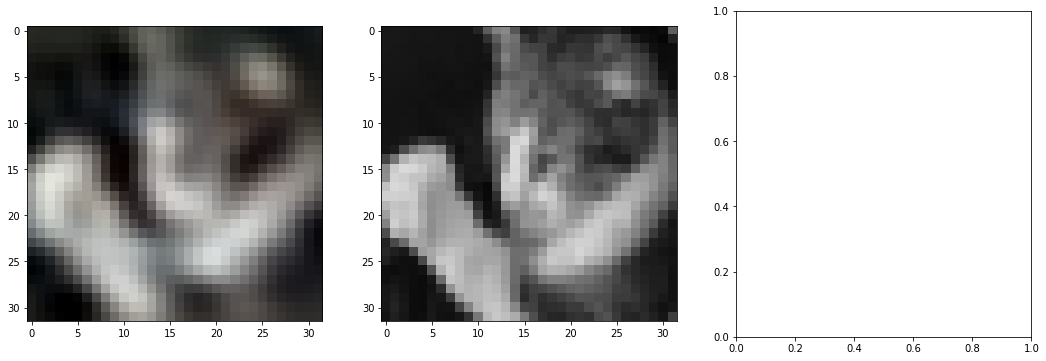

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.006410
tensor(1.1285, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


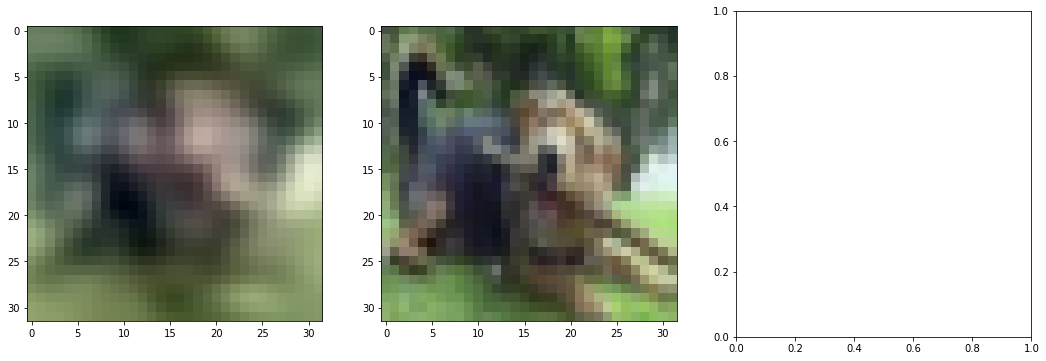

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.005015
tensor(1.1362, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


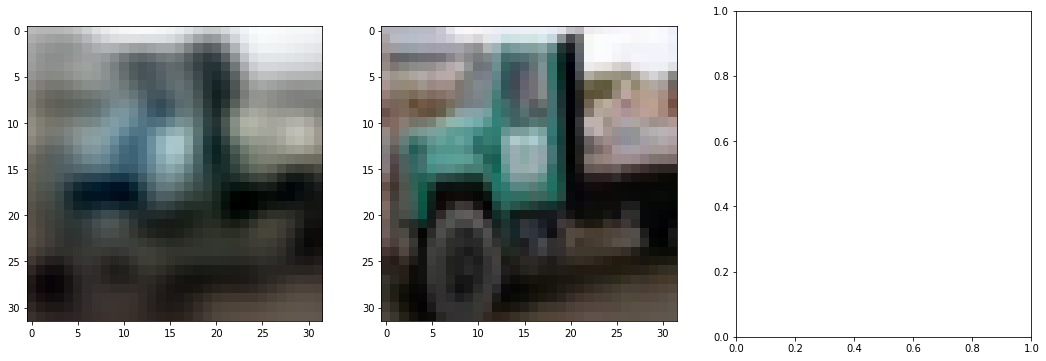

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.005917
tensor(1.1101, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


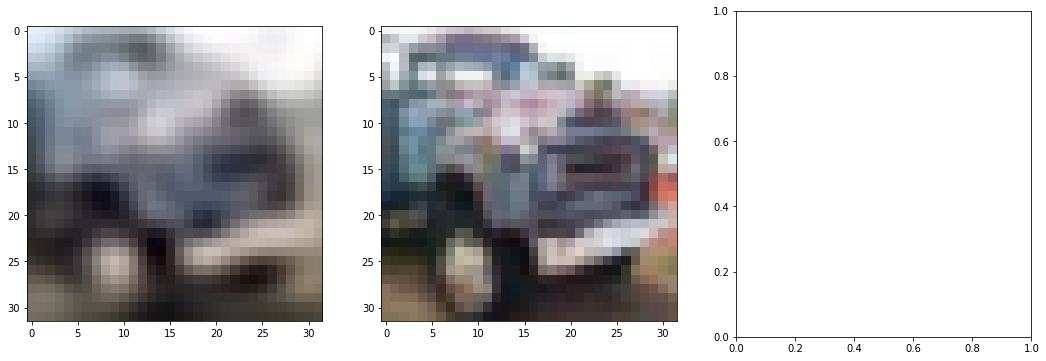

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.006676
tensor(1.1361, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


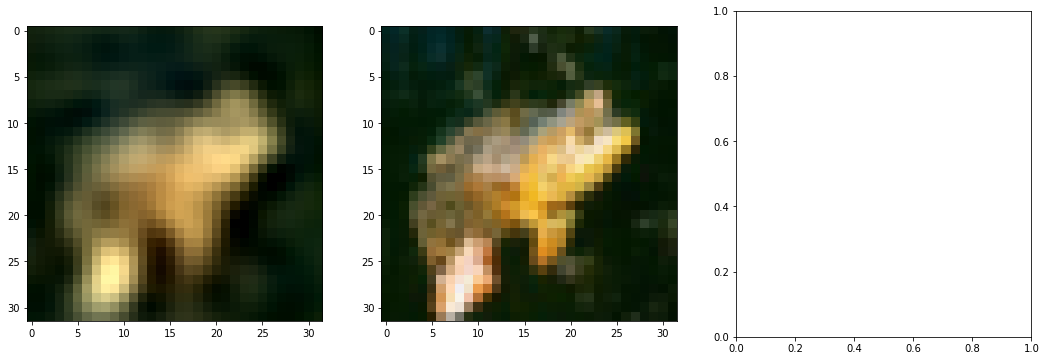

Step 1750, Total loss 0.007345
tensor(1.0773, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


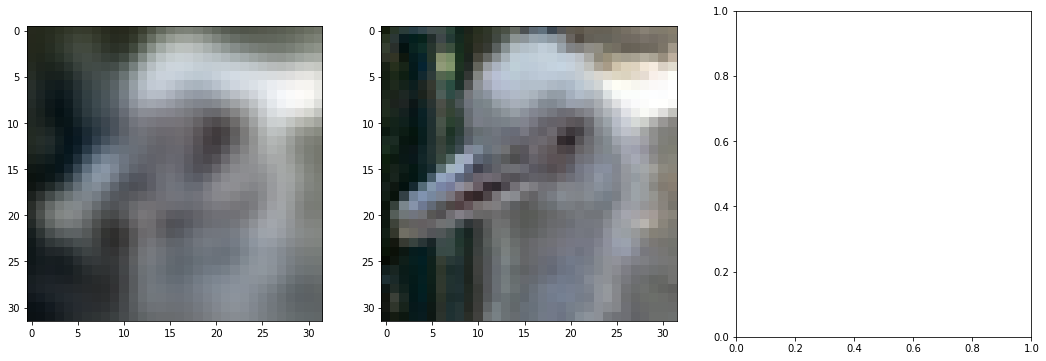

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.005782
tensor(1.1003, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


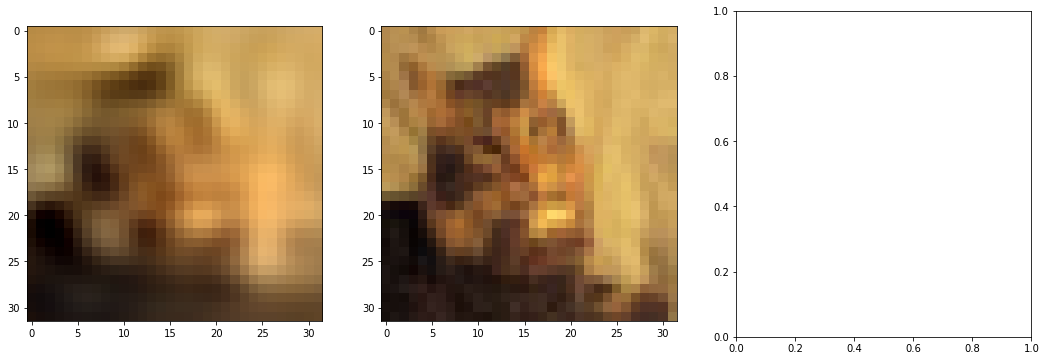

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006693
tensor(1.1215, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


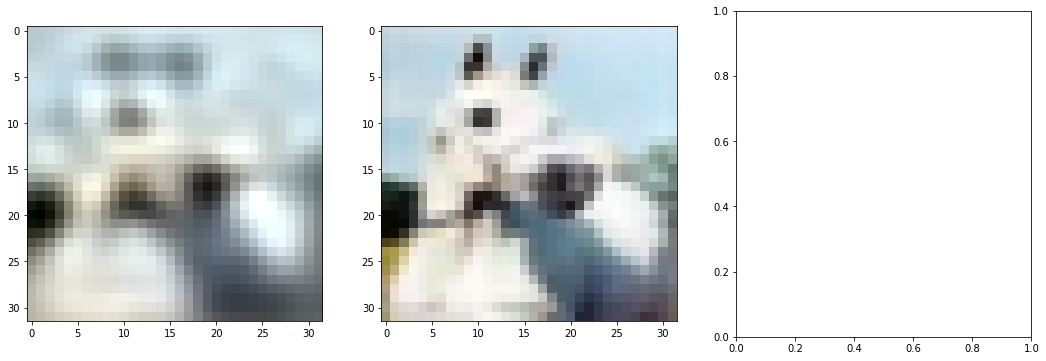

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.006014
tensor(1.2021, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


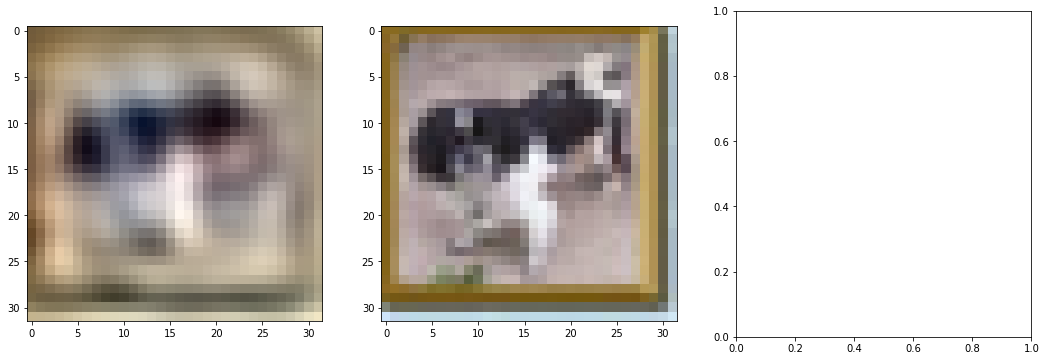

Step 2750, Total loss 0.006854
tensor(1.1192, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


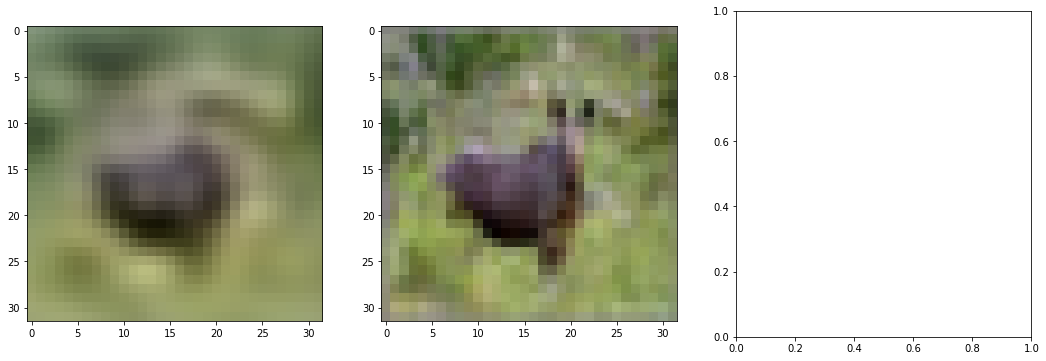

Step 3000, Total loss 0.007132
tensor(1.1273, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


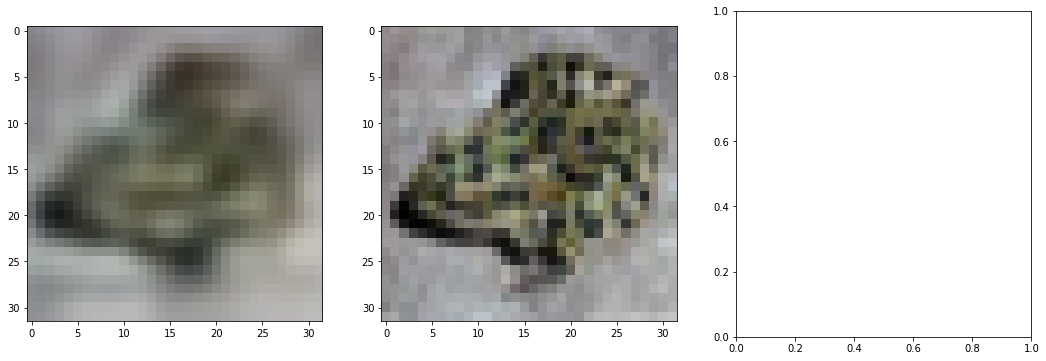

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.006565
tensor(1.1356, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


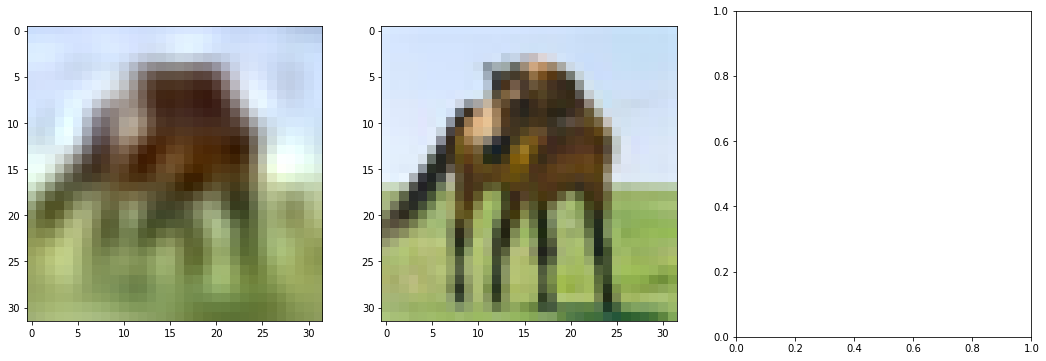

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006581
tensor(1.1192, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


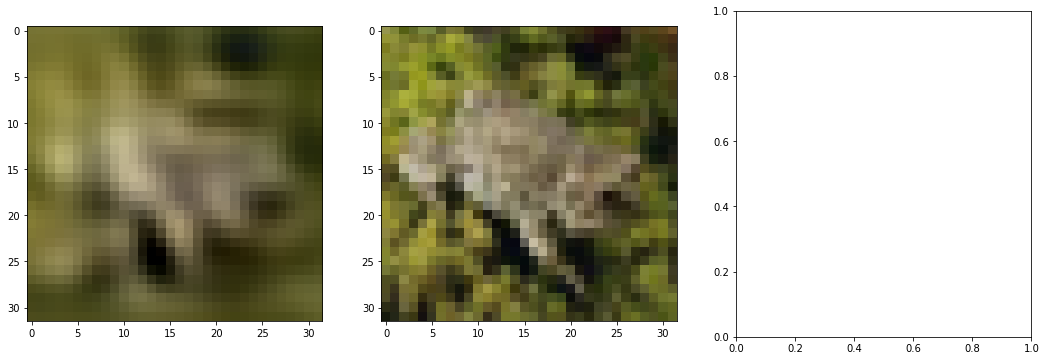

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006190
tensor(1.0899, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


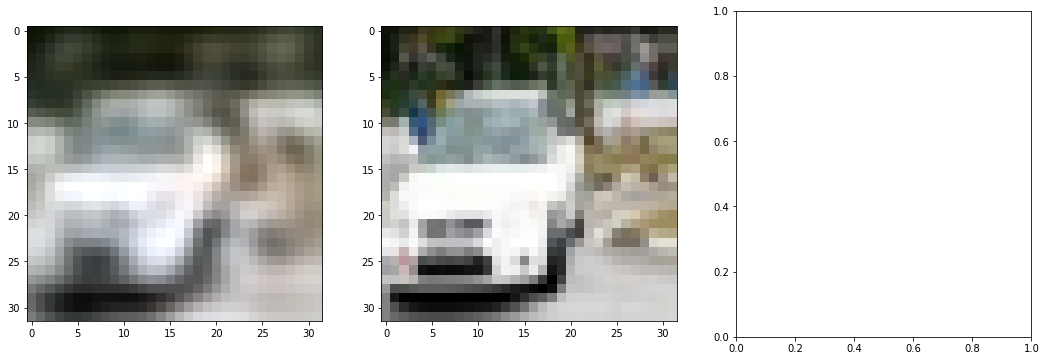

Step 750, Total loss 0.006349
tensor(1.1110, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


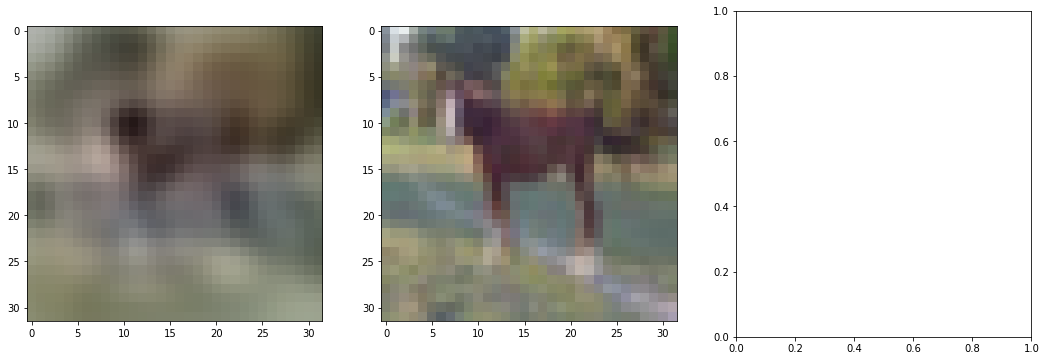

Step 1000, Total loss 0.006273
tensor(1.1188, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


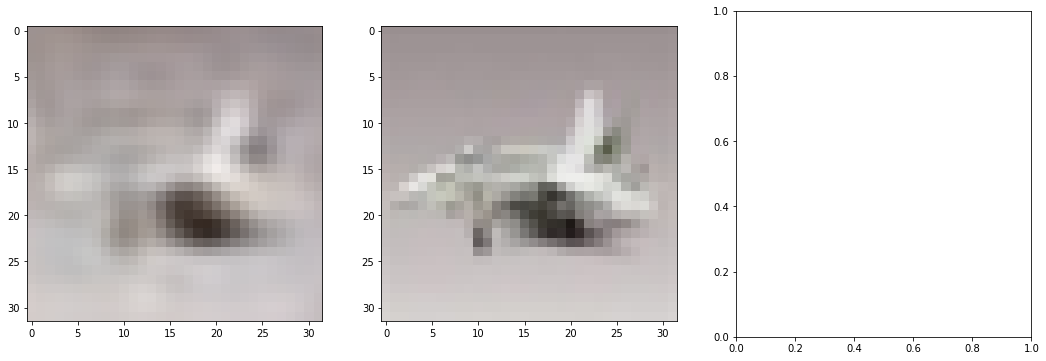

Step 1250, Total loss 0.007636
tensor(1.1427, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


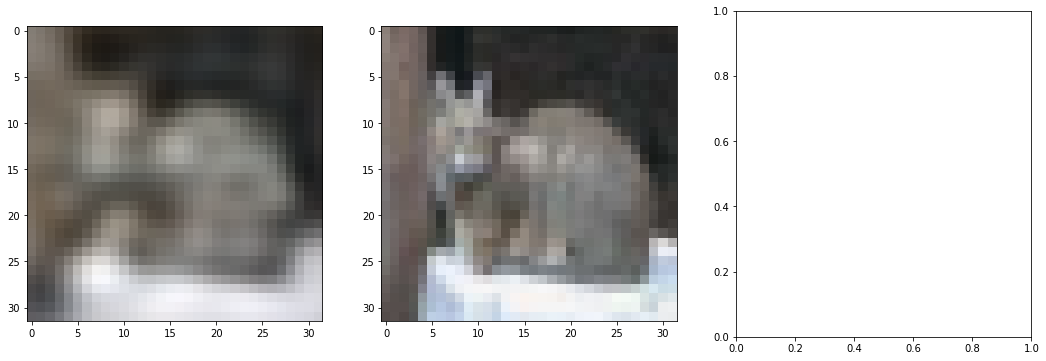

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.005451
tensor(1.1064, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


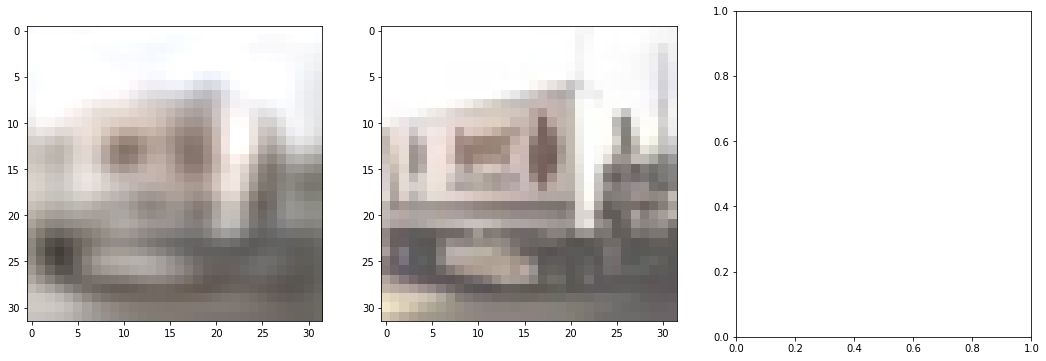

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006934
tensor(1.1978, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


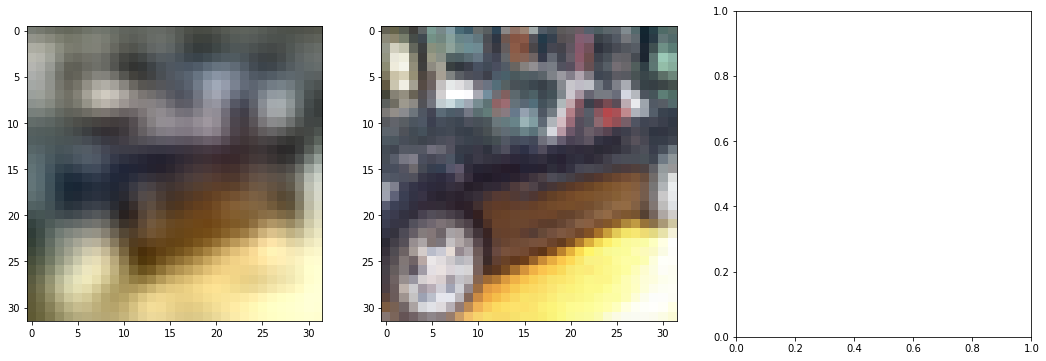

Step 2000, Total loss 0.005576
tensor(1.1214, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


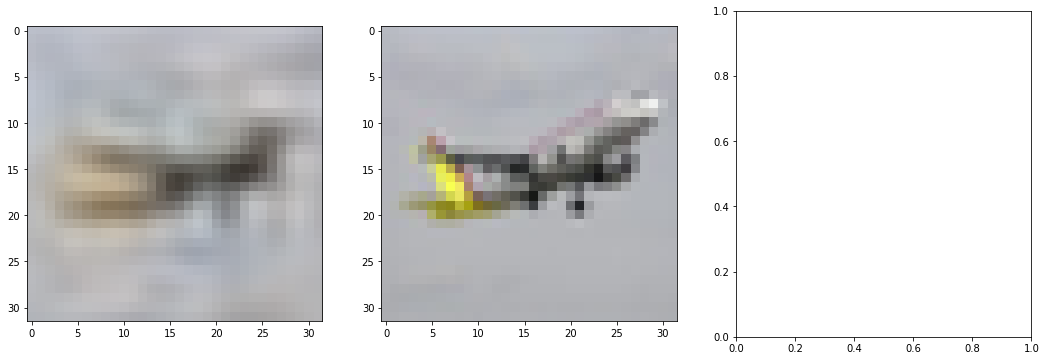

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006369
tensor(1.1213, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


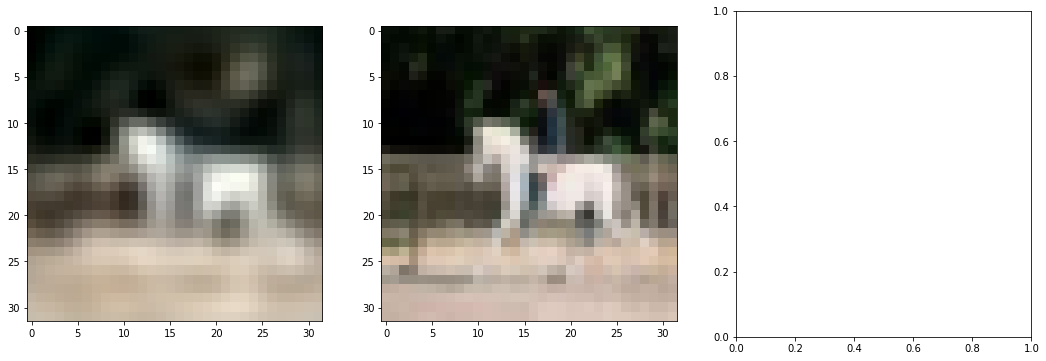

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.006743
tensor(1.1272, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


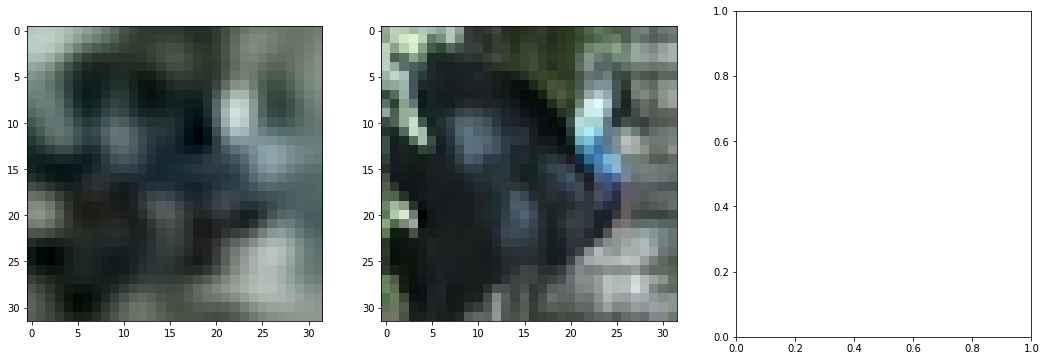

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.005586
tensor(1.0590, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


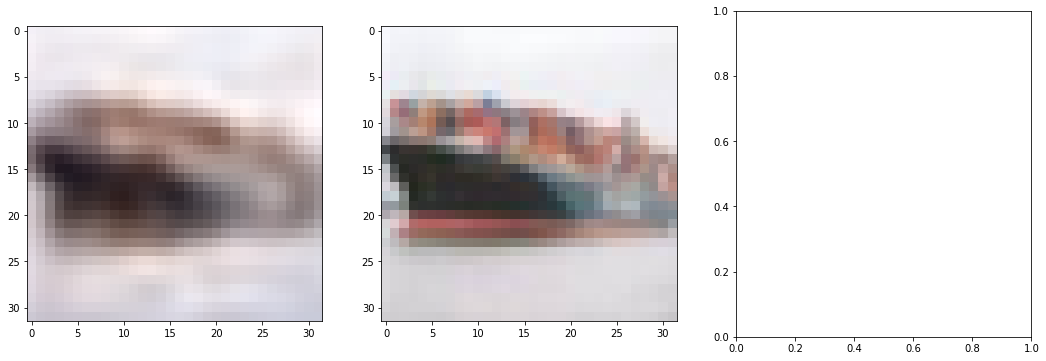

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.005497
tensor(1.1419, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


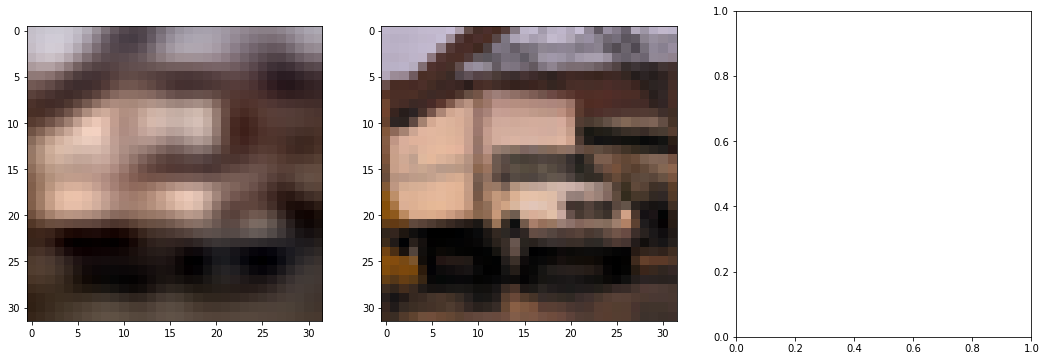

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.005969
tensor(1.2981, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


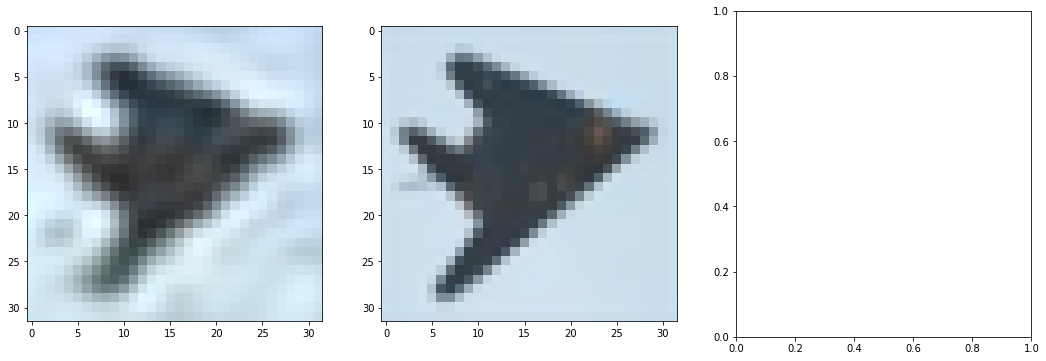

Step 250, Total loss 0.005537
tensor(1.0590, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


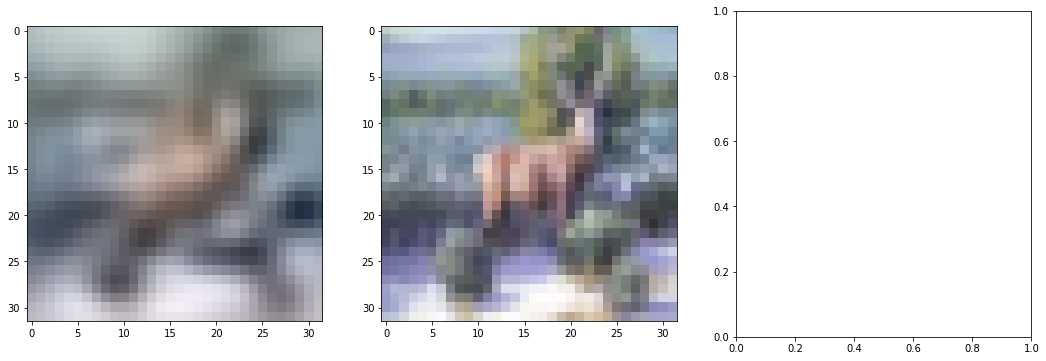

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006138
tensor(1.1001, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


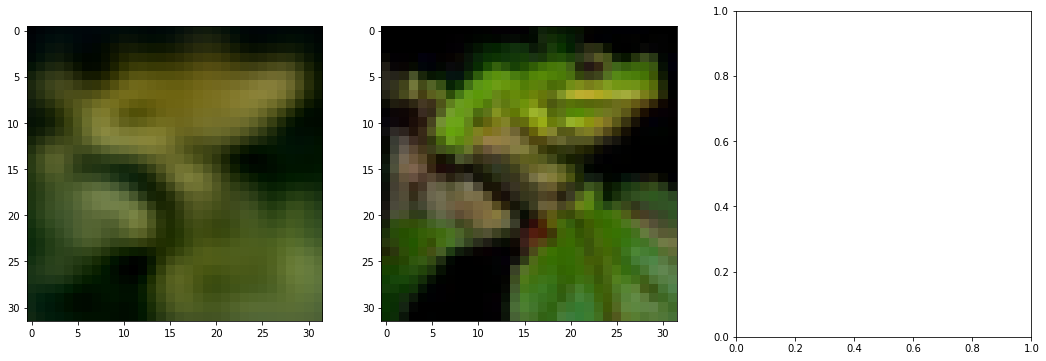

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.005853
tensor(1.1723, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


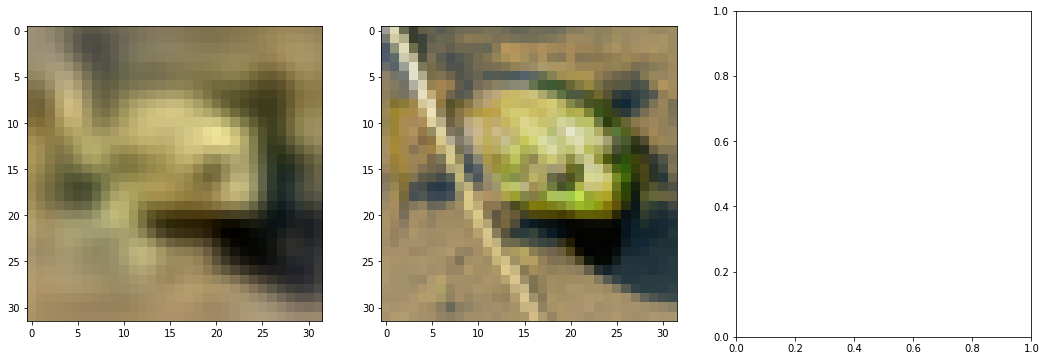

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006094
tensor(1.1189, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


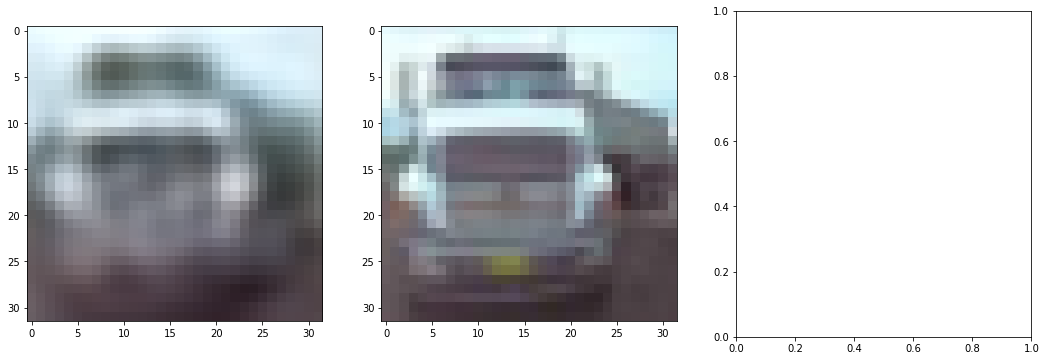

Step 1250, Total loss 0.005507
tensor(1.1817, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


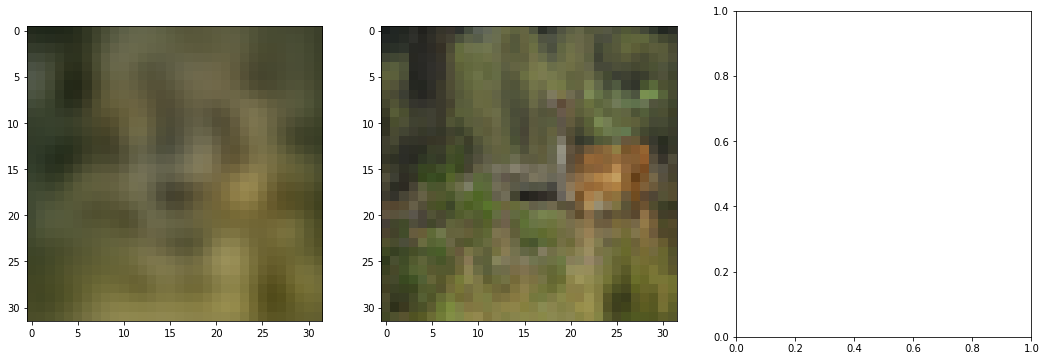

Step 1500, Total loss 0.006623
tensor(1.1562, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


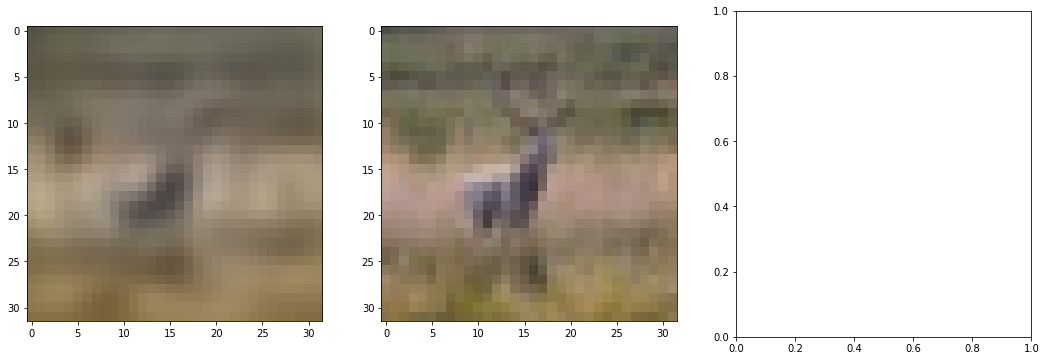

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.005441
tensor(1.1487, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


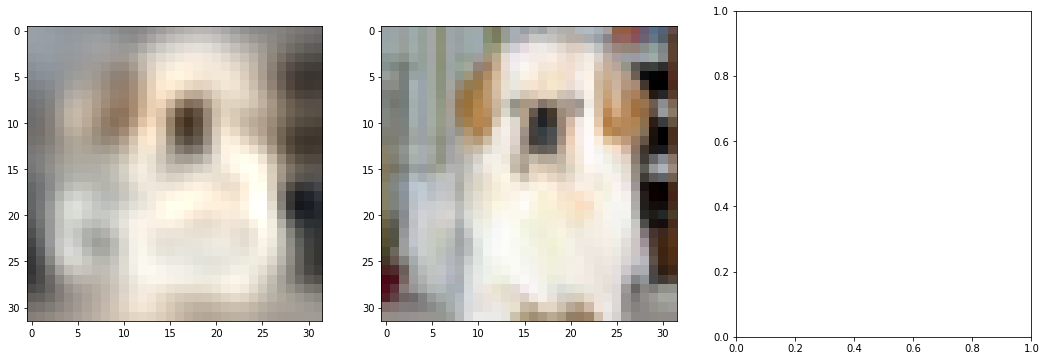

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006968
tensor(1.1392, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


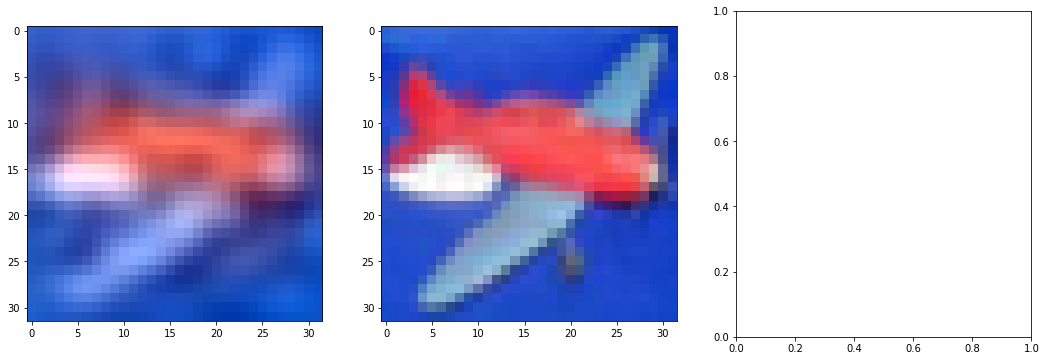

Step 2250, Total loss 0.005726
tensor(1.1110, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


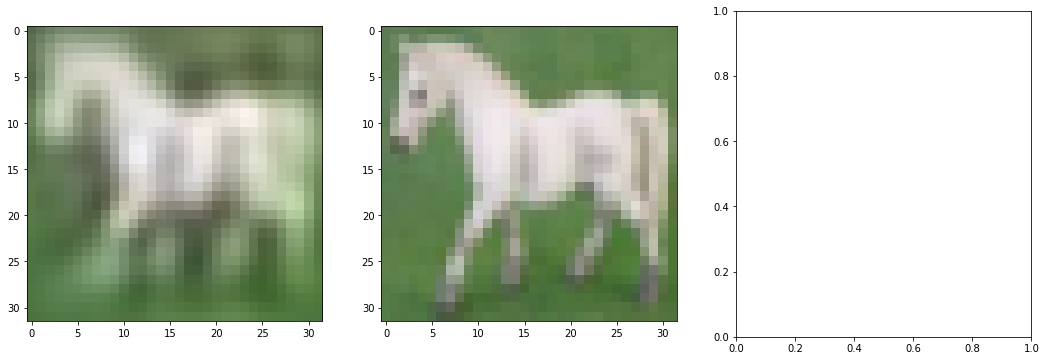

Step 2500, Total loss 0.006397
tensor(1.1421, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


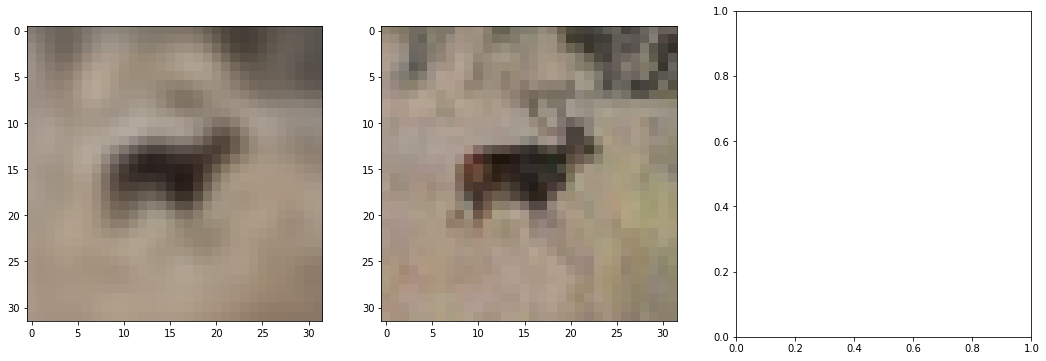

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.006326
tensor(1.1098, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


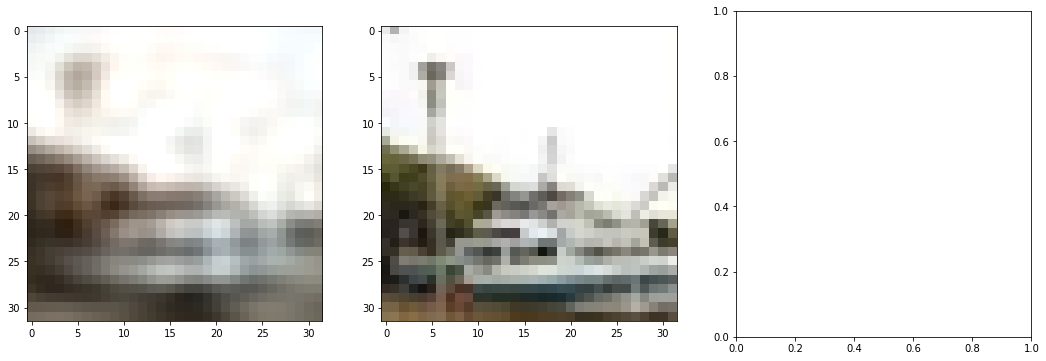

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.006045
tensor(1.0855, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


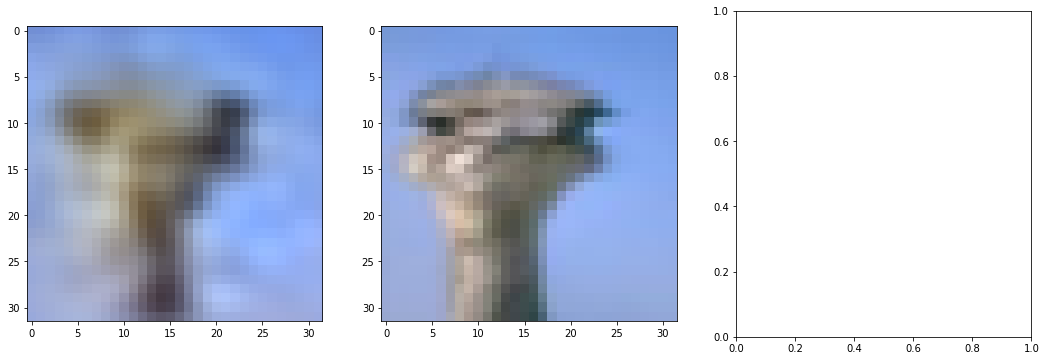

Step 0, Total loss 0.005540
tensor(1.1407, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


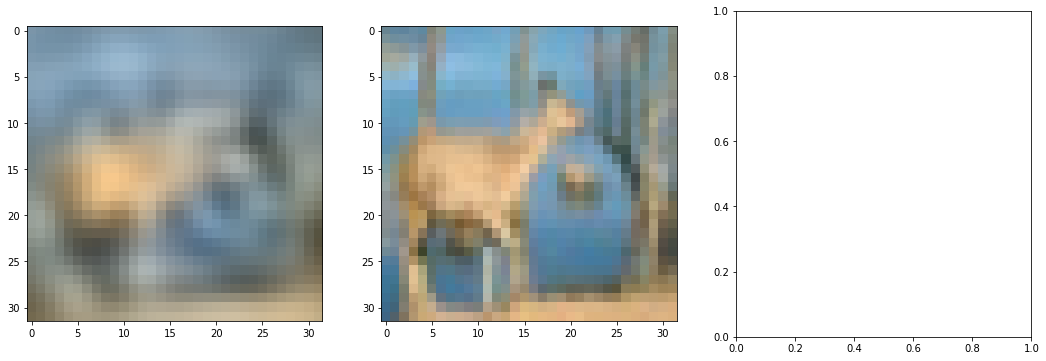

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.005840
tensor(1.1194, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


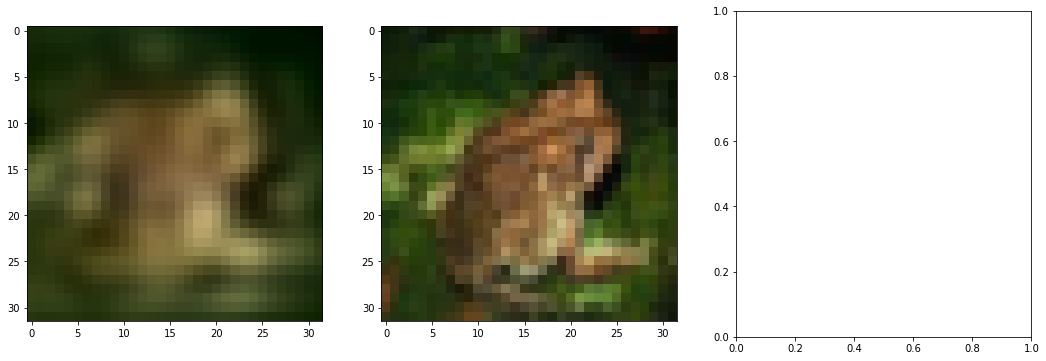

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.007666
tensor(1.1352, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


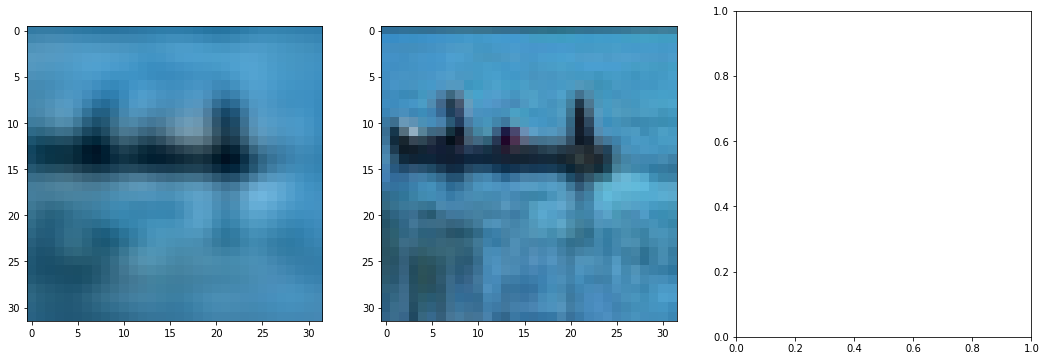

Step 750, Total loss 0.006161
tensor(1.1928, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


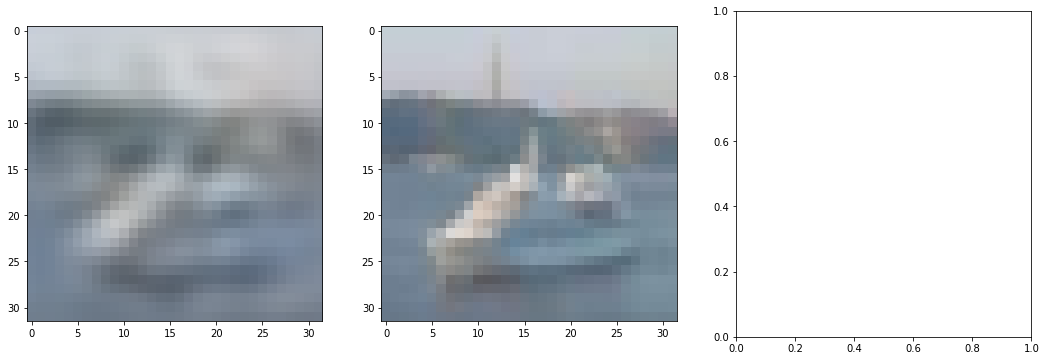

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.005754
tensor(1.0555, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


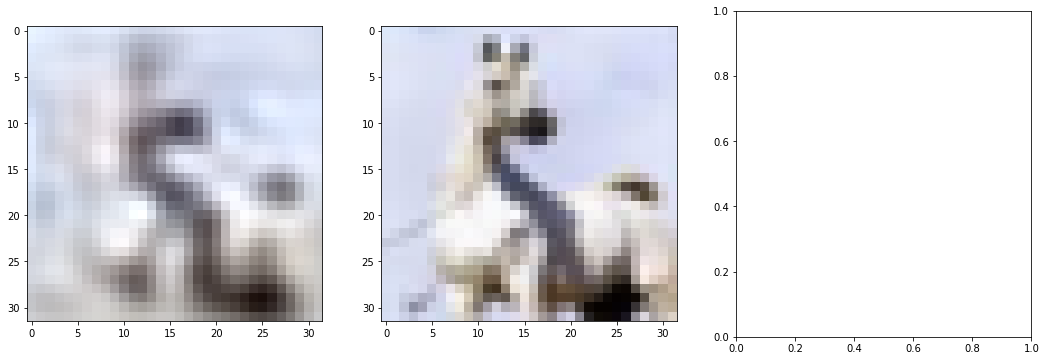

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.005888
tensor(1.1382, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


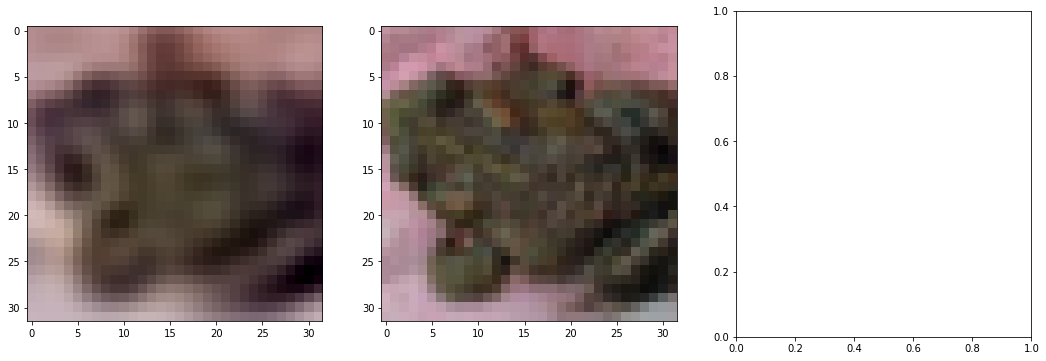

Step 1500, Total loss 0.006027
tensor(1.1396, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


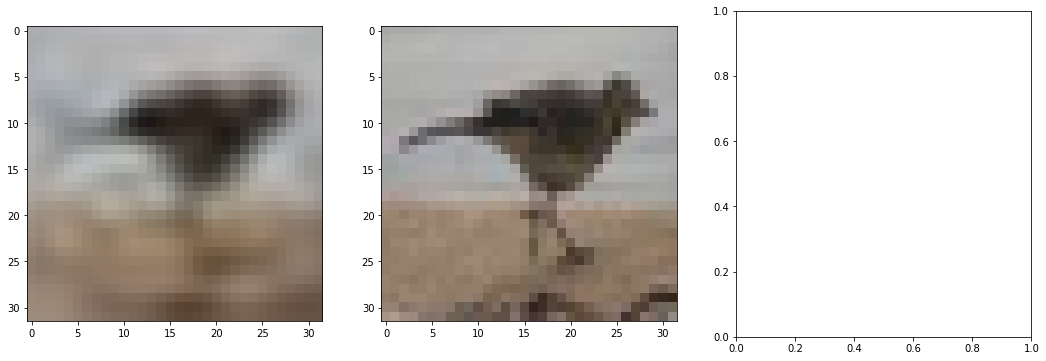

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006573
tensor(1.1026, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


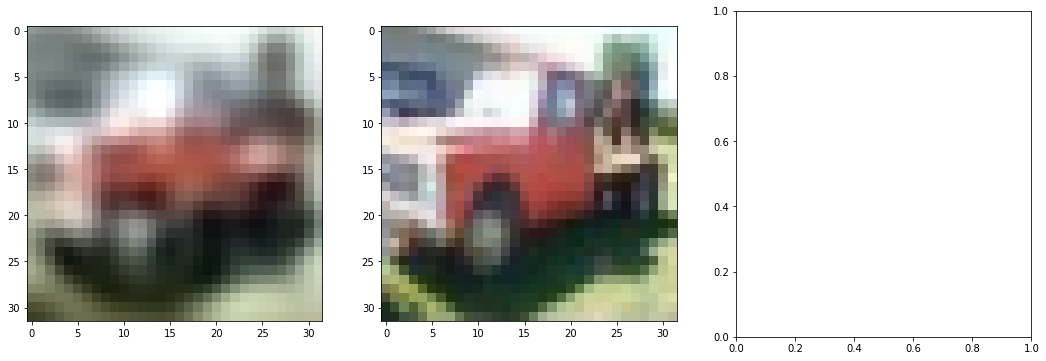

Step 2000, Total loss 0.006091
tensor(1.1405, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


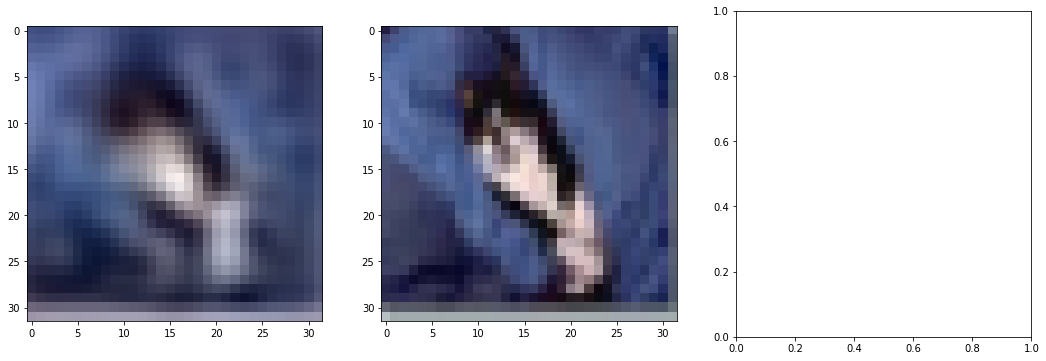

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006415
tensor(1.1291, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


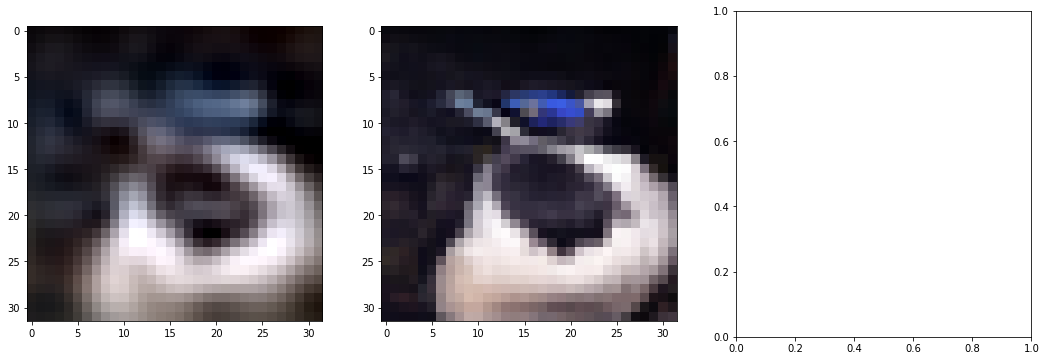

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.006456
tensor(1.1106, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


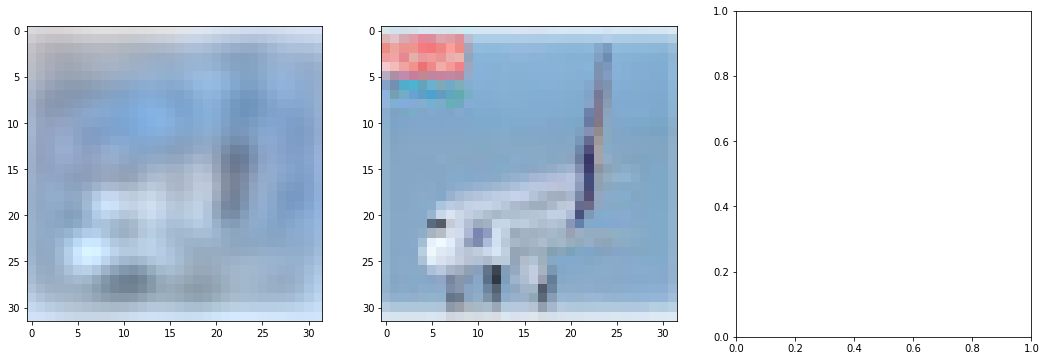

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.006223
tensor(1.1218, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


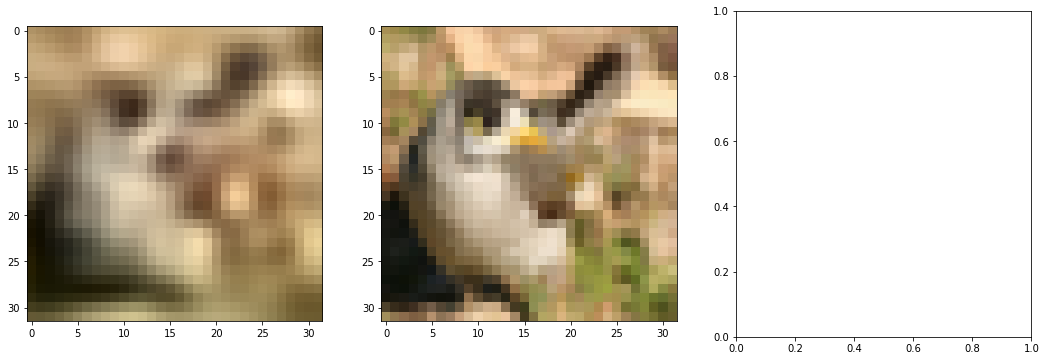

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.006943
tensor(1.1423, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


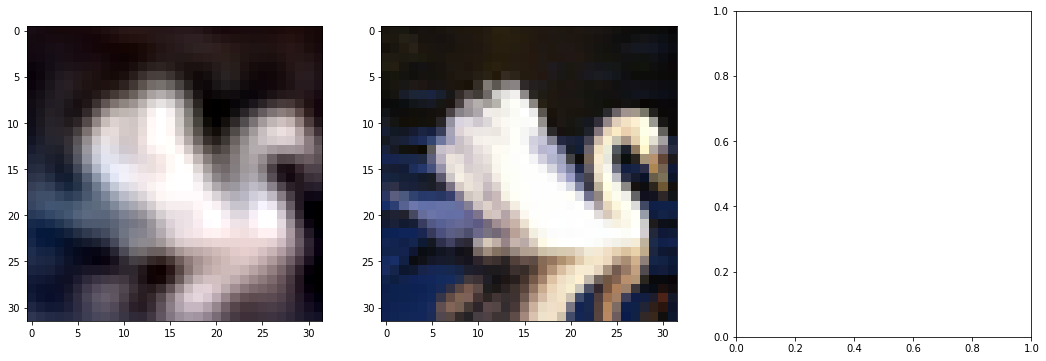

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.007023
tensor(1.1015, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


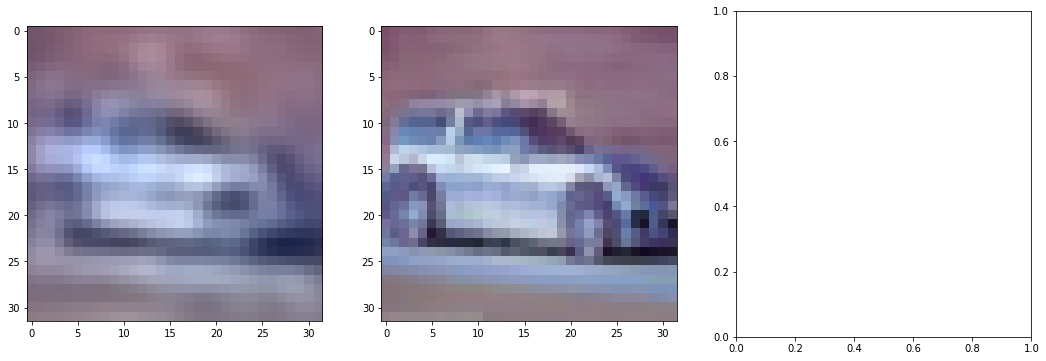

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.005675
tensor(1.1045, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


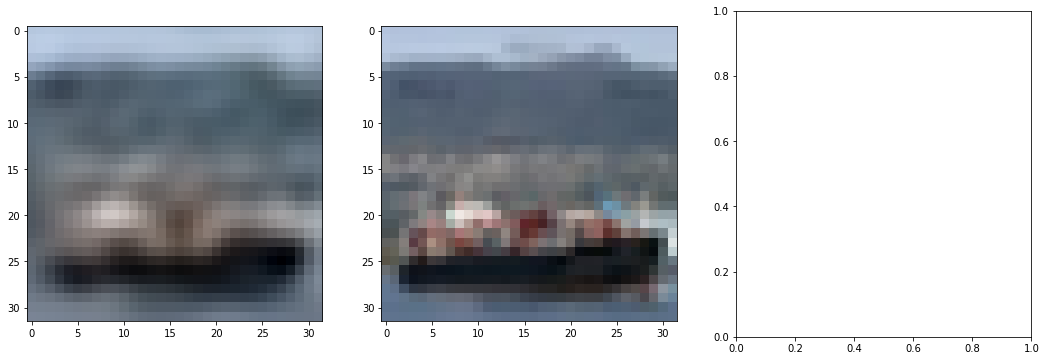

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.006133
tensor(1.2363, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


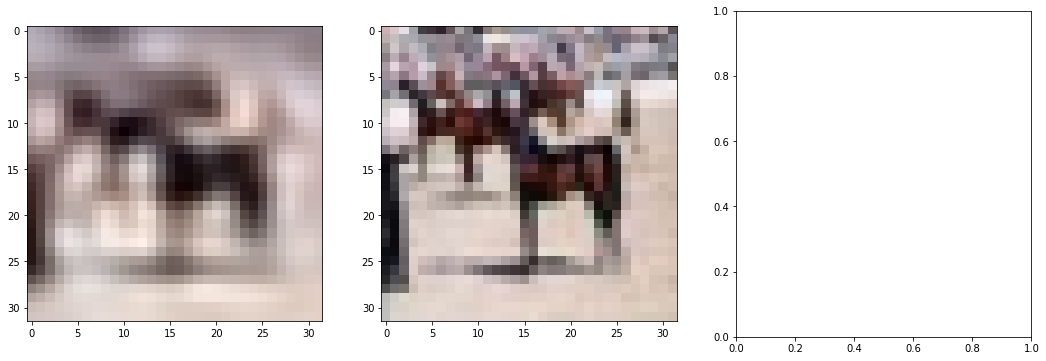

Step 750, Total loss 0.005380
tensor(1.1338, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


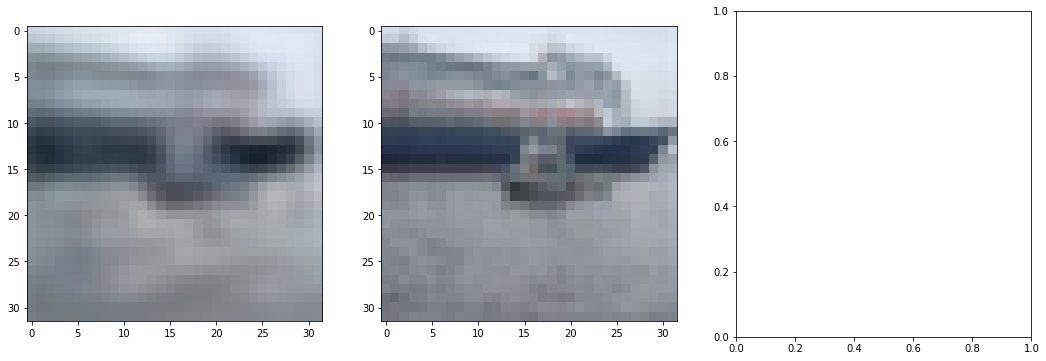

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.004940
tensor(1.1153, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


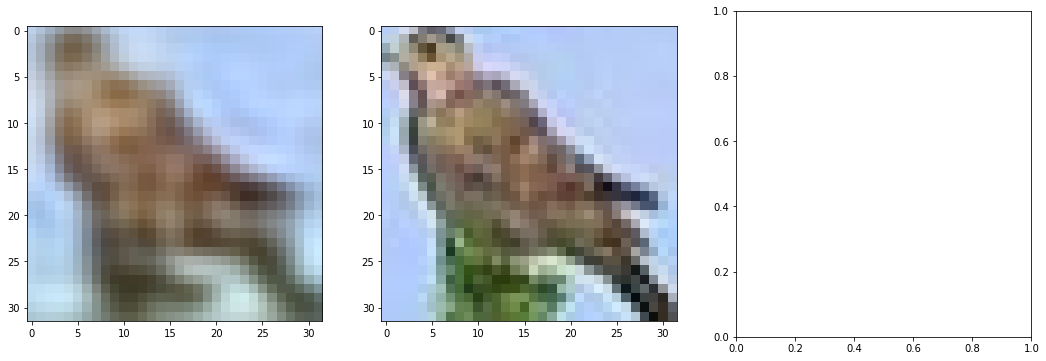

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.005727
tensor(1.1017, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


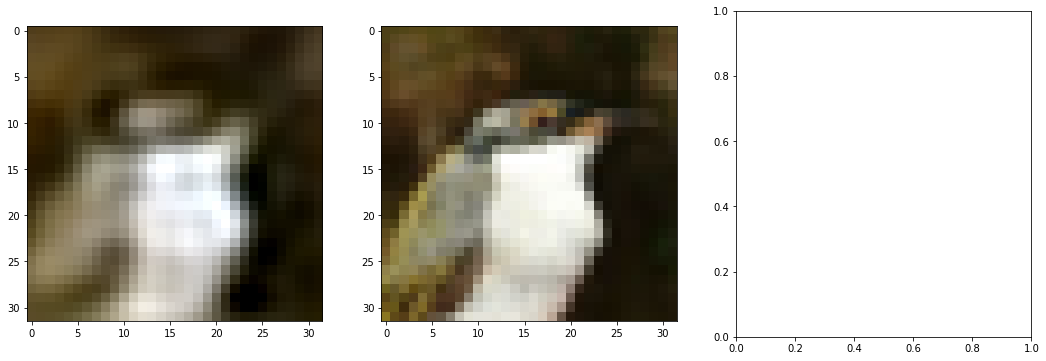

Step 1500, Total loss 0.006406
tensor(1.1444, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


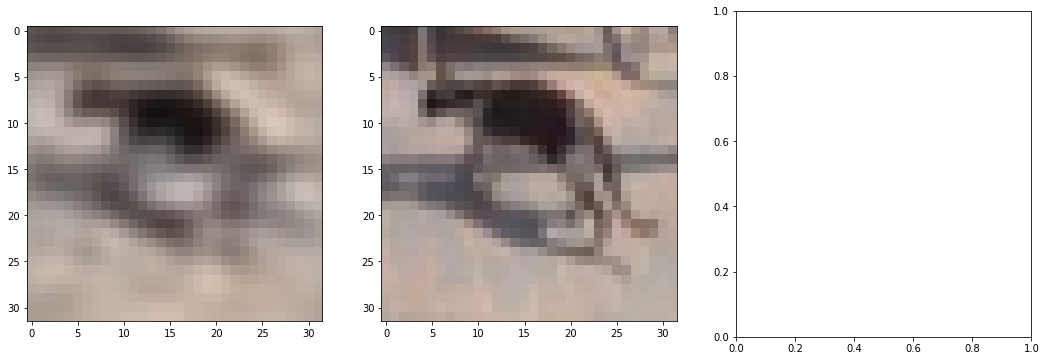

Step 1750, Total loss 0.006753
tensor(1.1442, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


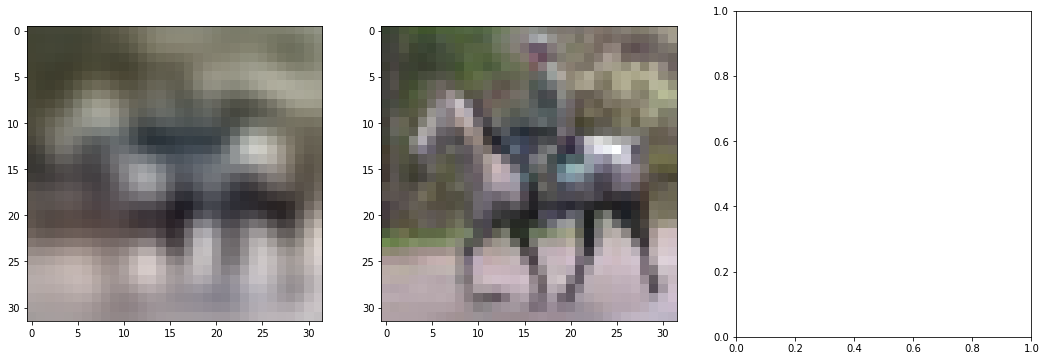

Step 2000, Total loss 0.007222
tensor(1.1064, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


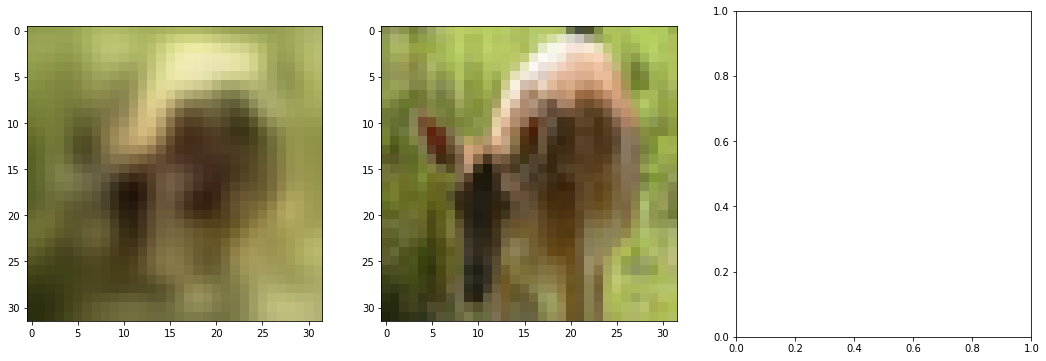

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.006006
tensor(1.1504, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


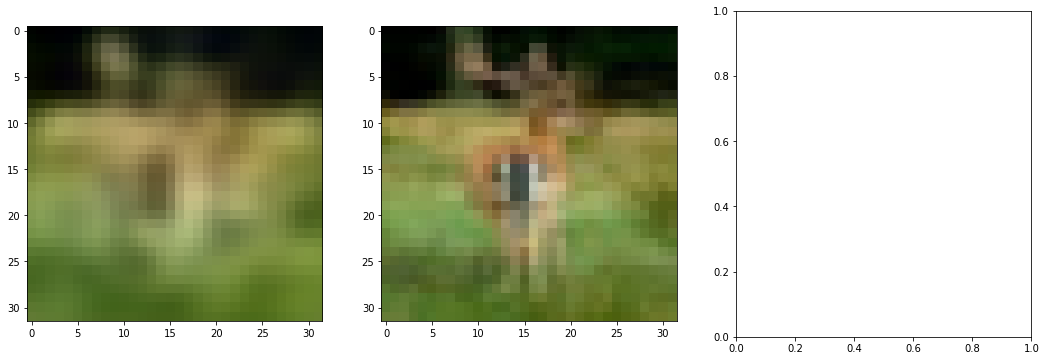

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.005579
tensor(1.1393, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


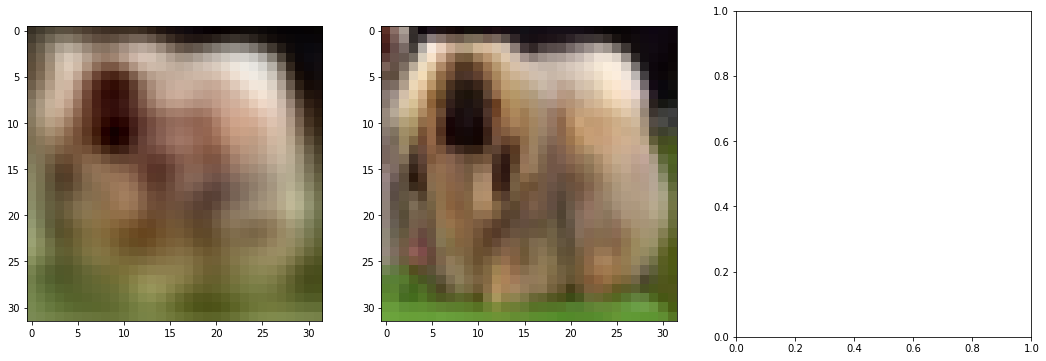

Step 2750, Total loss 0.007279
tensor(1.1303, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


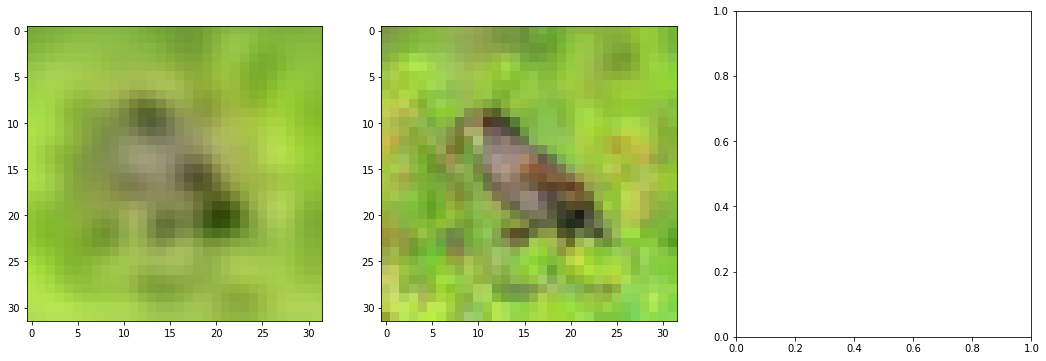

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.006135
tensor(1.1350, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


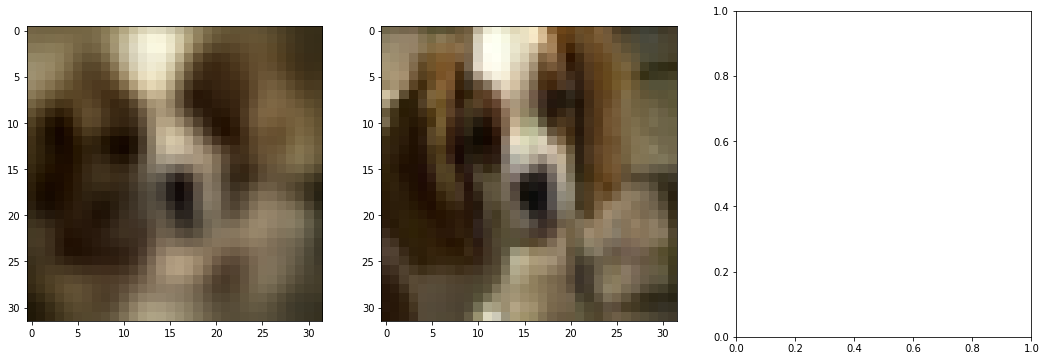

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.005058
tensor(1.0907, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


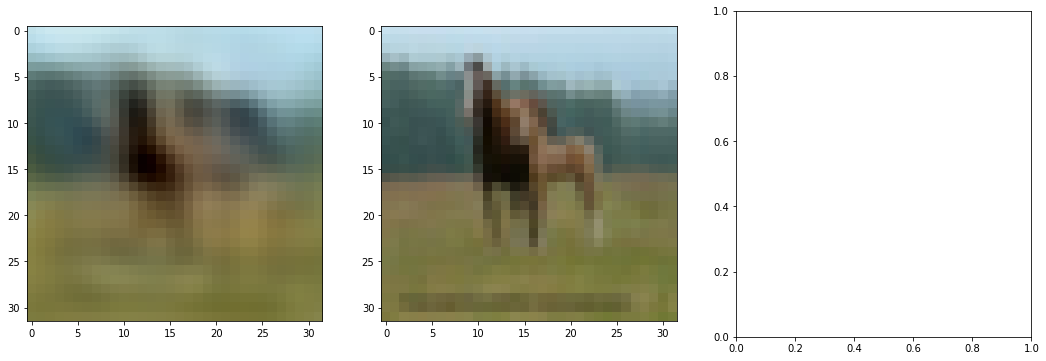

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.007650
tensor(1.1536, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


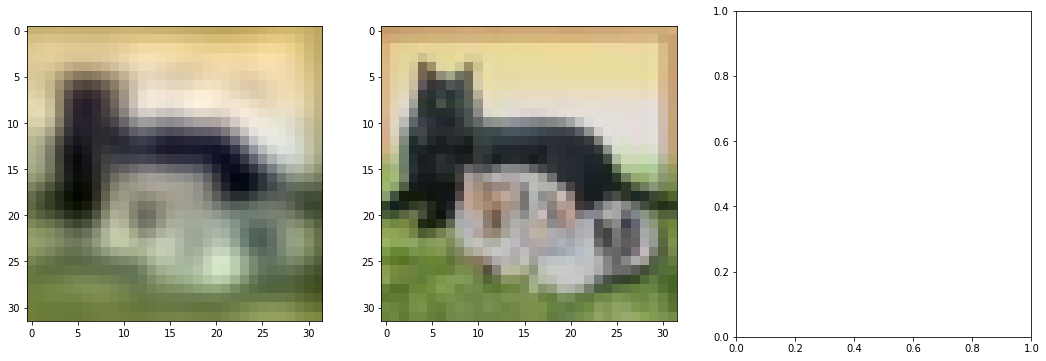

Step 500, Total loss 0.008407
tensor(1.1853, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


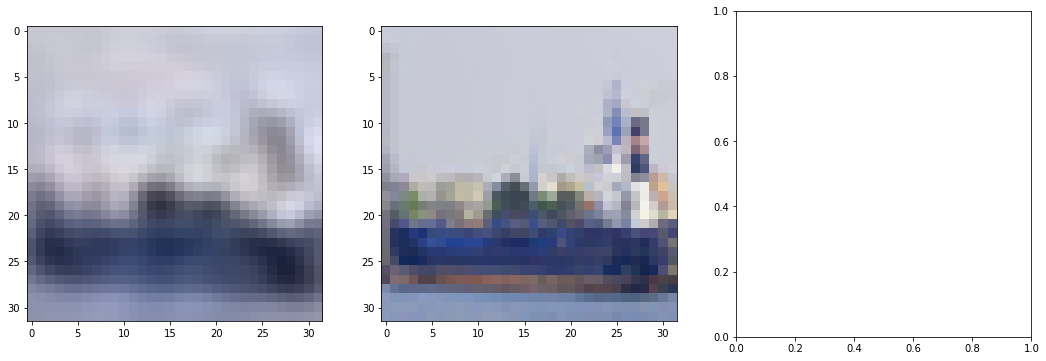

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.005749
tensor(1.0785, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


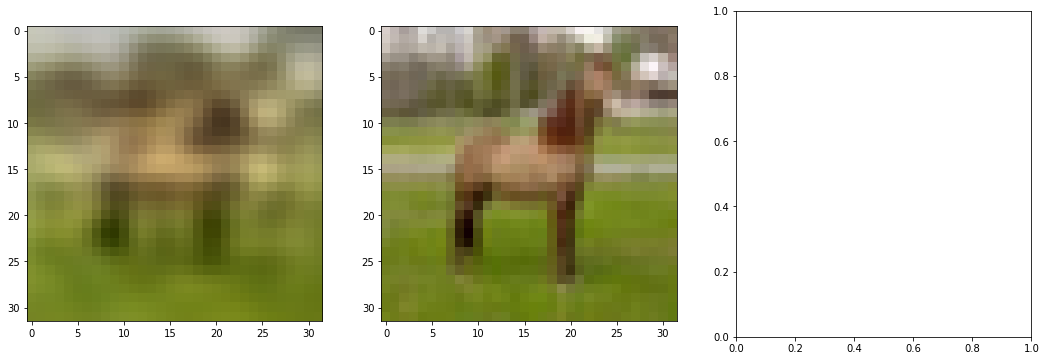

Step 1000, Total loss 0.006790
tensor(1.1356, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


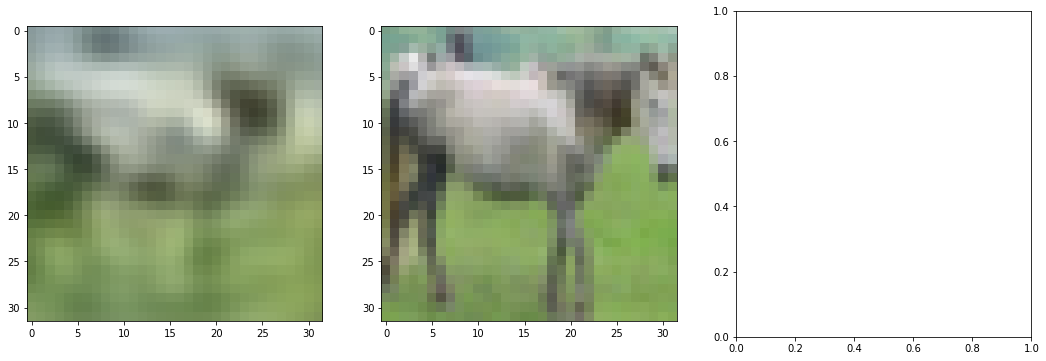

Step 1250, Total loss 0.007419
tensor(1.1263, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


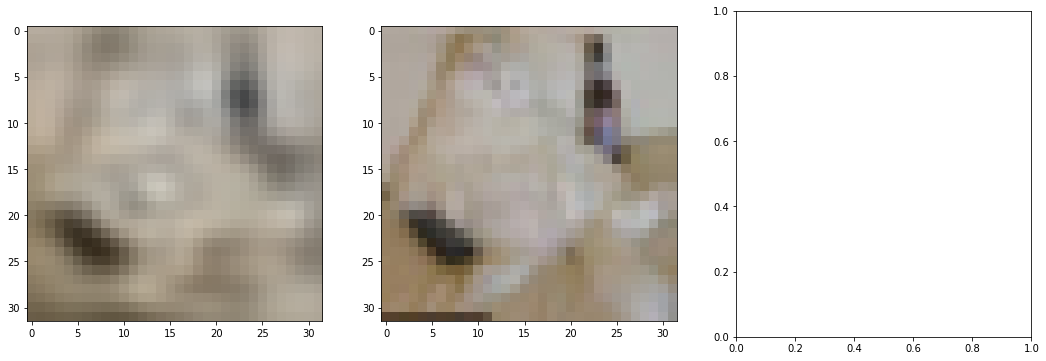

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.005484
tensor(1.1030, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


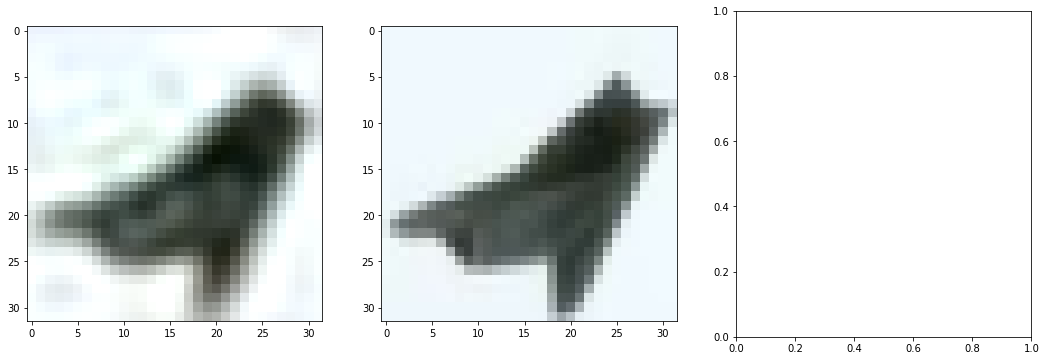

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006200
tensor(1.2154, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


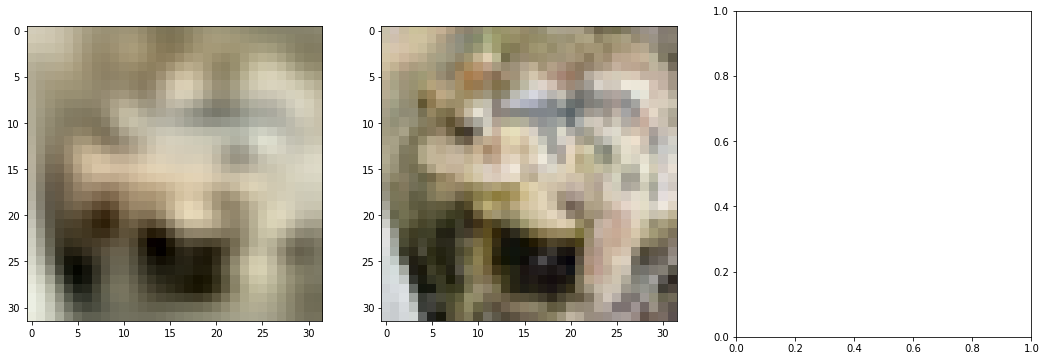

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.005978
tensor(1.2467, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


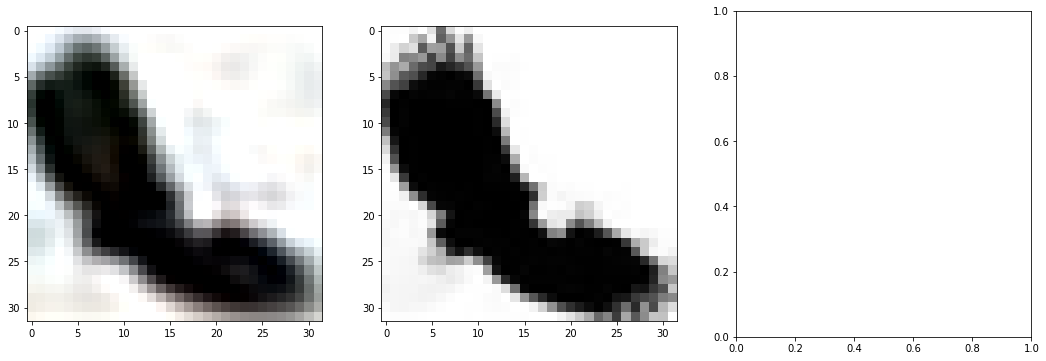

Step 2250, Total loss 0.006512
tensor(1.1012, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


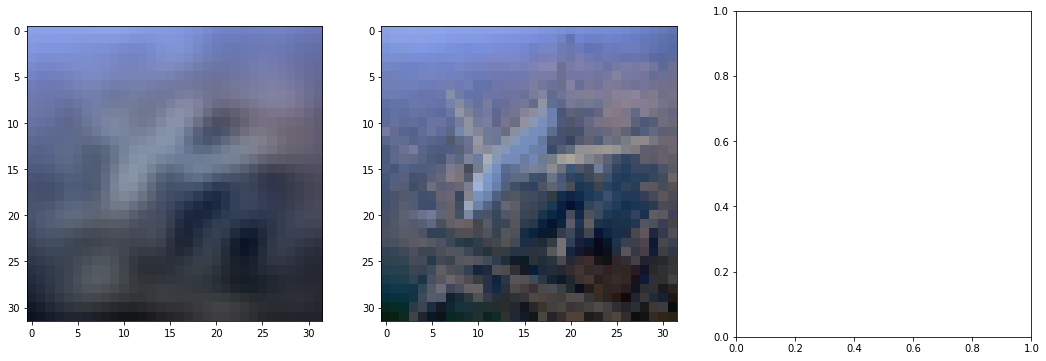

Step 2500, Total loss 0.006169
tensor(1.0933, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


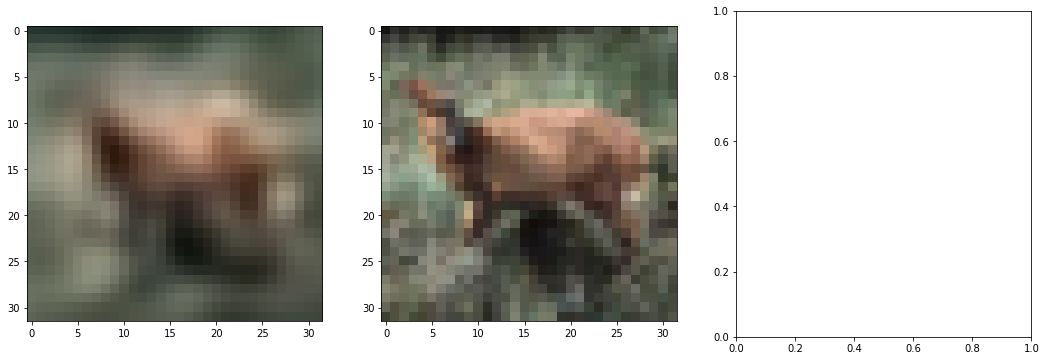

Step 2750, Total loss 0.006188
tensor(1.1531, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


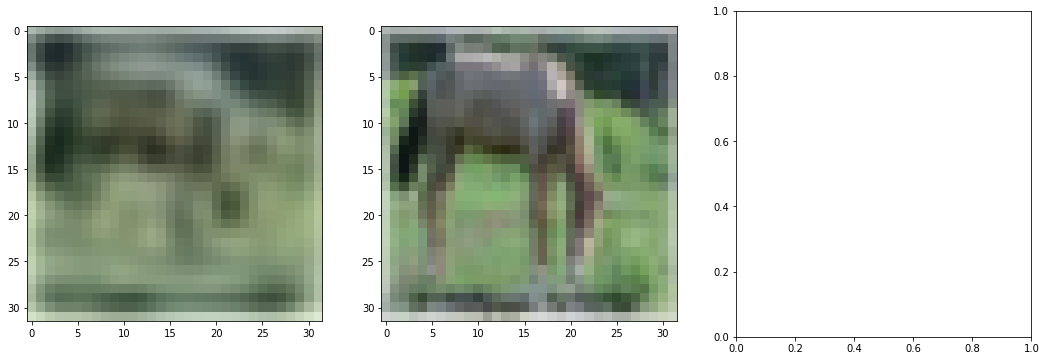

Step 3000, Total loss 0.005924
tensor(1.1623, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


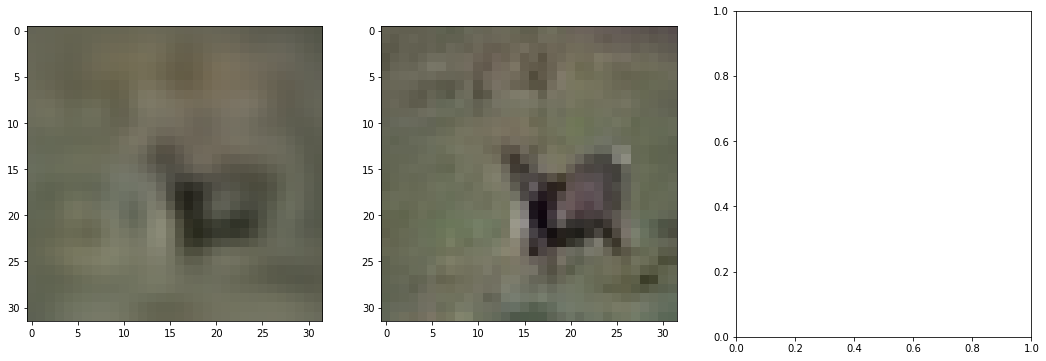

Step 0, Total loss 0.005960
tensor(1.1132, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


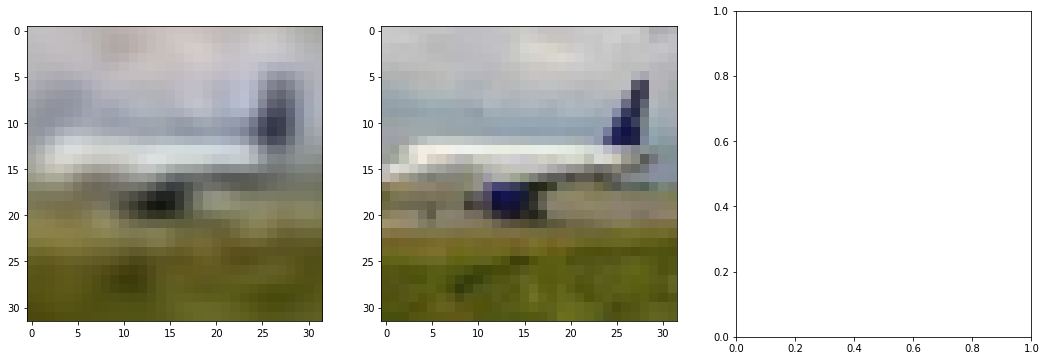

Step 250, Total loss 0.006226
tensor(1.1890, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


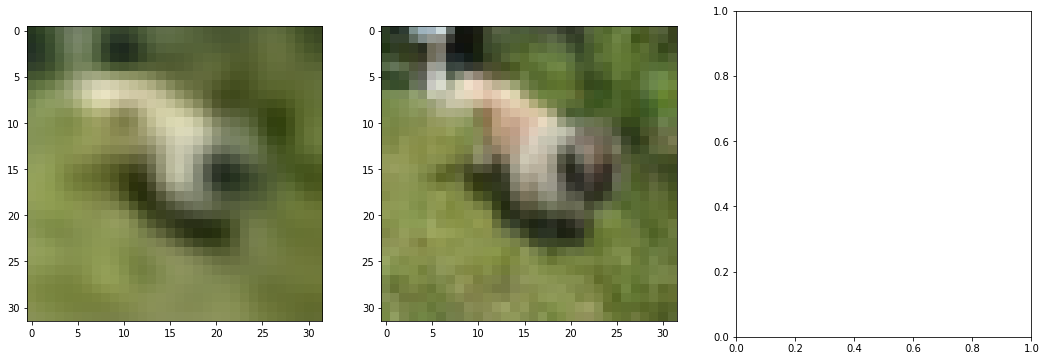

Step 500, Total loss 0.004755
tensor(1.1339, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


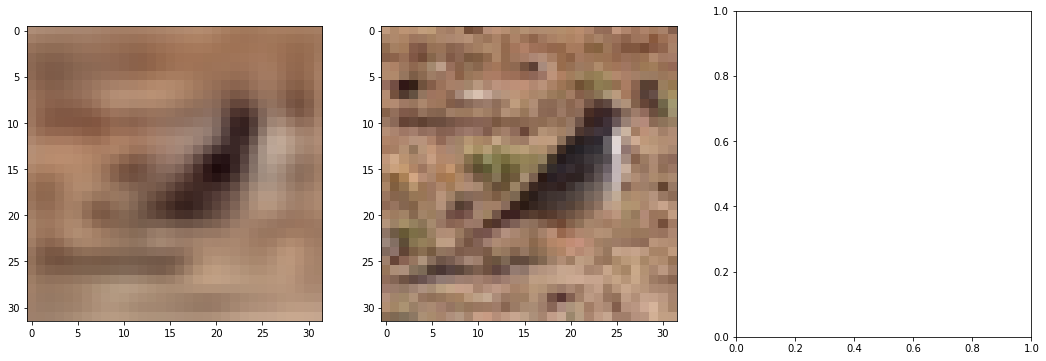

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.005547
tensor(1.0831, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


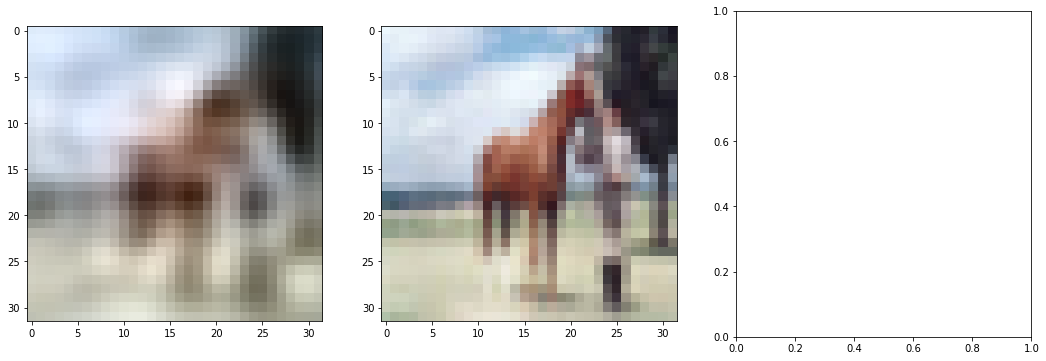

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006142
tensor(1.1220, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


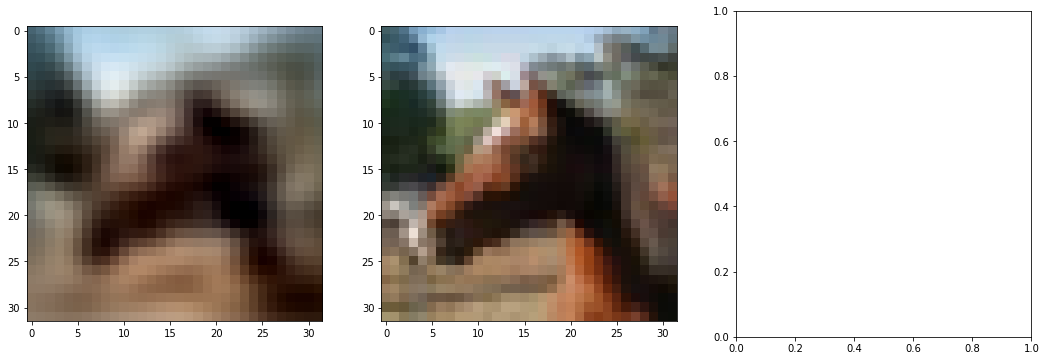

Step 1250, Total loss 0.006379
tensor(1.1209, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


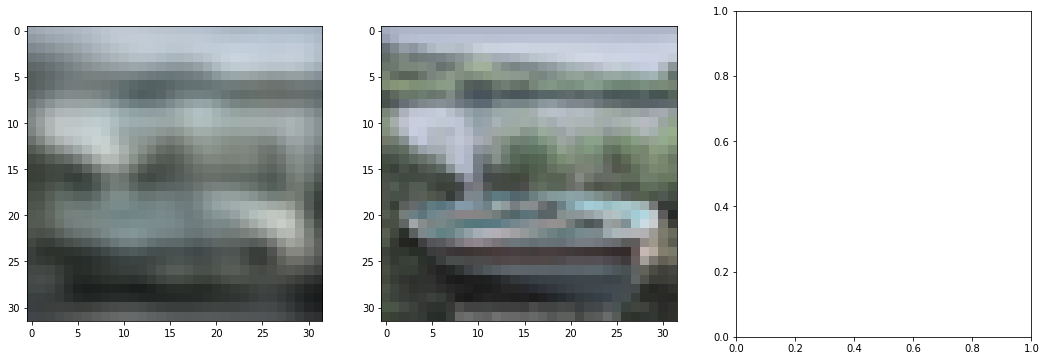

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.005568
tensor(1.1342, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


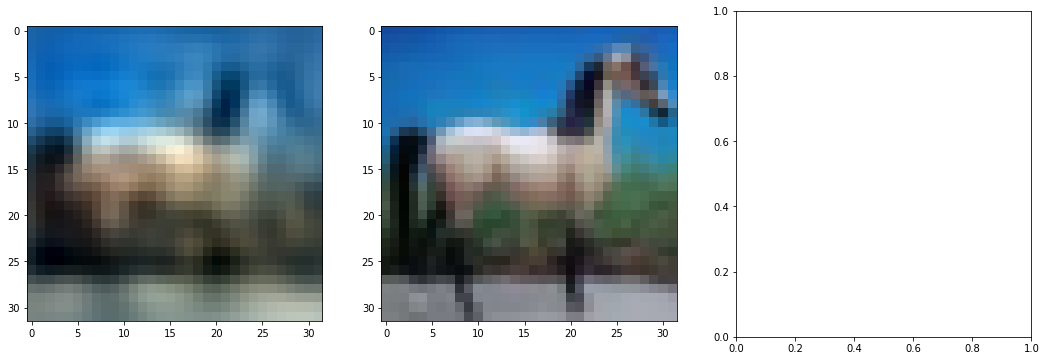

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.004985
tensor(1.0968, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


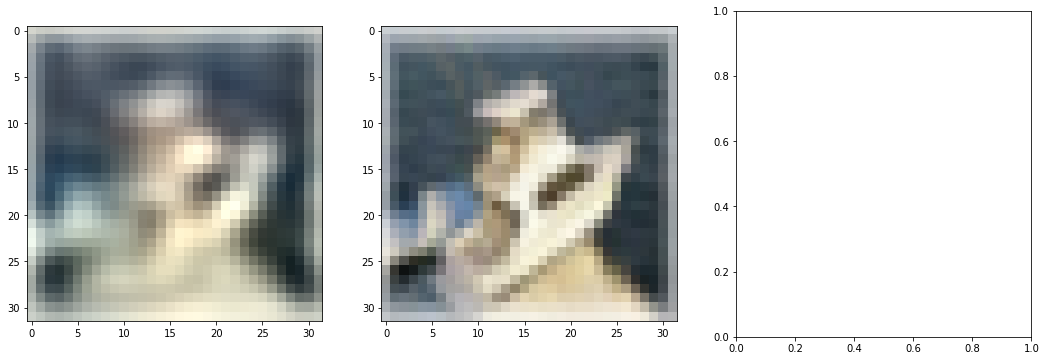

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006846
tensor(1.1024, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


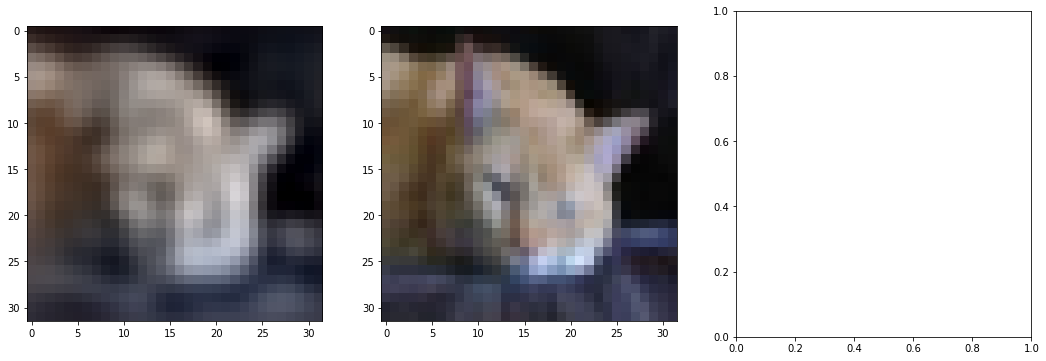

Step 2250, Total loss 0.006203
tensor(1.2003, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


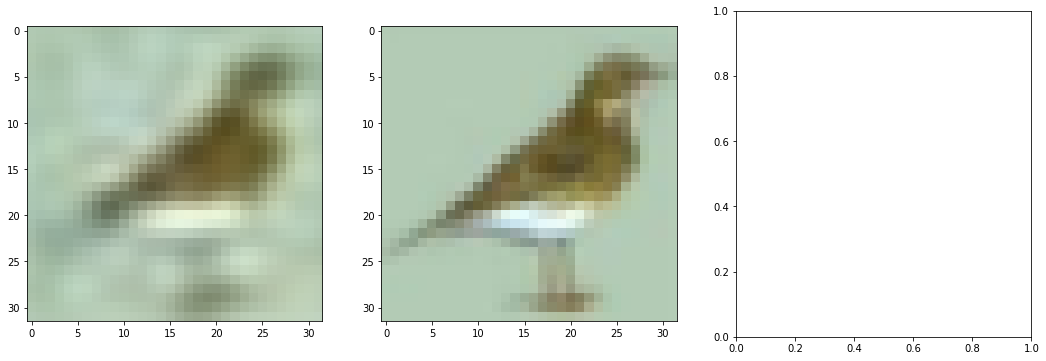

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.005225
tensor(1.0536, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


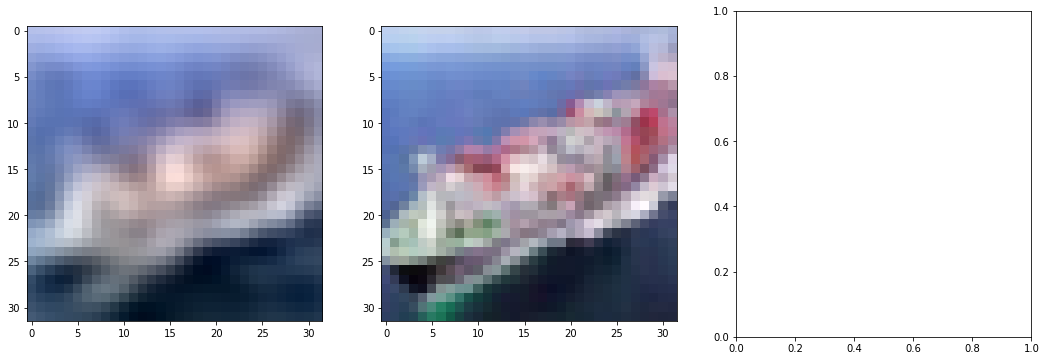

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.005755
tensor(1.1238, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


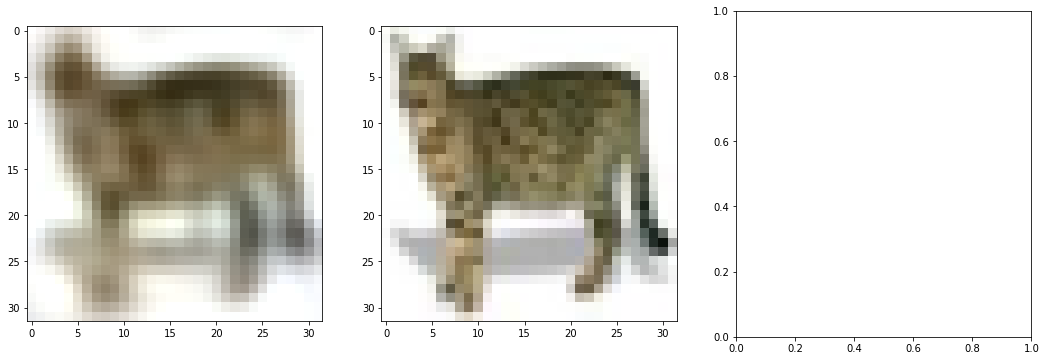

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.005547
tensor(1.1297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


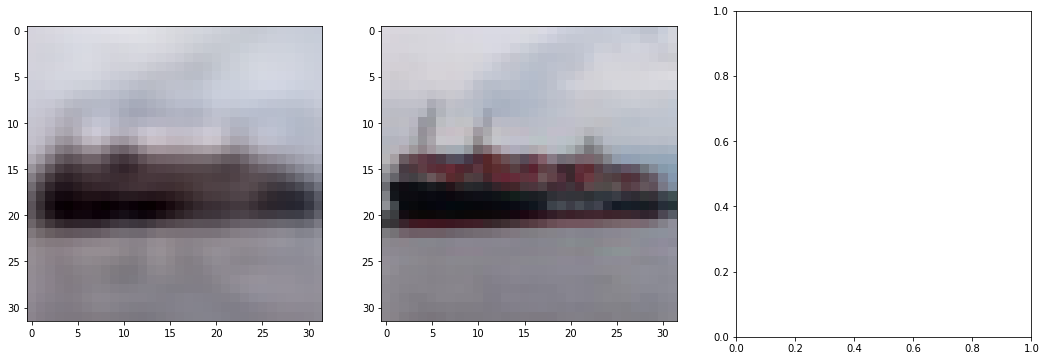

Step 0, Total loss 0.006456
tensor(1.0983, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


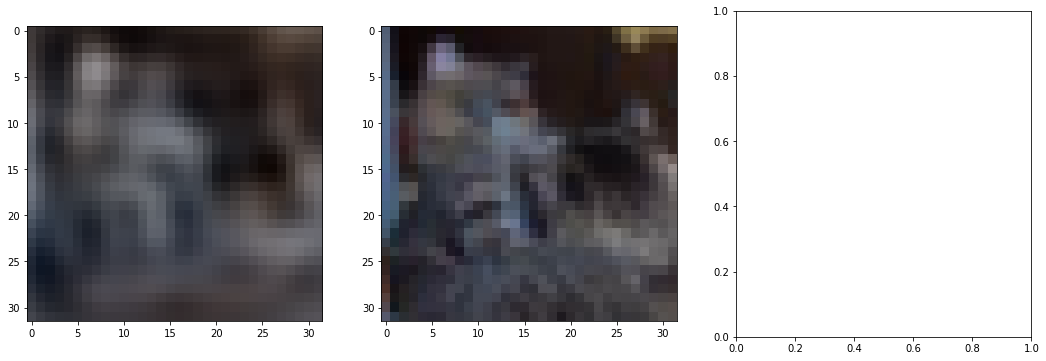

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006360
tensor(1.1010, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


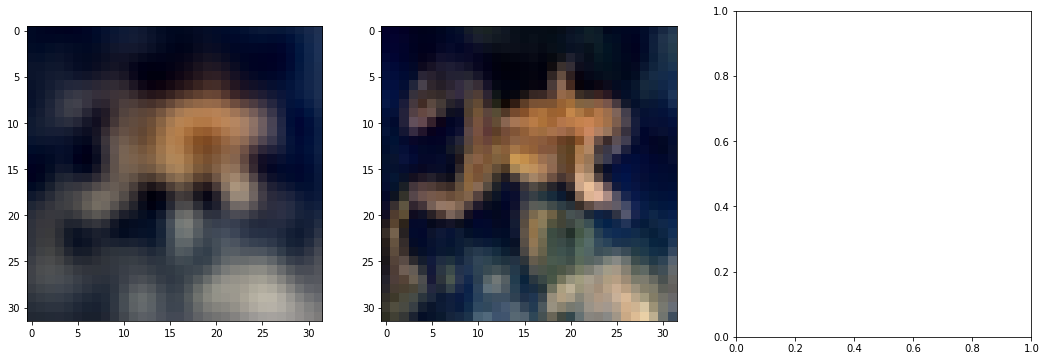

Step 500, Total loss 0.005487
tensor(1.1256, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


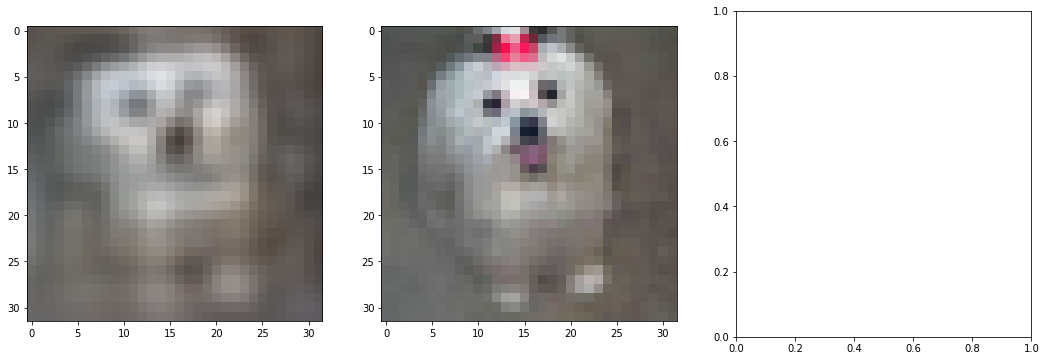

Step 750, Total loss 0.005386
tensor(1.0883, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


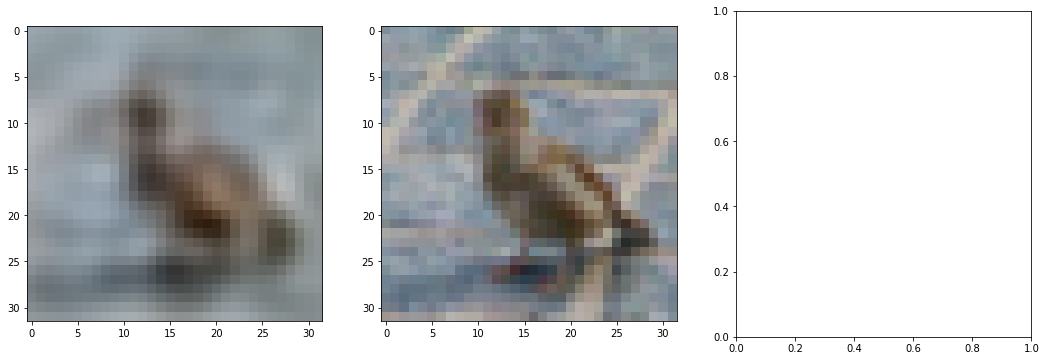

Step 1000, Total loss 0.005571
tensor(1.0723, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


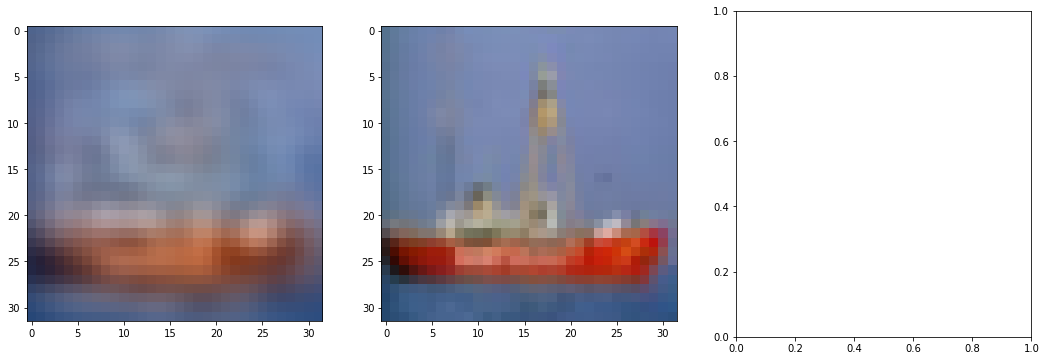

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.005768
tensor(1.1287, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


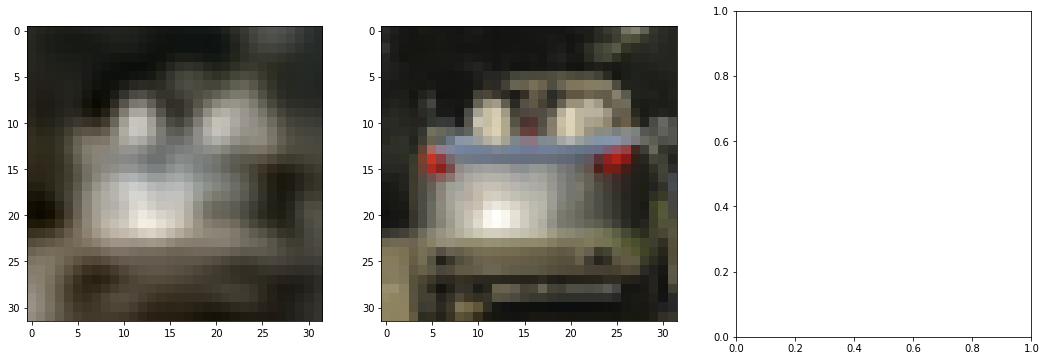

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500, Total loss 0.005734
tensor(1.1808, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


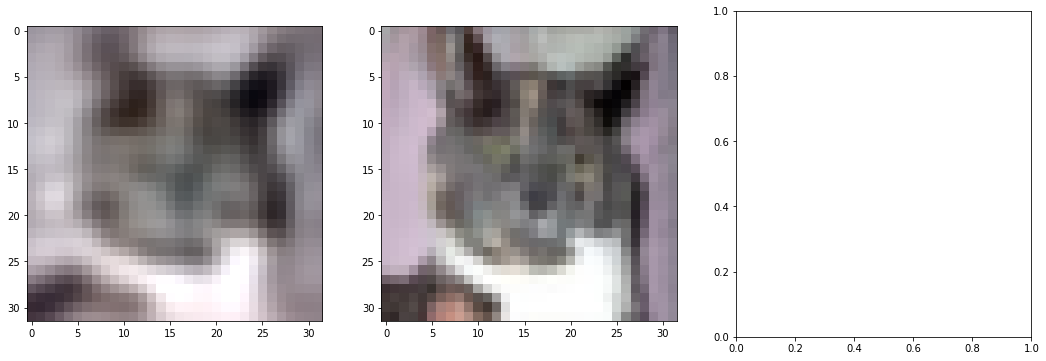

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006625
tensor(1.0999, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


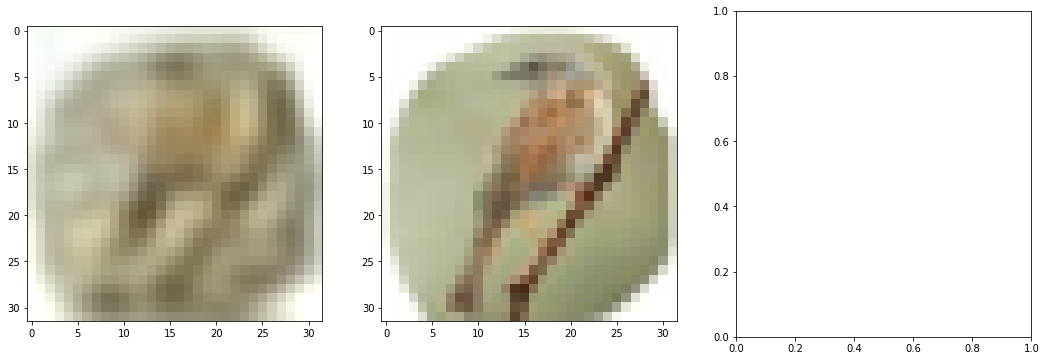

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.006205
tensor(1.1316, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


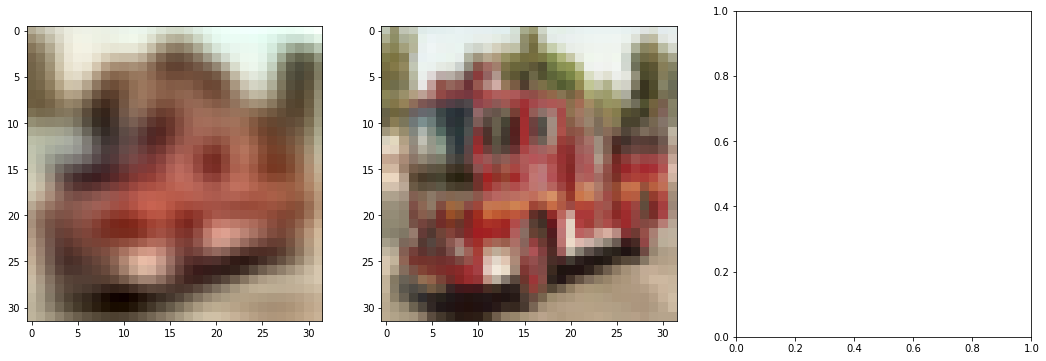

Step 2250, Total loss 0.005773
tensor(1.1044, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


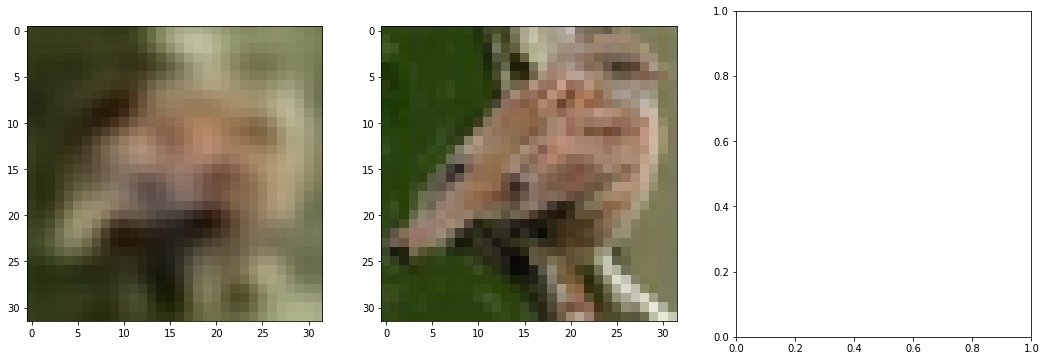

Step 2500, Total loss 0.006458
tensor(1.0877, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


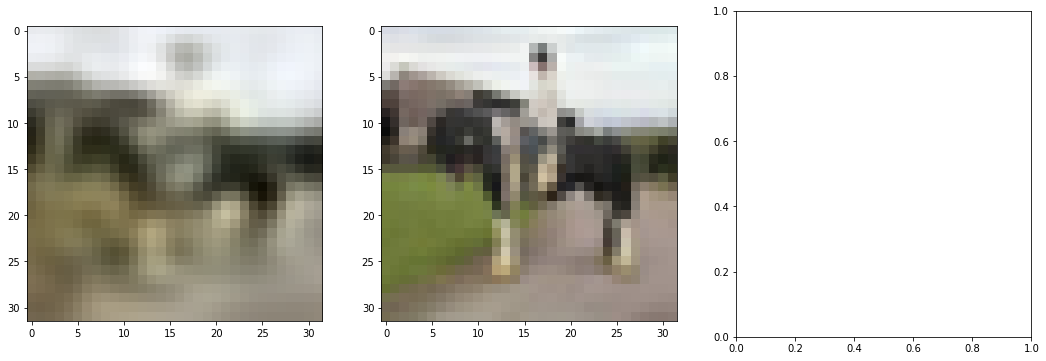

Step 2750, Total loss 0.004814
tensor(1.1143, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


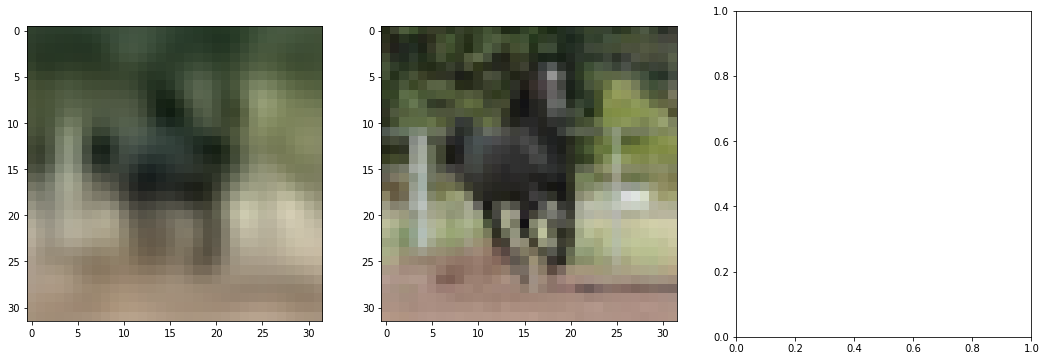

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000, Total loss 0.005044
tensor(1.0993, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


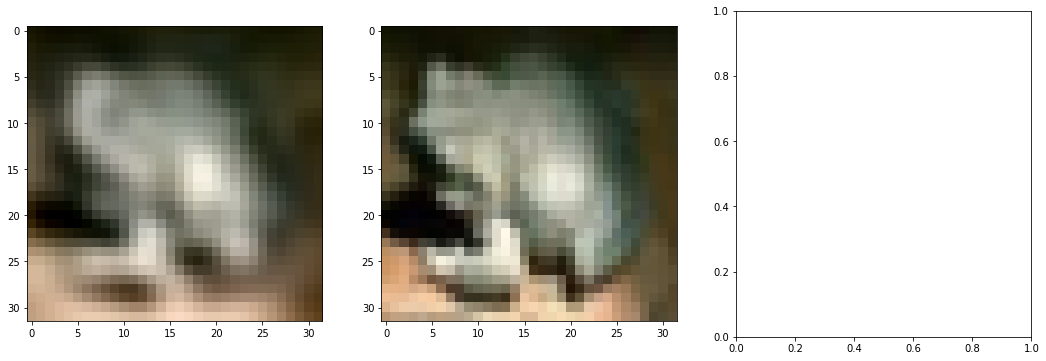

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.006013
tensor(1.1435, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


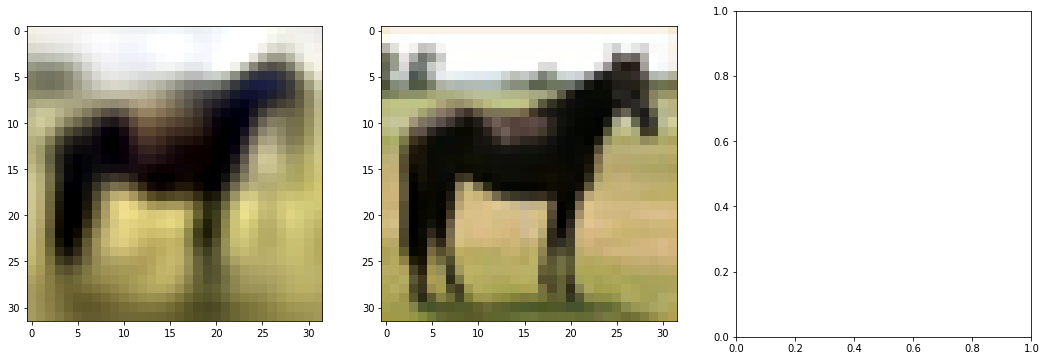

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 250, Total loss 0.006297
tensor(1.1506, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


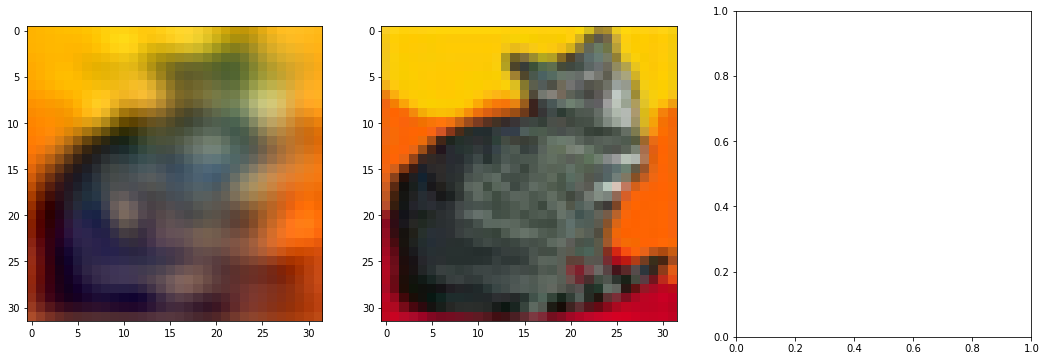

Step 500, Total loss 0.006519
tensor(1.0954, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


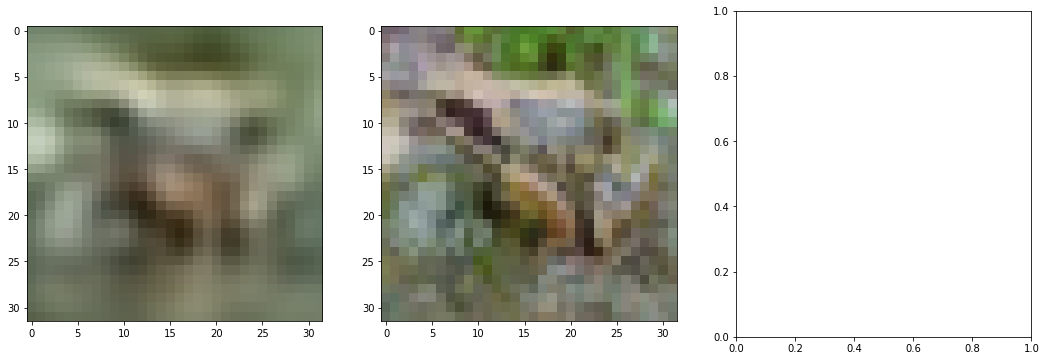

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total loss 0.004965
tensor(1.1086, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


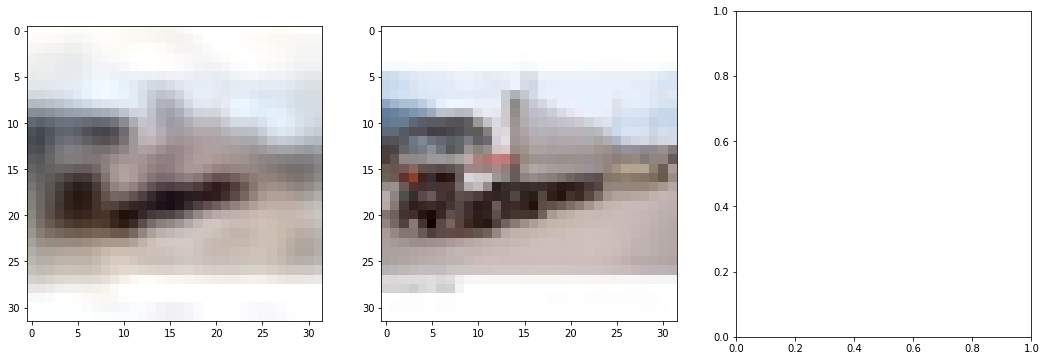

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.006537
tensor(1.0948, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


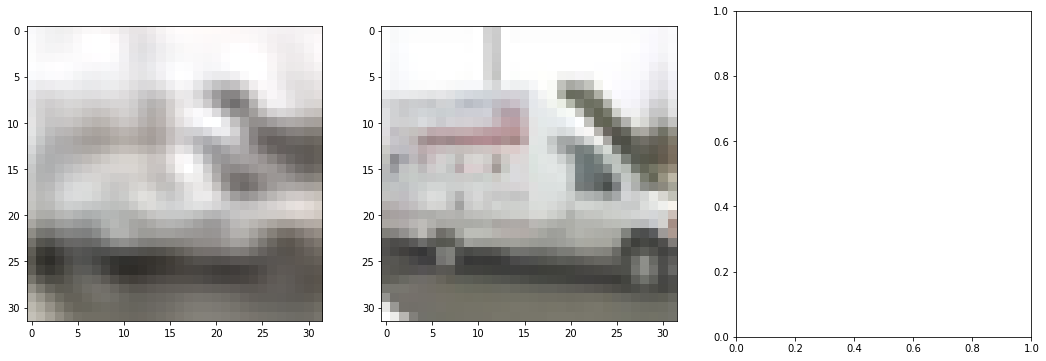

Step 1250, Total loss 0.005688
tensor(1.1802, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


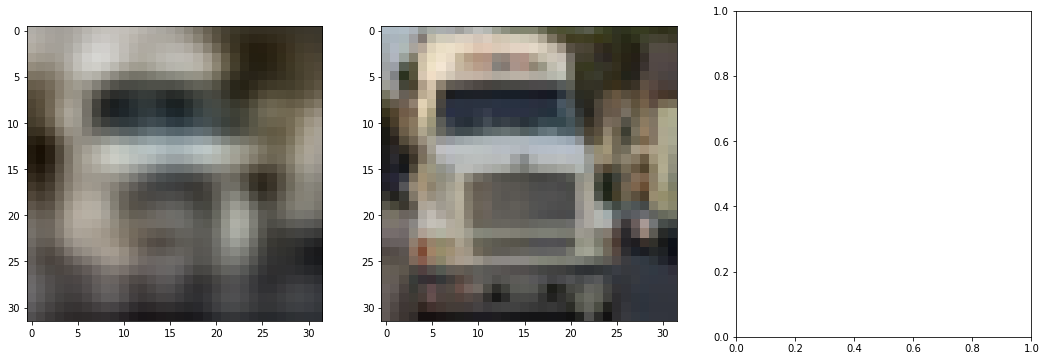

Step 1500, Total loss 0.005992
tensor(1.0660, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


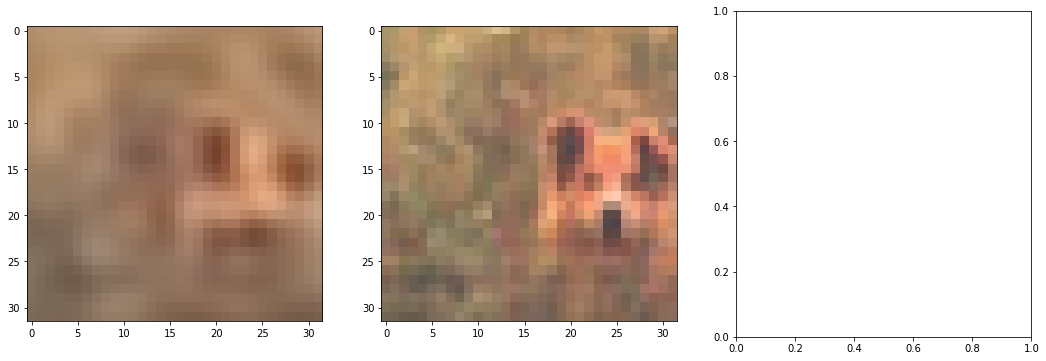

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.006079
tensor(1.1183, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


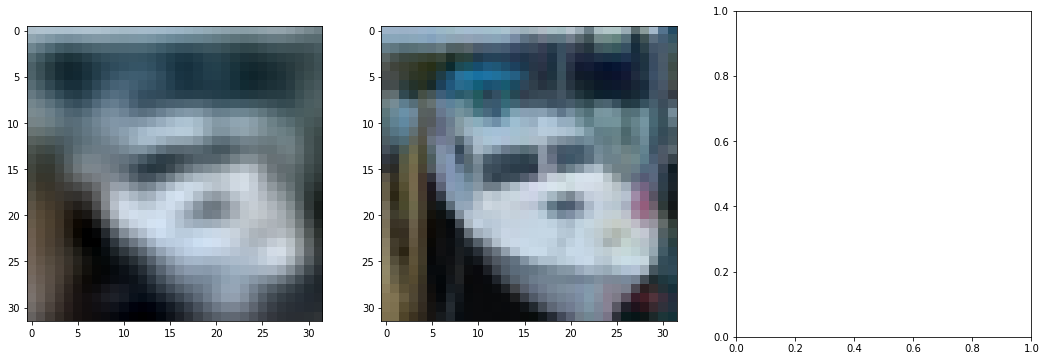

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.005007
tensor(1.1420, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


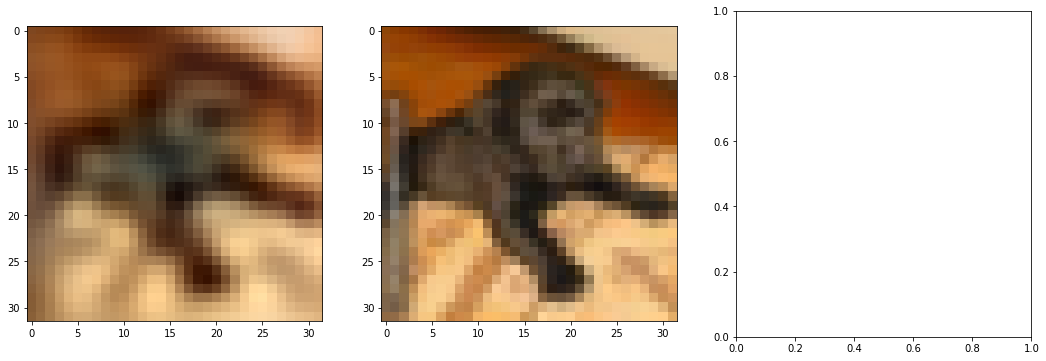

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.005212
tensor(1.0844, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


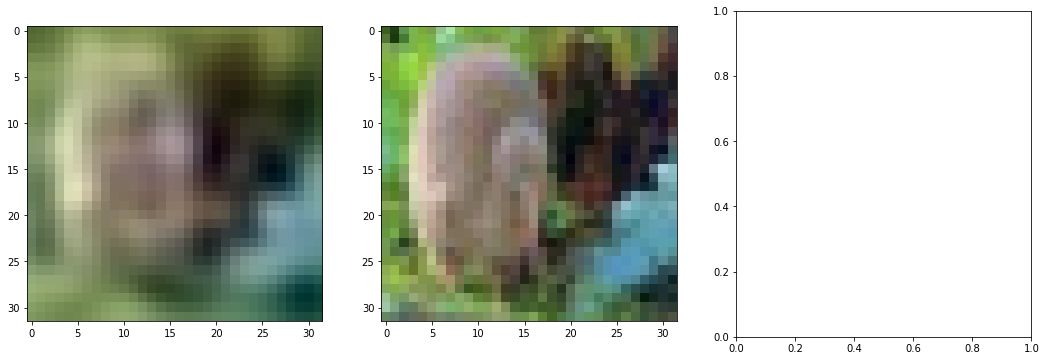

Step 2500, Total loss 0.005560
tensor(1.2017, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


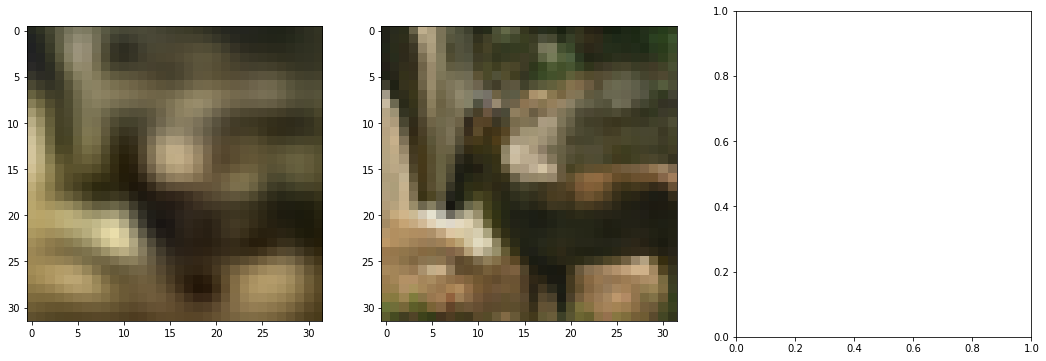

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.005913
tensor(1.1168, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


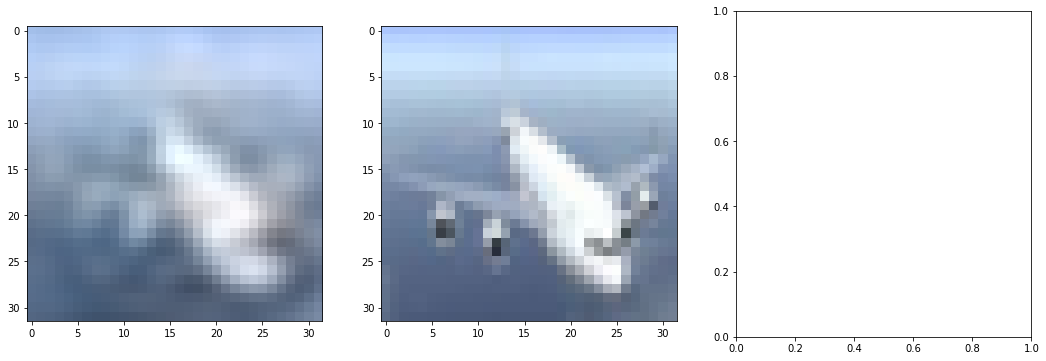

In [ ]:
total_steps = 1000000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50
batch_size = 8

optim = torch.optim.Adam(lr=5e-5, params=[
                            {'params': net.hyper_net.parameters()},
                            {'params': net.encoder.parameters()}
                        ])

for e in range(100):
  for i, (img, coords) in enumerate(loader):
      
      # model_input, ground_truth = coords# get_mgrid(28, 2), torch.Tensor(np.array(mnist_trainset[step % len(mnist_trainset)][0])).reshape((784, 1))
      # model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
      img, coords = img.cuda(), coords.cuda()

      out = net({'img_sparse': img.view((16, 3, 32, 32)).cuda(), 'coords': coords.cuda()})

      model_output = out["model_out"]
      embedding = out["latent_vec"]
      hypo_params = out["hypo_params"]

      all_hypo_params = torch.cat([x.view(-1) for x in list(hypo_params.values())])

      loss = ((model_output.view((-1, 32 * 32 * 3, 1)).cuda() - (img / 255))**2).mean() + 0.1 * ((embedding.cuda())**2).mean() + 100 * ((all_hypo_params.cuda())**2).mean()
      
      if not i % 250:
          print("Step %d, Total loss %0.6f" % (i, loss))

          print(torch.max(model_output))
          print(torch.max(img))

          fig, axes = plt.subplots(1,3, figsize=(18,6))
          axes[0].imshow((model_output[0]).cpu().view(32, 32, 3).detach().numpy())
          axes[1].imshow((img / 255)[0].cpu().view(32, 32, 3).detach().numpy())
          plt.show()

          torch.save(net.state_dict(), "cifar_siren_2")

      optim.zero_grad()
      loss.backward()
      optim.step()

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# net.load_state_dict(torch.load("/content/drive/Shareddrives/HarvardProjects/cifar_siren"))
# torch.save(net.state_dict(), "cifar_siren")

<All keys matched successfully>

In [27]:
net_2 = ConvolutionalNeuralProcessImplicit2DHypernet(1, 1, image_resolution=28)
net_2.cuda()
net_2.load_state_dict(torch.load("/content/drive/My Drive/mnist_siren"))

RuntimeError: ignored

Step 0, Total loss 0.004507
tensor(1.0303, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


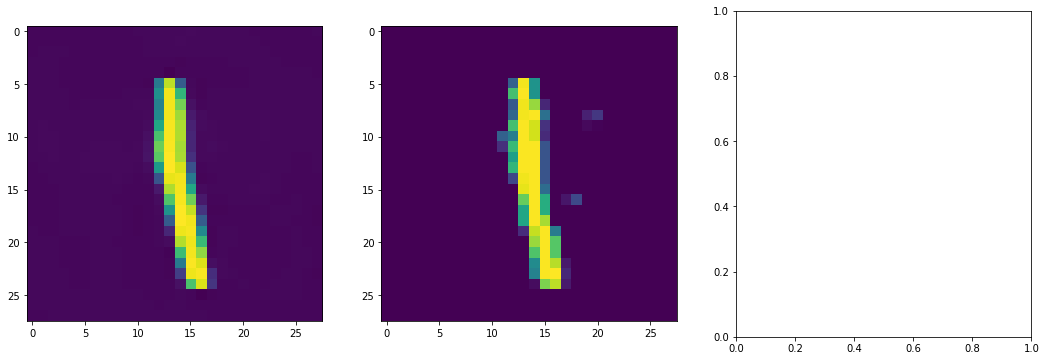

Step 250, Total loss 0.004942
tensor(1.0342, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


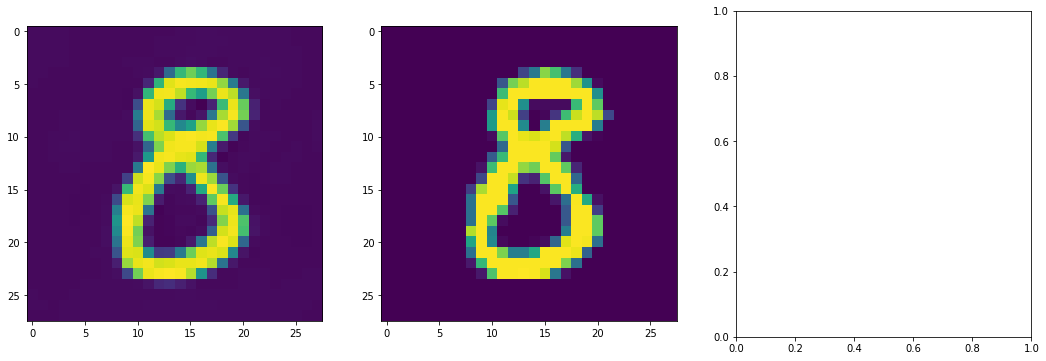

KeyboardInterrupt: ignored

In [ ]:
total_steps = 1000000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50
batch_size = 8

optim = torch.optim.Adam(lr=5e-5, params=[
                            {'params': net_2.hyper_net.parameters()},
                            {'params': net_2.encoder.parameters()}
                        ])

for e in range(100):
  for i, (img, coords) in enumerate(loader):
      
      # model_input, ground_truth = coords# get_mgrid(28, 2), torch.Tensor(np.array(mnist_trainset[step % len(mnist_trainset)][0])).reshape((784, 1))
      # model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
      img, coords = img.cuda(), coords.cuda()

      out = net_2({'img_sparse': img.view((32, 1, 28, 28)).cuda(), 'coords': coords.cuda()})

      model_output = out["model_out"]
      embedding = out["latent_vec"]
      hypo_params = out["hypo_params"]

      all_hypo_params = torch.cat([x.view(-1) for x in list(hypo_params.values())])

      loss = ((model_output.cuda() - (img / 255))**2).mean() + 0.1 * ((embedding.cuda())**2).mean() + 100 * ((all_hypo_params.cuda())**2).mean()
      
      if not i % 250:
          print("Step %d, Total loss %0.6f" % (i, loss))

          print(torch.max(model_output))
          print(torch.max(img))

          fig, axes = plt.subplots(1,3, figsize=(18,6))
          axes[0].imshow((model_output[0]).cpu().view(28,28).detach().numpy())
          axes[1].imshow((img / 255)[0].cpu().view(28,28).detach().numpy())
          plt.show()

      optim.zero_grad()
      loss.backward()
      optim.step()

In [ ]:
loader = DataLoader(MNISTSirenDataset(mnist_testset), batch_size=1, shuffle=True)
  for i, (img, coords) in enumerate(loader):
img, coords = img.cuda(), coords.cuda()
out = net_2({'img_sparse': img.view((32, 1, 28, 28)).cuda(), 'coords': coords.cuda()})

RuntimeError: ignored